# Preprocessing

In [1]:
# 라이브러리 불러오기
import pandas as pd
import numpy as np

import matplotlib
import matplotlib.pyplot as plt
import seaborn as sns
import warnings

from pykrx import stock
from datetime import timedelta

In [2]:
# func 모음 - 전처리 시 필요

# 1. 종목코드를 6자리로 통일. ex) 990 -> 000990
def padding(x):
    x = str(x)
    return x.rjust(6, "0")

# 2. 결산월 12월인 것만 선택
# : 전체 데이터 4963개 중에서 12월 결산인 데이터가 4836개이다. 나머지 결산월의 데이터가 전체의 2.5%로 데이터량이 작기도하고 결측치가 많아 제거
def func_yearin(x):
    if x[5:7] == '12':
        return True
    else:
        return False

# 3. 회계년도컬럼, 년도만 뽑아서 int화
def change_year(x):
    return int(x[:4])

# 4. 연결, 개별재무제표 통합을 위해 연결재무 데이터 컬럼명 통일화 : "(IFRS연결)"제거
def func_replace_col1(x):
    x = x.replace(" ","")
    x = x.replace(",","")
    x = x.replace("(비교)","")
    return x.replace("(IFRS연결)","")

# 5. 연결, 개별재무제표 통합을 위해 개별재무 데이터 컬럼명 통일화 : "(IFRS)"제거
def func_replace_col2(x):
    x = x.replace(" ","")
    x = x.replace(",","")
    x = x.replace("(비교)","")
    return x.replace("(IFRS)","")

# 6. 2020년 raw data 제외
def func_rm_2020(x):
    if x[:4] == "2020":
        return False
    else:
        return True

# 7. True, False 반전
def func_not(x):
    return not x

## 투자근거 - 주가 상승 확인

/var/folders/x3/lny9bbwx64b561c29r4y4z400000gn/T/ipykernel_2177/2190819290.py:11: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


<AxesSubplot: xlabel='날짜'>

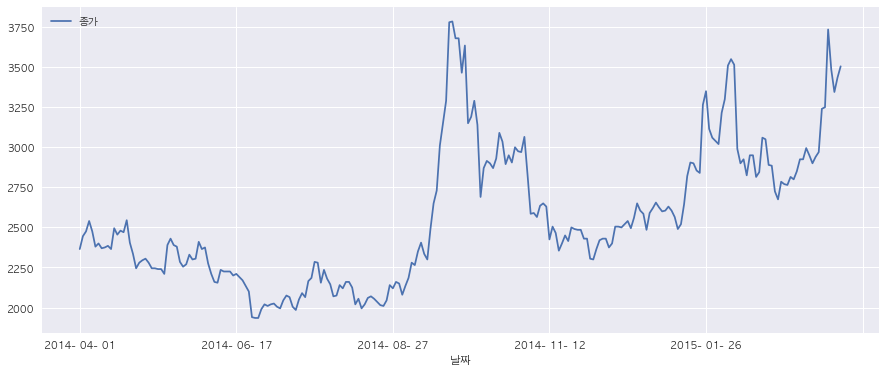

In [13]:
df_원익큐브 = pd.read_csv("./datasets/raw/주가상승확인/원익큐브_20140401.csv", index_col="날짜")
df_원익큐브.sort_values(by="날짜", ascending=True, inplace=True)

def func_replace(x):
    return int(x.replace(",",""))

df_원익큐브["종가"] = df_원익큐브["종가"].map(func_replace)

import matplotlib.pyplot as plt
import warnings
plt.style.use('seaborn')
warnings.simplefilter(action='ignore', category=FutureWarning)
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams["font.family"] = "AppleGothic"

df_원익큐브.plot(y = ['종가'], figsize = [15,6], grid = True)

/var/folders/x3/lny9bbwx64b561c29r4y4z400000gn/T/ipykernel_2177/1283740010.py:11: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


<AxesSubplot: xlabel='날짜'>

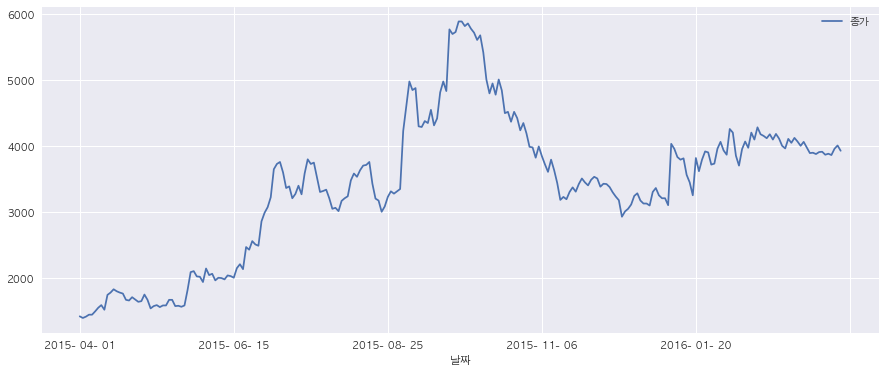

In [14]:
df_라온시큐어 = pd.read_csv("./datasets/raw/주가상승확인/라온시큐어_20140401.csv", index_col="날짜")
df_라온시큐어.sort_values(by="날짜", ascending=True, inplace=True)

def func_replace(x):
    return int(x.replace(",",""))

df_라온시큐어["종가"] = df_라온시큐어["종가"].map(func_replace)

import matplotlib.pyplot as plt
import warnings
plt.style.use('seaborn')
warnings.simplefilter(action='ignore', category=FutureWarning)
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams["font.family"] = "AppleGothic"

df_라온시큐어.plot(y = ['종가'], figsize = [15,6], grid = True)

<img width="1155" alt="image" src="https://user-images.githubusercontent.com/88031549/236753116-a0fdc106-18fa-46f5-a61f-409e222d81d0.png">


---
## 재무데이터 전처리 및 통합
- 연결재무제표 데이터 결측치를 별도재무제표 데이터로 대체
- 파생변수 생성을 위한 추가변수 전처리 후 데이터 통합

### 1. 데이터 통합(연결,별도)

In [101]:
# 1) 연결재무제표
list_drop_연결_부가가치1 = ['세금과공과(IFRS연결)(백만원)', "기계투자효율(IFRS연결)"]
list_drop_연결_성장성1 = ['비유동생물자산증가율(IFRS연결)', '투자부동산증가율(IFRS연결)',]
list_drop_연결_수익성1 = ['기타손익비률(IFRS연결)', '외환이익 대 매출액비율(IFRS연결)', '광고선전비 대 매출액비율(IFRS연결)', '세금과공과 대 세금과공과 차감전순이익률(IFRS연결)', '세금과공과 대 총비용비율(IFRS연결)', '감가상각비 대 총비용비율(IFRS연결)',
                    '감가상각률(IFRS연결)', '누적감가상각률(IFRS연결)', '1주당매출액(IFRS연결)(원)', '1주당순이익(IFRS연결)(원)', '1주당 CASH FLOW(IFRS연결)(원)', '1주당정상영업이익(IFRS연결)(원)',]
list_drop_연결_안정성1 = ['비유동비율(IFRS연결)','비유동장기적합률(IFRS연결)','매출채권 대 매입채무비율(IFRS연결)','매출채권 대 상,제품비율(IFRS연결)', '부채비율(IFRS연결)','단기차입금 대 총차입금비율(IFRS연결)','유보액대비율(IFRS연결)','유보액 대 납입자본배율(IFRS연결)',
                    '유동자산집중도(IFRS연결)','비유동자산집중도(IFRS연결)','투자집중도(IFRS연결)', '정상영업이익대비이자보상배율(IFRS연결)', '이자보상배율(순금융비용)(IFRS연결)']
list_drop_연결_활동성1 = ['경영자본회전률(IFRS연결)','상품,제품회전률(IFRS연결)','원,부재료회전률(IFRS연결)','재공품회전률(IFRS연결)']

# 2) 개별재무제표
list_drop_별도_부가가치2 = ['세금과공과(IFRS)(백만원)', "기계투자효율(IFRS)"]
list_drop_별도_성장성2 = ['비유동생물자산증가율(IFRS)', '투자부동산증가율(IFRS)',]
list_drop_별도_수익성2 = ['기타손익비률(IFRS)', '외환이익 대 매출액비율(IFRS)', '광고선전비 대 매출액비율(IFRS)', '세금과공과 대 세금과공과 차감전순이익률(IFRS)', '세금과공과 대 총비용비율(IFRS)', '감가상각비 대 총비용비율(IFRS)',
                    '감가상각률(IFRS)', '누적감가상각률(IFRS)', '1주당매출액(IFRS)(원)', '1주당순이익(IFRS)(원)', '1주당 CASH FLOW(IFRS)(원)', '1주당정상영업이익(IFRS)(원)',]
list_drop_별도_안정성2 = ['비유동비율(IFRS)','비유동장기적합률(IFRS)','매출채권 대 매입채무비율(IFRS)','매출채권 대 상,제품비율(IFRS)', '부채비율(IFRS)','단기차입금 대 총차입금비율(IFRS)','유보액대비율(IFRS)','유보액 대 납입자본배율(IFRS)',
                    '유동자산집중도(IFRS)','비유동자산집중도(IFRS)','투자집중도(IFRS)', '정상영업이익대비이자보상배율(IFRS)', '이자보상배율(순금융비용)(IFRS)']
list_drop_별도_활동성2 = ['경영자본회전률(IFRS)','상품,제품회전률(IFRS)','원,부재료회전률(IFRS)','재공품회전률(IFRS)']

# TS2000 데이터 중 중복 컬럼
list_overlap1 = ['부가가치(IFRS연결)(백만원)', '종업원1인당 부가가치(IFRS연결)(백만원)', '총자본투자효율(IFRS연결)', '기계투자효율(IFRS연결)', '부가가치율(IFRS연결)']
list_overlap2 = ['부가가치(IFRS)(백만원)', '종업원1인당 부가가치(IFRS)(백만원)', '총자본투자효율(IFRS)', '기계투자효율(IFRS)', '부가가치율(IFRS)']

# drop column
list_col_drop = ['임차료(백만원)','총자본투자효율', '부가가치율', '설비투자효율', '노동소득분배율', '자본분배율', '이윤분배율','정상영업이익증가율', '총포괄이익증가율', '매출액정상영업이익률',
    '총자본정상영업이익률', '자기자본정상영업이익률', '경영자본정상영업이익률', '자본금정상영업이익률', '수지비율(관계기업투자손익제외)', 'R&D투자효율','적립금비율(재정비율)', '당좌자산구성비율',
    '비유동자산구성비율','당좌비율', '재고자산대순운전자본비율', '유동부채비율', '비유동부채비율', '비유동부채대순운전자본비율', 'CASHFLOW대부채비율', 'CASHFLOW대차입금비율', 'CASHFLOW대총자본비율',
    'CASHFLOW대매출액비율', '매입채무회전기간', '재고자산회전기간', '매출채권회전기간', '종업원1인당정상영업이익(백만원)', '1회전기간', '종업원1인당부가가치(백만원)', '종업원1인당매출액(백만원)',
    '종업원1인당정상영업이익(백만원)', '종업원1인당순이익(백만원)', '종업원1인당인건비(백만원)', '노동장비율', '기계장비율', '자본집약도', '종업원1인당부가가치증가율', '종업원1인당매출액증가율', '종업원1인당인건비증가율']

In [102]:
# Data Load(연결제무재표)
df_연결_부가가치 = pd.read_excel("./datasets/raw/사업보고서/사업보고서_연결/연결_부가가치.xlsx")
df_연결_생산성 = pd.read_excel("./datasets/raw/사업보고서/사업보고서_연결/연결_생산성.xlsx")
df_연결_성장성 = pd.read_excel("./datasets/raw/사업보고서/사업보고서_연결/연결_성장성.xlsx")
df_연결_수익성 = pd.read_excel("./datasets/raw/사업보고서/사업보고서_연결/연결_수익성.xlsx")
df_연결_안정성 = pd.read_excel("./datasets/raw/사업보고서/사업보고서_연결/연결_안정성.xlsx")
df_연결_활동성 = pd.read_excel("./datasets/raw/사업보고서/사업보고서_연결/연결_활동성.xlsx")
df_연결_부가가치.drop(list_drop_연결_부가가치1, axis=1, inplace=True)
df_연결_생산성 = df_연결_생산성.drop(list_overlap1, axis=1)
df_연결_성장성.drop(list_drop_연결_성장성1, axis=1, inplace=True)
df_연결_수익성.drop(list_drop_연결_수익성1, axis=1, inplace=True)
df_연결_안정성.drop(list_drop_연결_안정성1, axis=1, inplace=True)
df_연결_활동성.drop(list_drop_연결_활동성1, axis=1, inplace=True)

# Data merge
df_사업보고서_연결 = pd.merge(df_연결_부가가치, df_연결_생산성, on=["회사명","거래소코드","회계년도"], how = 'inner')
df_사업보고서_연결 = pd.merge(df_사업보고서_연결, df_연결_성장성, on=["회사명","거래소코드","회계년도"], how = 'inner')
df_사업보고서_연결 = pd.merge(df_사업보고서_연결, df_연결_수익성, on=["회사명","거래소코드","회계년도"], how = 'inner')
df_사업보고서_연결 = pd.merge(df_사업보고서_연결, df_연결_안정성, on=["회사명","거래소코드","회계년도"], how = 'inner')
df_사업보고서_연결 = pd.merge(df_사업보고서_연결, df_연결_활동성, on=["회사명","거래소코드","회계년도"], how = 'inner')
df_사업보고서_연결["거래소코드"] = df_사업보고서_연결["거래소코드"].map(padding) # 거래소코드 padding
df_사업보고서_연결 = df_사업보고서_연결[df_사업보고서_연결["회계년도"].map(func_yearin)] # 12월 결산 기업만
df_사업보고서_연결["회계년도"] = df_사업보고서_연결["회계년도"].map(change_year) # 년도만 표시

# 컬럼명에서 "IFRS연결", " ", "," 제거
list_col = list()
for i in list(df_사업보고서_연결.columns):
    list_col.append(func_replace_col1(i))
df_사업보고서_연결.columns = list_col

df_사업보고서_연결.drop(list_col_drop, axis=1, inplace=True)
df_사업보고서_연결.drop_duplicates(['거래소코드',"회계년도"], keep='last', inplace=True)
df_사업보고서_연결.reset_index(drop=True, inplace=True)

df_사업보고서_연결.to_csv("./datasets/raw/사업보고서/사업보고서_연결.csv")
df_사업보고서_연결.shape

(19145, 69)

In [103]:
# Data Load(별도제무재표)
df_별도_부가가치 = pd.read_excel("./datasets/raw/사업보고서/사업보고서_별도/별도_부가가치.xlsx")
df_별도_생산성 = pd.read_excel("./datasets/raw/사업보고서/사업보고서_별도/별도_생산성.xlsx")
df_별도_성장성 = pd.read_excel("./datasets/raw/사업보고서/사업보고서_별도/별도_성장성.xlsx")
df_별도_수익성 = pd.read_excel("./datasets/raw/사업보고서/사업보고서_별도/별도_수익성.xlsx")
df_별도_안정성 = pd.read_excel("./datasets/raw/사업보고서/사업보고서_별도/별도_안정성.xlsx")
df_별도_활동성 = pd.read_excel("./datasets/raw/사업보고서/사업보고서_별도/별도_활동성.xlsx")
df_별도_부가가치.drop(list_drop_별도_부가가치2, axis=1, inplace=True)
df_별도_생산성 = df_별도_생산성.drop(list_overlap2, axis=1)
df_별도_성장성.drop(list_drop_별도_성장성2, axis=1, inplace=True)
df_별도_수익성.drop(list_drop_별도_수익성2, axis=1, inplace=True)
df_별도_안정성.drop(list_drop_별도_안정성2, axis=1, inplace=True)
df_별도_활동성.drop(list_drop_별도_활동성2, axis=1, inplace=True)

# Data Merge
df_사업보고서_별도 = pd.merge(df_별도_부가가치, df_별도_생산성, on=["회사명","거래소코드","회계년도"], how = 'inner')
df_사업보고서_별도 = pd.merge(df_사업보고서_별도, df_별도_성장성, on=["회사명","거래소코드","회계년도"], how = 'inner')
df_사업보고서_별도 = pd.merge(df_사업보고서_별도, df_별도_수익성, on=["회사명","거래소코드","회계년도"], how = 'inner')
df_사업보고서_별도 = pd.merge(df_사업보고서_별도, df_별도_안정성, on=["회사명","거래소코드","회계년도"], how = 'inner')
df_사업보고서_별도 = pd.merge(df_사업보고서_별도, df_별도_활동성, on=["회사명","거래소코드","회계년도"], how = 'inner')
df_사업보고서_별도 = df_사업보고서_별도[df_사업보고서_별도["회계년도"].map(func_rm_2020)]
df_사업보고서_별도["거래소코드"] = df_사업보고서_별도["거래소코드"].map(padding)
df_사업보고서_별도 = df_사업보고서_별도[df_사업보고서_별도["회계년도"].map(func_yearin)]
df_사업보고서_별도["회계년도"] = df_사업보고서_별도["회계년도"].map(change_year)

# 컬럼명에서 "IFRS", " ", "," 제거
list_col = list()
for i in list(df_사업보고서_별도.columns):
    list_col.append(func_replace_col2(i))
df_사업보고서_별도.columns = list_col

df_사업보고서_별도.drop(list_col_drop, axis=1, inplace=True)
df_사업보고서_별도.drop_duplicates(['거래소코드',"회계년도"], keep='last', inplace=True)
df_사업보고서_별도.reset_index(drop=True, inplace=True)

df_사업보고서_별도.to_csv("./datasets/raw/사업보고서/사업보고서_별도.csv")
df_사업보고서_별도.shape

(19145, 69)

### 2. 연결재무데이터 결측치 확인

In [37]:
df_연결 = pd.read_csv("./datasets/raw/사업보고서/사업보고서_연결.csv", index_col=0)
df_연결.reset_index(drop=True, inplace=True)
df_연결["거래소코드"] = df_연결["거래소코드"].map(padding)
df_연결

회사명   거래소코드  회계년도  부가가치(백만원)  법인세비용차감전(계속사업)손익(백만원)  인건비(백만원)  \
0      (주)CMG제약  058820  2011    3472.17               -1508.28   3118.67   
1      (주)CMG제약  058820  2012     269.31               -6660.15   4712.51   
2      (주)CMG제약  058820  2013    6994.90                 311.19   4986.26   
3      (주)CMG제약  058820  2014    7061.34                 158.04   5599.85   
4      (주)CMG제약  058820  2015    4315.37               -3650.09   6218.50   
...         ...     ...   ...        ...                    ...       ...   
19140   흥아해운(주)  003280  2015  103792.31               13509.26  52570.08   
19141   흥아해운(주)  003280  2016  105291.39              -16576.37  70010.36   
19142   흥아해운(주)  003280  2017   46072.27              -72565.48  60440.89   
19143   흥아해운(주)  003280  2018   34054.90              -91209.02  68757.28   
19144   흥아해운(주)  003280  2019   13366.25              -54638.04  32265.06   

       금융비용(백만원)  감가상각비(백만원)  종업원수  총자본증가율  ...  타인자본회전률  매입채무회전률  유동자산회전률  \
0         141.57     1344.09   NaN    1.98  ...     2.01    11.95     1.25   
1         411.52     1404.34   NaN  109.15  ...     0.93     7.83     0.52   
2         337.40     1116.14   NaN   -2.09  ...     1.26     6.20     0.48   
3        -147.32     1464.84   NaN    3.86  ...     2.85     5.27     0.68   
4         -29.83     1890.05   NaN   -2.64  ...     2.88     5.66     0.99   
...          ...         ...   ...     ...  ...      ...      ...      ...   
19140   18751.33    18964.51   NaN   21.93  ...     1.54    16.05     5.83   
19141   26701.98    25157.71   NaN   21.08  ...     1.20    16.26     6.98   
19142   30688.04    27508.83   NaN  -11.43  ...     1.12    15.39     7.68   
19143   32180.14    24326.58   NaN   -5.33  ...     1.03    11.87     6.73   
19144   22368.67    23529.72   NaN  -46.38  ...     0.18     2.41     1.01   

       당좌자산회전률  재고자산회전률  매출채권회전률  비유동자산회전률  유형자산회전율  순운전자본회전률  운전자본회전률  
0         1.55     6.42     2.45      1.38     1.77      0.86     0.00  
1         0.57     5.71     1.85      1.48     1.71      0.42     0.00  
2         0.52     5.39     2.07      1.47     2.03      0.42     0.79  
3         0.80     4.77     1.86      0.96     1.54      0.56     0.74  
4         1.22     5.22     2.10      0.90     1.48      0.75     0.60  
...        ...      ...      ...       ...      ...       ...      ...  
19140     6.38    68.48    25.33      1.47     2.09      2.15     0.01  
19141     7.96    56.47    25.24      1.10     1.44      2.19     0.02  
19142     9.30    44.09    23.08      1.05     1.36      2.09     0.02  
19143     8.14    38.87    19.15      1.06     1.43      1.75     0.02  
19144     1.16     7.70     4.78      0.20     0.28      0.28     0.10  

[19145 rows x 69 columns]

외국계기업 제거

In [38]:
def func_isnt_fcompany(x):
    if x[:1] == '9':
        return False
    else:
        return True

print("제거할 외국계기업 데이터 수 : ", len(df_연결[df_연결["거래소코드"].map(func_isnt_fcompany).map(func_not)]))
df_연결 = df_연결[df_연결["거래소코드"].map(func_isnt_fcompany)]
df_연결.shape # 외국계기업 데이터 140개 제거

제거할 외국계기업 데이터 수 :  140


(19005, 69)

거래소 코드가 2개인 기업(26개)과 기업명이 2개인 거래소 코드가 존재

In [39]:
print("회사수 : ", len(df_연결["회사명"].unique()))
print("거래소코드수 : ", len(df_연결["거래소코드"].unique()))
# 25개 차이

회사수 :  2478
거래소코드수 :  2504


 - 거래소코드 중복기업 전처리(최신 거래소코드의 데이터만 남긴다)

In [40]:
list_overlap_code = list()
for i in list(df_연결["회사명"].unique()):
    if len(df_연결[df_연결["회사명"]==i]["거래소코드"].unique()) > 1:
        list_overlap_code.append(i)
print("거래소코드가 2개인 기업 수", len(list_overlap_code), "개")
# list_overlap_code

거래소코드가 2개인 기업 수 26 개


In [42]:
# 중복 거래소코드 제거
def func_overlap_code(x):
    if x == (df_연결[df_연결["회사명"]==company_name]["거래소코드"].iloc[-1]) :
        return True
    else:
        return False

list_companyname = list(df_연결["회사명"].unique())
dfs = list()
for i in list_companyname:
    company_name = i
    #각 기업별로 데이터프레임 생성
    df_concat = df_연결[df_연결["회사명"]==i]
    df_concat = df_concat[df_concat["거래소코드"].map(func_overlap_code)] # 거래소코드 바뀌기 전의 거래소코드의 데이터는 삭제
    dfs.append(df_concat)
df_연결 = pd.concat(dfs)
df_연결.reset_index(drop=True, inplace=True)

 - 회사명 중복기업 전처리(최신 회사명의 데이터만 남긴다) -> 없었음

In [43]:
# 회사명이 2개인 거래소코드 존재 확인 - 엄슴
list_overlap_code = list()
for i in list(df_연결["거래소코드"].unique()):
    if len(df_연결[df_연결["거래소코드"]==i]["회사명"].unique()) > 1:
        list_overlap_code.append(i)
list_overlap_code

[]

In [45]:
df_연결.shape # 19005개 -> 18877로 감소

(18877, 69)

스팩주 확인
- 직접 and 코드로 찾아본 결과 없었음
- 결측치데이터는 drop되어 다 누락된 것으로 예상

In [47]:
df_연결[df_연결["회사명"].str.contains('인수목적')].index # spac회사 확인(이외에도 직접 다 확인해봄)

Int64Index([], dtype='int64')

In [48]:
len(df_연결["거래소코드"].unique()) # 기업수

2478

결측치 확인!

In [50]:
df_연결.isna().sum().to_dict()

{'회사명': 0,
 '거래소코드': 0,
 '회계년도': 0,
 '부가가치(백만원)': 6077,
 '법인세비용차감전(계속사업)손익(백만원)': 6077,
 '인건비(백만원)': 6077,
 '금융비용(백만원)': 6077,
 '감가상각비(백만원)': 6077,
 '종업원수': 18877,
 '총자본증가율': 6077,
 '유형자산증가율': 6077,
 '비유동자산증가율': 6077,
 '유동자산증가율': 6077,
 '재고자산증가율': 6077,
 '자기자본증가율': 6077,
 '매출액증가율': 6077,
 '순이익증가율': 6077,
 '종업원수증가율': 18877,
 '매출액총이익률': 6077,
 '매출액순이익률': 6077,
 '총자본사업이익률': 6077,
 '총자본순이익률': 6077,
 '자기자본순이익률': 6077,
 '경영자본순이익률': 6077,
 '자본금순이익률': 6077,
 '매출원가대매출액비율': 6077,
 '영업비용대영업수익비율': 6077,
 '금융손익비율': 6077,
 '금융비용부담률': 6077,
 '기업순이익률': 6077,
 '인건비대총비용비율': 6077,
 '금융비용대총비용비율': 6077,
 '이자부담률': 6077,
 '지급이자율': 6077,
 '차입금평균이자율': 6077,
 '유보율': 6077,
 '사내유보율': 18877,
 '사내유보대자기자본비율': 18877,
 '평균배당률': 18877,
 '자기자본배당률': 18877,
 '배당성향': 18877,
 '1주당순자산(원)': 18877,
 '유동자산구성비율': 6077,
 '재고자산대유동자산비율': 6077,
 '유동자산대비유동자산비율': 6077,
 '자기자본구성비율': 6077,
 '타인자본구성비율': 6077,
 '자기자본배율': 6077,
 '유동비율': 6077,
 '현금비율': 6077,
 '매출채권비율': 6077,
 '매입채무대재고자산비율': 6077,
 '순운전자본비율': 6077,
 '차입금의존도': 6077,
 '차입금비율':

In [51]:
# 결측치 갯수 별로 데이터를 나누어 따로 전처리.
na_1 = int(list(df_연결.isna().sum().to_dict().values()).count(0))
na_2 = int(list(df_연결.isna().sum().to_dict().values()).count(18877)) # 데이터 하나도 없는 컬럼!
na_3 = int(list(df_연결.isna().sum().to_dict().values()).count(6077)) # 데이터 하나도 없는 기업&회계년도 데이터
print("전체컬럼수 :", len(list(df_연결.isna().sum().to_dict().values())))
print("1) 인덱스컬럼수 : ", na_1)
print("2) 데이터 하나도 없는 컬럼수 : ", na_2)
print("3) 데이터 하나도 없는 행의 컬럼수에서 위 2)번 컬럼수 제외 : ", na_3)
print(" -> 인덱스컬럼을 제외한 모든 컬럼에 결측치 존재")


# df_연결.isna().sum().to_dict()
# 2) 데이터 하나도 없는 컬럼 리스트 : 8개
list_na_col = ['배당성향', '종업원수', '종업원수증가율', '사내유보율', '사내유보대자기자본비율', '평균배당률', '자기자본배당률', '1주당순자산(원)']

# 대표적으로 "배당성향" 컬럼이 연결재무제표 데이터에 없다.
# 그 이유는 ts2000이 "한국거래소 배당성향 계산 기준"인 별도 재무제표 기준으로 계산하기 떄문.

# ts2000의 배당성향과 naver 기준 배당성향이 다른데 ts2000은 한국거래소 기준으로 별도 재무제표 기준으로 계산하고있어 그에 따른 수치이고 
# Naver는 금감원기준으로 연결 재무제표 기준으로 계산하고 있어 두 곳의 값이 다른걸 확인했다. 따라서 우리는 한국거래소기준으로 배당성향을 사용함을 확인.
# 나머지 7개 컬럼도 이와 같은 이유로 개별재무제표에서만 계산되기에 연결재무제표 데이터에서 누락됐을 것이라 예상.

전체컬럼수 : 69
1) 인덱스컬럼수 :  3
2) 데이터 하나도 없는 컬럼수 :  8
3) 데이터 하나도 없는 행의 컬럼수에서 위 2)번 컬럼수 제외 :  58
 -> 인덱스컬럼을 제외한 모든 컬럼에 결측치 존재


### 3. 별도재무데이터로 결측치 대체(데이터 하나도 없는 컬럼)

In [52]:
# 개별재무제표 데이터 불러오기
df_별도 = pd.read_csv("./datasets/raw/사업보고서/사업보고서_별도.csv", index_col=0)
df_별도["거래소코드"] = df_별도["거래소코드"].map(padding)
df_별도.shape

(19145, 69)

In [53]:
# 중복 거래소코드 제거
def func_overlap_code(x):
    if x == (df_별도[df_별도["회사명"]==company_name]["거래소코드"].iloc[-1]) :
        return True
    else:
        return False

list_companyname = list(df_별도["회사명"].unique())
dfs = list()
for i in list_companyname:
    company_name = i
    #각 기업별로 데이터프레임 생성
    df_concat = df_별도[df_별도["회사명"]==i]
    df_concat = df_concat[df_concat["거래소코드"].map(func_overlap_code)] # 거래소코드 바뀌기 전의 거래소코드의 데이터는 삭제
    dfs.append(df_concat)
df_별도 = pd.concat(dfs)
df_별도.reset_index(drop=True, inplace=True)

In [54]:
# 중복 회사명 제거
def func_overlap_code(x):
    if x == (df_별도[df_별도["거래소코드"]==company_code]["회사명"].iloc[-1]) :
        return True
    else:
        return False

list_companyname = list(df_별도["거래소코드"].unique())
dfs = list()
for i in list_companyname:
    company_code = i
    #각 기업별로 데이터프레임 생성
    df_concat = df_별도[df_별도["거래소코드"]==i]
    df_concat = df_concat[df_concat["회사명"].map(func_overlap_code)] # 회사명 바뀌기 전의 회사명의 데이터는 삭제
    dfs.append(df_concat)
df_별도 = pd.concat(dfs)
df_별도.reset_index(drop=True, inplace=True)

In [55]:
df_별도["회사명"].value_counts()

(주)CMG제약         9
(주)휴먼엔           9
(주)휴맥스           9
(주)휴니드테크놀러지스     9
(주)휠라홀딩스         9
                ..
(주)티브로드도봉강북방송    1
(주)티브로드한빛방송      1
풍림산업(주)          1
(주)소마젠           1
에스에스씨피(주)        1
Name: 회사명, Length: 2506, dtype: int64

In [56]:
# df_연결에서 데이터가 하나도 없는 컬럼을 개별재무데이터로 대체한 "df_재무" 생성
df_재무 = df_연결.copy()
df_재무 = df_재무.drop(list_na_col, axis=1)
df_재무.reset_index(drop=True, inplace=True)
df_별도_대체 = df_별도[["거래소코드","회계년도"]+list_na_col]
df_별도_대체.reset_index(drop=True, inplace=True)

# 별도 & 연결 재무데이터 통합.
df_재무 = pd.merge(df_재무, df_별도_대체, on=["거래소코드","회계년도"], how = 'left')
df_재무.shape

(18877, 69)

In [57]:
df_재무.isna().sum().to_dict()

{'회사명': 0,
 '거래소코드': 0,
 '회계년도': 0,
 '부가가치(백만원)': 6077,
 '법인세비용차감전(계속사업)손익(백만원)': 6077,
 '인건비(백만원)': 6077,
 '금융비용(백만원)': 6077,
 '감가상각비(백만원)': 6077,
 '총자본증가율': 6077,
 '유형자산증가율': 6077,
 '비유동자산증가율': 6077,
 '유동자산증가율': 6077,
 '재고자산증가율': 6077,
 '자기자본증가율': 6077,
 '매출액증가율': 6077,
 '순이익증가율': 6077,
 '매출액총이익률': 6077,
 '매출액순이익률': 6077,
 '총자본사업이익률': 6077,
 '총자본순이익률': 6077,
 '자기자본순이익률': 6077,
 '경영자본순이익률': 6077,
 '자본금순이익률': 6077,
 '매출원가대매출액비율': 6077,
 '영업비용대영업수익비율': 6077,
 '금융손익비율': 6077,
 '금융비용부담률': 6077,
 '기업순이익률': 6077,
 '인건비대총비용비율': 6077,
 '금융비용대총비용비율': 6077,
 '이자부담률': 6077,
 '지급이자율': 6077,
 '차입금평균이자율': 6077,
 '유보율': 6077,
 '유동자산구성비율': 6077,
 '재고자산대유동자산비율': 6077,
 '유동자산대비유동자산비율': 6077,
 '자기자본구성비율': 6077,
 '타인자본구성비율': 6077,
 '자기자본배율': 6077,
 '유동비율': 6077,
 '현금비율': 6077,
 '매출채권비율': 6077,
 '매입채무대재고자산비율': 6077,
 '순운전자본비율': 6077,
 '차입금의존도': 6077,
 '차입금비율': 6077,
 '이자보상배율(이자비용)': 6077,
 '총자본회전률': 6077,
 '자기자본회전률': 6077,
 '자본금회전률': 6077,
 '타인자본회전률': 6077,
 '매입채무회전률': 6077,
 '유동자산회전률': 6077,
 '당좌자산회전률': 

### 4. 별도재무데이터로 결측치 대체(데이터 하나도 없는 행)

In [58]:
# df_재무를 완전데이터와 결측데이터로 나눈 뒤 결측데이터를 개별재무데이터로 대체시키고, df_재무로 다시 통합하면 끝!
df_재무_완전 = df_재무[df_재무["총자본증가율"].isna().map(func_not)]
# df_재무_완전

df_재무_결측 = df_재무[df_재무["총자본증가율"].isna()]
df_재무_결측

회사명   거래소코드  회계년도  부가가치(백만원)  법인세비용차감전(계속사업)손익(백만원)  인건비(백만원)  \
63     (주)SNT에너지  100840  2011        NaN                    NaN       NaN   
64     (주)SNT에너지  100840  2012        NaN                    NaN       NaN   
65     (주)SNT에너지  100840  2013        NaN                    NaN       NaN   
66     (주)SNT에너지  100840  2014        NaN                    NaN       NaN   
67     (주)SNT에너지  100840  2015        NaN                    NaN       NaN   
...          ...     ...   ...        ...                    ...       ...   
18863    흥구석유(주)  024060  2015        NaN                    NaN       NaN   
18864    흥구석유(주)  024060  2016        NaN                    NaN       NaN   
18865    흥구석유(주)  024060  2017        NaN                    NaN       NaN   
18866    흥구석유(주)  024060  2018        NaN                    NaN       NaN   
18867    흥구석유(주)  024060  2019        NaN                    NaN       NaN   

       금융비용(백만원)  감가상각비(백만원)  총자본증가율  유형자산증가율  ...  순운전자본회전률  운전자본회전률   배당성향  \
63           NaN         NaN     NaN      NaN  ...       NaN      NaN   0.00   
64           NaN         NaN     NaN      NaN  ...       NaN      NaN  15.59   
65           NaN         NaN     NaN      NaN  ...       NaN      NaN  13.13   
66           NaN         NaN     NaN      NaN  ...       NaN      NaN  31.45   
67           NaN         NaN     NaN      NaN  ...       NaN      NaN  13.11   
...          ...         ...     ...      ...  ...       ...      ...    ...   
18863        NaN         NaN     NaN      NaN  ...       NaN      NaN  39.68   
18864        NaN         NaN     NaN      NaN  ...       NaN      NaN  66.77   
18865        NaN         NaN     NaN      NaN  ...       NaN      NaN  70.43   
18866        NaN         NaN     NaN      NaN  ...       NaN      NaN  73.63   
18867        NaN         NaN     NaN      NaN  ...       NaN      NaN  26.30   

        종업원수  종업원수증가율  사내유보율  사내유보대자기자본비율   평균배당률  자기자본배당률  1주당순자산(원)  
63     184.0     2.22    0.0        76.67    0.00     0.00   22041.59  
64     195.0     5.98    0.0        72.32   40.00     0.77   25109.67  
65     209.0     7.18    0.0        74.22   60.00     1.07   27059.53  
66     218.0     4.31    0.0        75.09    0.00     1.71   28251.49  
67     232.0     6.42    0.0        77.63    0.00     1.53   31655.59  
...      ...      ...    ...          ...     ...      ...        ...  
18863   99.0    -8.33    0.0        44.07   77.55     1.70    4467.15  
18864   96.0    -3.03    0.0        44.84   96.94     2.10    4511.11  
18865   93.0    -3.13    0.0        45.23   96.94     2.08    4549.57  
18866   84.0    -9.68    0.0        45.83  116.33     2.48    4576.04  
18867   79.0    -5.95    0.0        50.44  145.41     2.83    4984.23  

[6077 rows x 69 columns]

In [59]:
# 행전체가 결측치인 것 중 개별재무 데이터로 대체한 컬럼 말고 나머지 결측치 컬럼 리스트(58개))
list_na_col2 = ['부가가치(백만원)', '법인세비용차감전(계속사업)손익(백만원)', '인건비(백만원)', '금융비용(백만원)', '감가상각비(백만원)', '총자본증가율', '유형자산증가율', '비유동자산증가율',
    '유동자산증가율', '재고자산증가율', '자기자본증가율', '매출액증가율', '순이익증가율', '매출액총이익률', '매출액순이익률', '총자본사업이익률', '총자본순이익률', '자기자본순이익률',
    '경영자본순이익률', '자본금순이익률', '매출원가대매출액비율', '영업비용대영업수익비율', '금융손익비율', '금융비용부담률', '기업순이익률', '인건비대총비용비율', '금융비용대총비용비율',
    '이자부담률', '지급이자율', '차입금평균이자율', '유보율', '유동자산구성비율', '재고자산대유동자산비율', '유동자산대비유동자산비율', '자기자본구성비율', '타인자본구성비율', '자기자본배율',
    '유동비율', '현금비율', '매출채권비율', '매입채무대재고자산비율', '순운전자본비율', '차입금의존도', '차입금비율', '이자보상배율(이자비용)', '총자본회전률', '자기자본회전률',
    '자본금회전률', '타인자본회전률', '매입채무회전률', '유동자산회전률', '당좌자산회전률', '재고자산회전률', '매출채권회전률', '비유동자산회전률', '유형자산회전율', '순운전자본회전률', '운전자본회전률']

df_재무_결측 = df_재무_결측.drop(list_na_col2, axis=1)
df_재무_결측 = pd.merge(df_재무_결측, df_별도[["거래소코드","회계년도"]+list_na_col2], on=["거래소코드","회계년도"], how = 'left')
# df_재무_결측

In [60]:
df_재무 = pd.concat([df_재무_완전,df_재무_결측], axis=0)
# df_재무

In [61]:
df_재무.isna().sum().to_dict()

{'회사명': 0,
 '거래소코드': 0,
 '회계년도': 0,
 '부가가치(백만원)': 1939,
 '법인세비용차감전(계속사업)손익(백만원)': 1939,
 '인건비(백만원)': 1939,
 '금융비용(백만원)': 1939,
 '감가상각비(백만원)': 1939,
 '총자본증가율': 1939,
 '유형자산증가율': 1939,
 '비유동자산증가율': 1939,
 '유동자산증가율': 1939,
 '재고자산증가율': 1939,
 '자기자본증가율': 1939,
 '매출액증가율': 1939,
 '순이익증가율': 1939,
 '매출액총이익률': 1939,
 '매출액순이익률': 1939,
 '총자본사업이익률': 1939,
 '총자본순이익률': 1939,
 '자기자본순이익률': 1939,
 '경영자본순이익률': 1939,
 '자본금순이익률': 1939,
 '매출원가대매출액비율': 1939,
 '영업비용대영업수익비율': 1939,
 '금융손익비율': 1939,
 '금융비용부담률': 1939,
 '기업순이익률': 1939,
 '인건비대총비용비율': 1939,
 '금융비용대총비용비율': 1939,
 '이자부담률': 1939,
 '지급이자율': 1939,
 '차입금평균이자율': 1939,
 '유보율': 1939,
 '유동자산구성비율': 1939,
 '재고자산대유동자산비율': 1939,
 '유동자산대비유동자산비율': 1939,
 '자기자본구성비율': 1939,
 '타인자본구성비율': 1939,
 '자기자본배율': 1939,
 '유동비율': 1939,
 '현금비율': 1939,
 '매출채권비율': 1939,
 '매입채무대재고자산비율': 1939,
 '순운전자본비율': 1939,
 '차입금의존도': 1939,
 '차입금비율': 1939,
 '이자보상배율(이자비용)': 1939,
 '총자본회전률': 1939,
 '자기자본회전률': 1939,
 '자본금회전률': 1939,
 '타인자본회전률': 1939,
 '매입채무회전률': 1939,
 '유동자산회전률': 1939,
 '당좌자산회전률': 

In [62]:
print("제거행 갯수 : ", len(df_재무[df_재무["종업원수"].isna()]))
print("제거기업 갯수 : ", len(list(df_재무[df_재무["종업원수"].isna()]["거래소코드"].unique())))
# 737개 기업의 어떤 년도에는 재무,별도 데이터 둘 다 없는 컬럼이 존재하기에 해당 연도 데이터 제거!(1948행)
# 데이터 누락된 사유 : "필수 공시 지표가 아닌 지표는 누락되어 데이터 존재x" 또는 "비상장기업(이었던 기업) 데이터"

제거행 갯수 :  1949
제거기업 갯수 :  738


In [63]:
df_재무 = df_재무[df_재무["종업원수"].isna().map(func_not)] # 위 결측치 없는 데이터로 필터링
df_재무

회사명   거래소코드  회계년도  부가가치(백만원)  법인세비용차감전(계속사업)손익(백만원)  인건비(백만원)  \
0     (주)CMG제약  058820  2011    3472.17               -1508.28   3118.67   
1     (주)CMG제약  058820  2012     269.31               -6660.15   4712.51   
2     (주)CMG제약  058820  2013    6994.90                 311.19   4986.26   
3     (주)CMG제약  058820  2014    7061.34                 158.04   5599.85   
4     (주)CMG제약  058820  2015    4315.37               -3650.09   6218.50   
...        ...     ...   ...        ...                    ...       ...   
6072   흥구석유(주)  024060  2015    7835.95                3745.60   3353.12   
6073   흥구석유(주)  024060  2016    6993.48                2746.52   3362.28   
6074   흥구석유(주)  024060  2017    6826.79                2570.80   3251.42   
6075   흥구석유(주)  024060  2018    7373.52                3013.26   3500.30   
6076   흥구석유(주)  024060  2019   15072.74               10814.52   3345.25   

      금융비용(백만원)  감가상각비(백만원)  총자본증가율  유형자산증가율  ...  순운전자본회전률  운전자본회전률   배당성향  \
0        141.57     1344.09    1.98    -5.90  ...      0.86     0.00   0.00   
1        411.52     1404.34  109.15    -4.12  ...      0.42     0.00   0.00   
2        337.40     1116.14   -2.09    16.09  ...      0.42     0.79   0.00   
3       -147.32     1464.84    3.86    74.30  ...      0.56     0.74   0.00   
4        -29.83     1890.05   -2.64    -5.37  ...      0.75     0.60   0.00   
...         ...         ...     ...      ...  ...       ...      ...    ...   
6072     -64.43      393.85   12.89    -0.74  ...      8.87     0.00  39.68   
6073      26.86      384.73    1.39    -5.61  ...      8.24     0.00  66.77   
6074     106.86      396.07    0.98    -0.56  ...      7.20     0.00  70.43   
6075     -19.39      359.35   -5.89    -0.36  ...      8.08     0.00  73.63   
6076    -187.36      508.49   11.24    -7.00  ...      6.91     0.00  26.30   

       종업원수  종업원수증가율  사내유보율  사내유보대자기자본비율   평균배당률  자기자본배당률  1주당순자산(원)  
0     135.0     4.65    0.0      -245.87    0.00     0.00     386.51  
1     134.0    -0.74    0.0      -165.71    0.00     0.00     643.72  
2     136.0     1.49    0.0      -106.33    0.00     0.00     492.83  
3     164.0    20.59    0.0      -106.65    0.00     0.00     447.56  
4     156.0    -4.88    0.0      -120.22    0.00     0.00     397.60  
...     ...      ...    ...          ...     ...      ...        ...  
6072   99.0    -8.33    0.0        44.07   77.55     1.70    4467.15  
6073   96.0    -3.03    0.0        44.84   96.94     2.10    4511.11  
6074   93.0    -3.13    0.0        45.23   96.94     2.08    4549.57  
6075   84.0    -9.68    0.0        45.83  116.33     2.48    4576.04  
6076   79.0    -5.95    0.0        50.44  145.41     2.83    4984.23  

[16928 rows x 69 columns]

In [64]:
df_재무.isna().sum().to_dict()

{'회사명': 0,
 '거래소코드': 0,
 '회계년도': 0,
 '부가가치(백만원)': 0,
 '법인세비용차감전(계속사업)손익(백만원)': 0,
 '인건비(백만원)': 0,
 '금융비용(백만원)': 0,
 '감가상각비(백만원)': 0,
 '총자본증가율': 0,
 '유형자산증가율': 0,
 '비유동자산증가율': 0,
 '유동자산증가율': 0,
 '재고자산증가율': 0,
 '자기자본증가율': 0,
 '매출액증가율': 0,
 '순이익증가율': 0,
 '매출액총이익률': 0,
 '매출액순이익률': 0,
 '총자본사업이익률': 0,
 '총자본순이익률': 0,
 '자기자본순이익률': 0,
 '경영자본순이익률': 0,
 '자본금순이익률': 0,
 '매출원가대매출액비율': 0,
 '영업비용대영업수익비율': 0,
 '금융손익비율': 0,
 '금융비용부담률': 0,
 '기업순이익률': 0,
 '인건비대총비용비율': 0,
 '금융비용대총비용비율': 0,
 '이자부담률': 0,
 '지급이자율': 0,
 '차입금평균이자율': 0,
 '유보율': 0,
 '유동자산구성비율': 0,
 '재고자산대유동자산비율': 0,
 '유동자산대비유동자산비율': 0,
 '자기자본구성비율': 0,
 '타인자본구성비율': 0,
 '자기자본배율': 0,
 '유동비율': 0,
 '현금비율': 0,
 '매출채권비율': 0,
 '매입채무대재고자산비율': 0,
 '순운전자본비율': 0,
 '차입금의존도': 0,
 '차입금비율': 0,
 '이자보상배율(이자비용)': 0,
 '총자본회전률': 0,
 '자기자본회전률': 0,
 '자본금회전률': 0,
 '타인자본회전률': 0,
 '매입채무회전률': 0,
 '유동자산회전률': 0,
 '당좌자산회전률': 0,
 '재고자산회전률': 0,
 '매출채권회전률': 0,
 '비유동자산회전률': 0,
 '유형자산회전율': 0,
 '순운전자본회전률': 0,
 '운전자본회전률': 0,
 '배당성향': 0,
 '종업원수': 0,
 '종업원수증가율': 0,
 '사내유보율': 0,
 '사내유보

### 5. 추가변수 전처리 - 데이터 결측치 대체(별도로)
- 파생변수 생성을 위한 재무데이터 추가수집

In [65]:
df_연결_추가변수 = pd.read_excel("./datasets/raw/사업보고서/사업보고서_연결/연결_추가변수.xlsx") # 32개 컬럼 추가
df_연결_추가변수["거래소코드"] = df_연결_추가변수["거래소코드"].map(padding) # 거래소코드 padding
df_연결_추가변수 = df_연결_추가변수[df_연결_추가변수["회계년도"].map(func_yearin)] # 12월 결산 기업만
df_연결_추가변수["회계년도"] = df_연결_추가변수["회계년도"].map(change_year) # 년도만 표시

list_col = list() # 컬럼명에서 "IFRS연결", " ", "," 제거
for i in list(df_연결_추가변수.columns):
    list_col.append(func_replace_col1(i))
df_연결_추가변수.columns = list_col

df_연결_추가변수["외국인_주식분포비율"] = df_연결_추가변수["외국인_주식분포비율"].fillna(0) # 상장, 비상장 기업에 결측치 존재. 비상장기업의 경우 나중에 시가총액 데이터와 결합할 때 필터링되어 삭제. 상장기업의 결측치는 실제 0이라는 의미라 0으로 대체
df_연결_추가변수["보통주배당금_현금(천원)"] = df_연결_추가변수["보통주배당금_현금(천원)"].fillna(0) # 결측치 값은 배당을 안했다는 의미라 0으로 대체
df_연결_추가변수["우선주배당금_현금(천원)"] = df_연결_추가변수["우선주배당금_현금(천원)"].fillna(0)
df_연결_추가변수["배당금(총합)_현금(천원)"] = df_연결_추가변수["보통주배당금_현금(천원)"] + df_연결_추가변수["우선주배당금_현금(천원)"]

df_연결_추가변수.drop_duplicates(['거래소코드',"회계년도"], keep='last', inplace=True)
df_연결_추가변수.reset_index(drop=True, inplace=True)
df_연결_추가변수

회사명   거래소코드  회계년도  장기차입금(요약)(백만원)  자산(*)(요약)(백만원)  \
0      (주)CMG제약  058820  2011             0.0         27305.0   
1      (주)CMG제약  058820  2012             0.0         57108.0   
2      (주)CMG제약  058820  2013             0.0         55913.0   
3      (주)CMG제약  058820  2014             0.0         58068.0   
4      (주)CMG제약  058820  2015             0.0         56533.0   
...         ...     ...   ...             ...             ...   
19140   흥아해운(주)  003280  2015         64641.0        791641.0   
19141   흥아해운(주)  003280  2016         46829.0        958532.0   
19142   흥아해운(주)  003280  2017         37958.0        873409.0   
19143   흥아해운(주)  003280  2018         25794.0        803698.0   
19144   흥아해운(주)  003280  2019             0.0        430963.0   

       당기순이익(손실)(요약)(백만원)  현금및현금성자산(요약)(백만원)  영업활동으로인한현금흐름(간접법)(*)(요약)(백만원)  \
0                 -1508.0             1152.0                        -2560.0   
1                 -6660.0             4674.0                        -1573.0   
2                   296.0            21705.0                        -3939.0   
3                   158.0             8827.0                          725.0   
4                 -3650.0             2566.0                         2411.0   
...                   ...                ...                            ...   
19140             10517.0            20371.0                        33913.0   
19141            -17173.0            14116.0                        -1390.0   
19142            -61992.0            19970.0                        -6892.0   
19143            -86540.0            15273.0                       -33795.0   
19144            -51357.0            13657.0                       -12048.0   

       투자활동으로인한현금흐름(*)(요약)(백만원)  재무활동으로인한현금흐름(*)(요약)(백만원)  ...  우선주배당금_현금(천원)  \
0                       -1773.0                    3039.0  ...            0.0   
1                      -30266.0                   35361.0  ...            0.0   
2                       21135.0                    -157.0  ...            0.0   
3                      -13611.0                       5.0  ...            0.0   
4                       -8671.0                       0.0  ...            0.0   
...                         ...                       ...  ...            ...   
19140                    -601.0                  -29516.0  ...            0.0   
19141                  -14735.0                   10295.0  ...            0.0   
19142                   -2001.0                   14484.0  ...            0.0   
19143                   84962.0                  -55273.0  ...            0.0   
19144                  117484.0                 -107050.0  ...            0.0   

       부채(*)(요약)(백만원)  비유동금융부채(요약)(백만원)  유동금융부채(요약)(백만원)  사채(요약)(백만원)  \
0              9271.0               0.0           2134.0        478.0   
1             25517.0               0.0           2233.0      17362.0   
2              6915.0               0.0              0.0       1415.0   
3              9066.0               0.0              0.0          0.0   
4              9726.0               0.0              0.0          0.0   
...               ...               ...              ...          ...   
19140        618564.0             300.0              0.0      15000.0   
19141        766045.0             646.0              0.0      25800.0   
19142        737426.0            4988.0              0.0       8664.0   
19143        730550.0             328.0           5115.0      23120.0   
19144        400043.0          181085.0          28878.0       3571.0   

       장기매입채무및기타비유동채무(요약)(백만원)  기타금융업부채(요약)(백만원)  외국인_주식분포비율  매출원가(요약)(백만원)  \
0                          0.0               0.0        0.07        10326.0   
1                          0.0               0.0        0.29        11387.0   
2                          0.0               0.0        0.25        12507.0   
3                          0.0               0.0        0.34        14318.0   
4                          0.0       

In [66]:
df_연결_추가변수.isna().sum().to_dict()

{'회사명': 0,
 '거래소코드': 0,
 '회계년도': 0,
 '장기차입금(요약)(백만원)': 5799,
 '자산(*)(요약)(백만원)': 5799,
 '당기순이익(손실)(요약)(백만원)': 5799,
 '현금및현금성자산(요약)(백만원)': 5799,
 '영업활동으로인한현금흐름(간접법)(*)(요약)(백만원)': 5799,
 '투자활동으로인한현금흐름(*)(요약)(백만원)': 5799,
 '재무활동으로인한현금흐름(*)(요약)(백만원)': 5799,
 '유동자산(*)(요약)(백만원)': 5799,
 '유동부채(*)(요약)(백만원)': 5799,
 '법인세비용차감전순이익(손실)(요약)(백만원)': 5799,
 '*이자비용(요약)(백만원)': 5799,
 '배당금지급(-)(요약)(백만원)': 5799,
 '재고자산(요약)(백만원)': 5799,
 '매출채권및기타유동채권(요약)(백만원)': 5799,
 '단기차입금(요약)(백만원)': 5799,
 '유형자산(요약)(백만원)': 5799,
 '매출액(수익)(요약)(백만원)': 5799,
 '*(정상)영업손익(보고서기재)(요약)(백만원)': 5799,
 '이익잉여금(결손금)(요약)(백만원)': 5799,
 '자본(*)(요약)(백만원)': 5799,
 '통계청한국표준산업분류10차(대분류)': 0,
 '보통주배당금_현금(천원)': 0,
 '우선주배당금_현금(천원)': 0,
 '부채(*)(요약)(백만원)': 5799,
 '비유동금융부채(요약)(백만원)': 5799,
 '유동금융부채(요약)(백만원)': 5799,
 '사채(요약)(백만원)': 5799,
 '장기매입채무및기타비유동채무(요약)(백만원)': 5799,
 '기타금융업부채(요약)(백만원)': 5799,
 '외국인_주식분포비율': 0,
 '매출원가(요약)(백만원)': 5799,
 '배당금(총합)_현금(천원)': 0}

In [67]:
# df_연결_추가변수.isna().sum().to_dict()
na_1 = int(list(df_연결_추가변수.isna().sum().to_dict().values()).count(0))
na_2 = int(list(df_연결_추가변수.isna().sum().to_dict().values()).count(5799)) # 대표 : '장기차입금(요약)'
print("전체컬럼수 :", len(list(df_연결_추가변수.isna().sum().to_dict().values())))
print("1) 결측치 없는 컬럼 수 : ", na_1)
print("2) 데이터 하나도 없는 행의 컬럼수에서 위 2)번 컬럼수 제외 : ", na_2)
print(" -> 인덱스컬럼을 제외한 모든 컬럼에 결측치 존재")

전체컬럼수 : 35
1) 결측치 없는 컬럼 수 :  8
2) 데이터 하나도 없는 행의 컬럼수에서 위 2)번 컬럼수 제외 :  27
 -> 인덱스컬럼을 제외한 모든 컬럼에 결측치 존재


In [68]:
df_별도_추가변수 = pd.read_excel("./datasets/raw/사업보고서/사업보고서_별도/별도_추가변수.xlsx") # 26컬럼 추가
df_별도_추가변수["거래소코드"] = df_별도_추가변수["거래소코드"].map(padding) # 거래소코드 padding
df_별도_추가변수 = df_별도_추가변수[df_별도_추가변수["회계년도"].map(func_yearin)] # 12월 결산 기업만
df_별도_추가변수["회계년도"] = df_별도_추가변수["회계년도"].map(change_year) # 년도만 표시

list_col = list() # 컬럼명에서 "IFRS연결", " ", "," 제거
for i in list(df_별도_추가변수.columns):
    list_col.append(func_replace_col2(i))
df_별도_추가변수.columns = list_col

df_별도_추가변수.drop_duplicates(['거래소코드',"회계년도"], keep='last', inplace=True)
df_별도_추가변수.reset_index(drop=True, inplace=True)
df_별도_추가변수

회사명   거래소코드  회계년도  장기차입금(요약)(백만원)  자산(*)(요약)(백만원)  \
0      (주)CMG제약  058820  2011             0.0         27549.0   
1      (주)CMG제약  058820  2012             0.0         56989.0   
2      (주)CMG제약  058820  2013             0.0         55962.0   
3      (주)CMG제약  058820  2014             0.0         58127.0   
4      (주)CMG제약  058820  2015             0.0         56592.0   
...         ...     ...   ...             ...             ...   
19140   흥아해운(주)  003280  2015         64641.0        771212.0   
19141   흥아해운(주)  003280  2016         46829.0        942587.0   
19142   흥아해운(주)  003280  2017         37958.0        858558.0   
19143   흥아해운(주)  003280  2018         25794.0        782787.0   
19144   흥아해운(주)  003280  2019             0.0        386551.0   

       당기순이익(손실)(요약)(백만원)  현금및현금성자산(요약)(백만원)  영업활동으로인한현금흐름(간접법)(*)(요약)(백만원)  \
0                 -1264.0             1152.0                        -2488.0   
1                 -6893.0             4673.0                        -1453.0   
2                   335.0            21705.0                        -3891.0   
3                   172.0             8827.0                          730.0   
4                 -3649.0             2566.0                         2411.0   
...                   ...                ...                            ...   
19140              8827.0             9908.0                        34043.0   
19141            -16149.0             2385.0                        -4726.0   
19142            -56408.0            10381.0                        -5349.0   
19143            -96954.0             9561.0                       -30464.0   
19144            -52551.0             7559.0                       -16944.0   

       투자활동으로인한현금흐름(*)(요약)(백만원)  재무활동으로인한현금흐름(*)(요약)(백만원)  ...  \
0                       -1845.0                    3039.0  ...   
1                      -30287.0                   35261.0  ...   
2                       20989.0                     -57.0  ...   
3                      -13611.0                       0.0  ...   
4                       -8671.0                       0.0  ...   
...                         ...                       ...  ...   
19140                    -809.0                  -29514.0  ...   
19141                  -12882.0                   10281.0  ...   
19142                   -1880.0                   14486.0  ...   
19143                   85526.0                  -55272.0  ...   
19144                  121010.0                 -106106.0  ...   

       *(정상)영업손익(보고서기재)(요약)(백만원)  이익잉여금(결손금)(요약)(백만원)  자본(*)(요약)(백만원)  \
0                          698.0             -44917.0         18291.0   
1                        -2988.0             -52369.0         31603.0   
2                          823.0             -52151.0         49048.0   
3                          446.0             -52330.0         49067.0   
4                        -2571.0             -56348.0         46873.0   
...                          ...                  ...             ...   
19140                    16258.0             122169.0        161825.0   
19141                     1154.0             104193.0        183829.0   
19142                   -18550.0              59204.0        126713.0   
19143                   -15867.0             -40239.0         56732.0   
19144                   -14756.0             -46527.0         17632.0   

       부채(*)(요약)(백만원)  비유동금융부채(요약)(백만원)  유동금융부채(요약)(백만원)  사채(요약)(백만원)  \
0              9258.0               0.0              0.0        478.0   
1             25386.0               0.0           2133.0      17362.0   
2              6913.0               0.0              0.0       1415.0   
3              9060.0               0.0              0.0          0.0   
4              9719.0               0.0              0.0          0.0   
...               ...               ...              ...          ...   
19140        609388.0             300.0              0.0      15000.0   
19141        758757.0       

In [69]:
# df_연결_추가변수 를 완전데이터와 결측데이터로 나눈 뒤 결측데이터를 개별재무데이터로 대체시키고, 다시 통합
df_연결_추가변수_완전 = df_연결_추가변수[df_연결_추가변수['장기차입금(요약)(백만원)'].isna().map(func_not)]

df_연결_추가변수_결측 = df_연결_추가변수[df_연결_추가변수['장기차입금(요약)(백만원)'].isna()]
df_연결_추가변수_결측

회사명   거래소코드  회계년도  장기차입금(요약)(백만원)  자산(*)(요약)(백만원)  \
8       (주)CMG제약  058820  2019             NaN             NaN   
63     (주)SNT에너지  100840  2011             NaN             NaN   
64     (주)SNT에너지  100840  2012             NaN             NaN   
65     (주)SNT에너지  100840  2013             NaN             NaN   
66     (주)SNT에너지  100840  2014             NaN             NaN   
...          ...     ...   ...             ...             ...   
19131    흥구석유(주)  024060  2015             NaN             NaN   
19132    흥구석유(주)  024060  2016             NaN             NaN   
19133    흥구석유(주)  024060  2017             NaN             NaN   
19134    흥구석유(주)  024060  2018             NaN             NaN   
19135    흥구석유(주)  024060  2019             NaN             NaN   

       당기순이익(손실)(요약)(백만원)  현금및현금성자산(요약)(백만원)  영업활동으로인한현금흐름(간접법)(*)(요약)(백만원)  \
8                     NaN                NaN                            NaN   
63                    NaN                NaN                            NaN   
64                    NaN                NaN                            NaN   
65                    NaN                NaN                            NaN   
66                    NaN                NaN                            NaN   
...                   ...                ...                            ...   
19131                 NaN                NaN                            NaN   
19132                 NaN                NaN                            NaN   
19133                 NaN                NaN                            NaN   
19134                 NaN                NaN                            NaN   
19135                 NaN                NaN                            NaN   

       투자활동으로인한현금흐름(*)(요약)(백만원)  재무활동으로인한현금흐름(*)(요약)(백만원)  ...  우선주배당금_현금(천원)  \
8                           NaN                       NaN  ...            0.0   
63                          NaN                       NaN  ...            0.0   
64                          NaN                       NaN  ...            0.0   
65                          NaN                       NaN  ...            0.0   
66                          NaN                       NaN  ...            0.0   
...                         ...                       ...  ...            ...   
19131                       NaN                       NaN  ...            0.0   
19132                       NaN                       NaN  ...            0.0   
19133                       NaN                       NaN  ...            0.0   
19134                       NaN                       NaN  ...            0.0   
19135                       NaN                       NaN  ...            0.0   

       부채(*)(요약)(백만원)  비유동금융부채(요약)(백만원)  유동금융부채(요약)(백만원)  사채(요약)(백만원)  \
8                 NaN               NaN              NaN          NaN   
63                NaN               NaN              NaN          NaN   
64                NaN               NaN              NaN          NaN   
65                NaN               NaN              NaN          NaN   
66                NaN               NaN              NaN          NaN   
...               ...               ...              ...          ...   
19131             NaN               NaN              NaN          NaN   
19132             NaN               NaN              NaN          NaN   
19133             NaN               NaN              NaN          NaN   
19134             NaN               NaN              NaN          NaN   
19135             NaN               NaN              NaN          NaN   

       장기매입채무및기타비유동채무(요약)(백만원)  기타금융업부채(요약)(백만원)  외국인_주식분포비율  매출원가(요약)(백만원)  \
8                          NaN               NaN        2.12            NaN   
63                         NaN               NaN        0.00            NaN   
64                         NaN               NaN        0.00            NaN   
65                         NaN               NaN        0.23            NaN   
66                        

In [70]:
# 연결_추가변수 에 없는 데이터를 별도_추가변수 데이터로 대체

# list(df_연결_추가변수_결측.columns) - 회사명, 거래소코드, 회계년도, '통계청한국표준산업분류10차(대분류)', '보통주배당금_현금', '우선주배당금_현금' 제외
list_na_col3 = ['장기차입금(요약)(백만원)', '자산(*)(요약)(백만원)', '당기순이익(손실)(요약)(백만원)', '현금및현금성자산(요약)(백만원)', '영업활동으로인한현금흐름(간접법)(*)(요약)(백만원)', '투자활동으로인한현금흐름(*)(요약)(백만원)', '재무활동으로인한현금흐름(*)(요약)(백만원)', '유동자산(*)(요약)(백만원)', '유동부채(*)(요약)(백만원)', '법인세비용차감전순이익(손실)(요약)(백만원)', '*이자비용(요약)(백만원)', '배당금지급(-)(요약)(백만원)', '재고자산(요약)(백만원)', '매출채권및기타유동채권(요약)(백만원)',
    '단기차입금(요약)(백만원)', '유형자산(요약)(백만원)', '매출액(수익)(요약)(백만원)', '*(정상)영업손익(보고서기재)(요약)(백만원)', '이익잉여금(결손금)(요약)(백만원)', '자본(*)(요약)(백만원)', '부채(*)(요약)(백만원)', '비유동금융부채(요약)(백만원)', '유동금융부채(요약)(백만원)', '사채(요약)(백만원)', '장기매입채무및기타비유동채무(요약)(백만원)', '기타금융업부채(요약)(백만원)', '매출원가(요약)(백만원)']

df_연결_추가변수_결측 = df_연결_추가변수_결측.drop(list_na_col3, axis=1)
df_연결_추가변수_결측 = pd.merge(df_연결_추가변수_결측, df_별도_추가변수[["거래소코드","회계년도"]+list_na_col3], on=["거래소코드","회계년도"], how = 'left')
df_연결_추가변수_결측
# df_연결_추가변수_결측.isna().sum()
# NA수가 5799 -> 1843으로 줄어듬.

회사명   거래소코드  회계년도 통계청한국표준산업분류10차(대분류)  보통주배당금_현금(천원)  \
0      (주)CMG제약  058820  2019                 제조업            0.0   
1     (주)SNT에너지  100840  2011                 제조업            0.0   
2     (주)SNT에너지  100840  2012                 제조업      1417000.0   
3     (주)SNT에너지  100840  2013                 제조업      2125384.0   
4     (주)SNT에너지  100840  2014                 제조업      3542306.0   
...         ...     ...   ...                 ...            ...   
5794    흥구석유(주)  024060  2015            도매 및 소매업      1163265.0   
5795    흥구석유(주)  024060  2016            도매 및 소매업      1454082.0   
5796    흥구석유(주)  024060  2017            도매 및 소매업      1454082.0   
5797    흥구석유(주)  024060  2018            도매 및 소매업      1744898.0   
5798    흥구석유(주)  024060  2019            도매 및 소매업      2181123.0   

      우선주배당금_현금(천원)  외국인_주식분포비율  배당금(총합)_현금(천원)  장기차입금(요약)(백만원)  \
0               0.0        2.12             0.0             0.0   
1               0.0        0.00             0.0             0.0   
2               0.0        0.00       1417000.0             0.0   
3               0.0        0.23       2125384.0             0.0   
4               0.0        0.01       3542306.0             0.0   
...             ...         ...             ...             ...   
5794            0.0        0.60       1163265.0          5000.0   
5795            0.0        0.97       1454082.0          5000.0   
5796            0.0        0.03       1454082.0             0.0   
5797            0.0        1.73       1744898.0             0.0   
5798            0.0        0.56       2181123.0             0.0   

      자산(*)(요약)(백만원)  ...  *(정상)영업손익(보고서기재)(요약)(백만원)  이익잉여금(결손금)(요약)(백만원)  \
0           192243.0  ...                     2604.0               5055.0   
1           276512.0  ...                    -6713.0             126000.0   
2           292802.0  ...                    15133.0             135114.0   
3           311675.0  ...                    16804.0             149995.0   
4           304512.0  ...                    13778.0             159223.0   
...              ...  ...                        ...                  ...   
5794         78054.0  ...                      462.0              31876.0   
5795         79137.0  ...                      964.0              32826.0   
5796         79912.0  ...                      751.0              33357.0   
5797         75206.0  ...                     1092.0              34091.0   
5798         83661.0  ...                      501.0              40650.0   

      자본(*)(요약)(백만원)  부채(*)(요약)(백만원)  비유동금융부채(요약)(백만원)  유동금융부채(요약)(백만원)  \
0           180158.0         12085.0             157.0            130.0   
1           160596.0        115916.0               0.0           2092.0   
2           183306.0        109496.0               0.0              0.0   
3           198165.0        113511.0               0.0              0.0   
4           207713.0         96799.0               0.0           2600.0   
...              ...             ...               ...              ...   
5794         68227.0          9827.0               0.0              0.0   
5795         69178.0          9960.0               0.0              0.0   
5796         69754.0         10158.0               0.0              0.0   
5797         70442.0          4763.0               0.0              0.0   
5798         77001.0          6660.0             421.0            203.0   

      사채(요약)(백만원)  장기매입채무및기타비유동채무(요약)(백만원)  기타금융업부채(요약)(백만원)  매출원가(요약)(백만원)  
0             0.0                      0.0               0.0        29700.0  
1             0.0                    112.0               0.0       181220.0  
2             0.0                    198.0               0.0       191839.0  
3             0.0                    232.0               0.0       161808.0  
4             0.0                    222.0               0.0       203611.0  
...           ...                      ...               ...            ...  
5794          0.0 

In [73]:
df_연결_추가변수 = pd.concat([df_연결_추가변수_완전,df_연결_추가변수_결측], axis=0)
df_연결_추가변수.isna().sum() # 연결재무제표 결측치를 개별재무제표 데이터로 대체하였지만, 개별재무제표 데이터에도 결측치가 있어 대체 못하는 1843개의 데이터가 존재. -> 드랍!

회사명                                 0
거래소코드                               0
회계년도                                0
장기차입금(요약)(백만원)                   1843
자산(*)(요약)(백만원)                   1843
당기순이익(손실)(요약)(백만원)               1843
현금및현금성자산(요약)(백만원)                1843
영업활동으로인한현금흐름(간접법)(*)(요약)(백만원)    1843
투자활동으로인한현금흐름(*)(요약)(백만원)         1843
재무활동으로인한현금흐름(*)(요약)(백만원)         1843
유동자산(*)(요약)(백만원)                 1843
유동부채(*)(요약)(백만원)                 1843
법인세비용차감전순이익(손실)(요약)(백만원)         1843
*이자비용(요약)(백만원)                   1843
배당금지급(-)(요약)(백만원)                1843
재고자산(요약)(백만원)                    1843
매출채권및기타유동채권(요약)(백만원)             1843
단기차입금(요약)(백만원)                   1843
유형자산(요약)(백만원)                    1843
매출액(수익)(요약)(백만원)                 1843
*(정상)영업손익(보고서기재)(요약)(백만원)        1843
이익잉여금(결손금)(요약)(백만원)              1843
자본(*)(요약)(백만원)                   1843
통계청한국표준산업분류10차(대분류)                 0
보통주배당금_현금(천원)                       0
우선주배당금_현금(천원)                       0
부채(*)(요약)(백만

In [74]:
df_추가변수 = df_연결_추가변수[df_연결_추가변수["장기차입금(요약)(백만원)"].isna().map(func_not)] # 17302개
df_추가변수 = df_추가변수.drop(["회사명"], axis=1)
df_추가변수 # 추가변수 전처리 끝

거래소코드  회계년도  장기차입금(요약)(백만원)  자산(*)(요약)(백만원)  당기순이익(손실)(요약)(백만원)  \
0     058820  2011             0.0         27305.0             -1508.0   
1     058820  2012             0.0         57108.0             -6660.0   
2     058820  2013             0.0         55913.0               296.0   
3     058820  2014             0.0         58068.0               158.0   
4     058820  2015             0.0         56533.0             -3650.0   
...      ...   ...             ...             ...                 ...   
5794  024060  2015          5000.0         78054.0              2931.0   
5795  024060  2016          5000.0         79137.0              2178.0   
5796  024060  2017             0.0         79912.0              2065.0   
5797  024060  2018             0.0         75206.0              2370.0   
5798  024060  2019             0.0         83661.0              8293.0   

      현금및현금성자산(요약)(백만원)  영업활동으로인한현금흐름(간접법)(*)(요약)(백만원)  \
0                1152.0                        -2560.0   
1                4674.0                        -1573.0   
2               21705.0                        -3939.0   
3                8827.0                          725.0   
4                2566.0                         2411.0   
...                 ...                            ...   
5794             2528.0                         4504.0   
5795             1440.0                         1116.0   
5796             1588.0                         1558.0   
5797             4017.0                         5043.0   
5798             2318.0                          731.0   

      투자활동으로인한현금흐름(*)(요약)(백만원)  재무활동으로인한현금흐름(*)(요약)(백만원)  유동자산(*)(요약)(백만원)  \
0                      -1773.0                    3039.0           15341.0   
1                     -30266.0                   35361.0           47109.0   
2                      21135.0                    -157.0           38210.0   
3                     -13611.0                       5.0           28301.0   
4                      -8671.0                       0.0           26272.0   
...                        ...                       ...               ...   
5794                  -11484.0                    5041.0           13780.0   
5795                   -2297.0                      93.0           14794.0   
5796                      58.0                   -1468.0           15880.0   
5797                    4839.0                   -7453.0           12515.0   
5798                    -181.0                   -2249.0           22620.0   

      ...  우선주배당금_현금(천원)  부채(*)(요약)(백만원)  비유동금융부채(요약)(백만원)  유동금융부채(요약)(백만원)  \
0     ...            0.0          9271.0               0.0           2134.0   
1     ...            0.0         25517.0               0.0           2233.0   
2     ...            0.0          6915.0               0.0              0.0   
3     ...            0.0          9066.0               0.0              0.0   
4     ...            0.0          9726.0               0.0              0.0   
...   ...            ...             ...               ...              ...   
5794  ...            0.0          9827.0               0.0              0.0   
5795  ...            0.0          9960.0               0.0              0.0   
5796  ...            0.0         10158.0               0.0              0.0   
5797  ...            0.0          4763.0               0.0              0.0   
5798  ...            0.0          6660.0             421.0            203.0   

      사채(요약)(백만원)  장기매입채무및기타비유동채무(요약)(백만원)  기타금융업부채(요약)(백만원)  외국인_주식분포비율  \
0           478.0                      0.0               0.0        0.07   
1         17362.0                      0.0               0.0        0.29   
2          1415.0                      0.0               0.0        0.25   
3             0.0                      0.0               0.0        0.34   
4             0.0                      0.0               0.0        0.65   
...           ...                      ...               ...         ...   
579

### 6. 시가총액
- 시가총액 데이터에는 비상장기업 데이터가 없기 때문에 나중에 데이터를 합칠 때 비상장 데이터가 필터링된다.

In [77]:
df_시가총액 = pd.read_csv("./datasets/raw/사업보고서/시가총액/시가총액_통합.csv", index_col=0) # pykrx로 데이터 사전 생성
df_시가총액["거래소코드"] = df_시가총액["거래소코드"].map(padding)
df_별도_추가변수.drop_duplicates(['거래소코드',"회계년도"], keep='last', inplace=True)
df_별도_추가변수.reset_index(drop=True, inplace=True)
df_시가총액

거래소코드  회계년도             시가총액
0      005930  2011  155842698546000
1      005380  2011   46918890027000
2      005490  2011   33130997300000
3      012330  2011   28424407996000
4      000270  2011   26934445359100
...       ...   ...              ...
19485  245450  2019       2701731600
19486  276240  2019       2587200000
19487  001529  2019       2552590900
19488  238500  2019       2224028850
19489  208890  2019       1935738000

[19490 rows x 3 columns]

### 7. 재무데이터 통합(4,5,6) & 결측치, inf확인

In [78]:
df_재무_통합 = pd.merge(df_재무,df_추가변수, on=["거래소코드","회계년도"], how = 'left')
df_재무_통합 = pd.merge(df_재무_통합,df_시가총액, on=["거래소코드","회계년도"], how = 'left')
df_재무_통합

회사명   거래소코드  회계년도  부가가치(백만원)  법인세비용차감전(계속사업)손익(백만원)  인건비(백만원)  \
0      (주)CMG제약  058820  2011    3472.17               -1508.28   3118.67   
1      (주)CMG제약  058820  2012     269.31               -6660.15   4712.51   
2      (주)CMG제약  058820  2013    6994.90                 311.19   4986.26   
3      (주)CMG제약  058820  2014    7061.34                 158.04   5599.85   
4      (주)CMG제약  058820  2015    4315.37               -3650.09   6218.50   
...         ...     ...   ...        ...                    ...       ...   
16923   흥구석유(주)  024060  2015    7835.95                3745.60   3353.12   
16924   흥구석유(주)  024060  2016    6993.48                2746.52   3362.28   
16925   흥구석유(주)  024060  2017    6826.79                2570.80   3251.42   
16926   흥구석유(주)  024060  2018    7373.52                3013.26   3500.30   
16927   흥구석유(주)  024060  2019   15072.74               10814.52   3345.25   

       금융비용(백만원)  감가상각비(백만원)  총자본증가율  유형자산증가율  ...  부채(*)(요약)(백만원)  \
0         141.57     1344.09    1.98    -5.90  ...          9271.0   
1         411.52     1404.34  109.15    -4.12  ...         25517.0   
2         337.40     1116.14   -2.09    16.09  ...          6915.0   
3        -147.32     1464.84    3.86    74.30  ...          9066.0   
4         -29.83     1890.05   -2.64    -5.37  ...          9726.0   
...          ...         ...     ...      ...  ...             ...   
16923     -64.43      393.85   12.89    -0.74  ...          9827.0   
16924      26.86      384.73    1.39    -5.61  ...          9960.0   
16925     106.86      396.07    0.98    -0.56  ...         10158.0   
16926     -19.39      359.35   -5.89    -0.36  ...          4763.0   
16927    -187.36      508.49   11.24    -7.00  ...          6660.0   

       비유동금융부채(요약)(백만원)  유동금융부채(요약)(백만원)  사채(요약)(백만원)  \
0                   0.0           2134.0        478.0   
1                   0.0           2233.0      17362.0   
2                   0.0              0.0       1415.0   
3                   0.0              0.0          0.0   
4                   0.0              0.0          0.0   
...                 ...              ...          ...   
16923               0.0              0.0          0.0   
16924               0.0              0.0          0.0   
16925               0.0              0.0          0.0   
16926               0.0              0.0          0.0   
16927             421.0            203.0          0.0   

       장기매입채무및기타비유동채무(요약)(백만원)  기타금융업부채(요약)(백만원)  외국인_주식분포비율  매출원가(요약)(백만원)  \
0                          0.0               0.0        0.07        10326.0   
1                          0.0               0.0        0.29        11387.0   
2                          0.0               0.0        0.25        12507.0   
3                          0.0               0.0        0.34        14318.0   
4                          0.0               0.0        0.65        17238.0   
...                        ...               ...         ...            ...   
16923                   1070.0               0.0        0.60       147810.0   
16924                    623.0               0.0        0.97       136171.0   
16925                    523.0               0.0        0.03       147631.0   
16926                    391.0               0.0        1.73       157891.0   
16927                    481.0               0.0        0.56       142925.0   

       배당금(총합)_현금(천원)          시가총액  
0                 0.0  3.429916e+10  
1                 0.0  8.781397e+10  
2                 0.0  8.073624e+10  
3                 0.0  7.900370e+10  
4                 0.0  1.863072e+11  
...               ...           ...  
16923       1163265.0  4.560000e+10  
16924       1454082.0  5.137500e+10  
16925       1454082.0  4.162500e+10  
16926       1744898.0  4.057500e+10  
16927       2181123.0  8.040000e+10  

[16928 rows x 102 columns]

금융 및 보험업 제거(통계청한국표준산업분류10대분류에 따른)

In [79]:
print("금융 및 보험업 데이터 수 :", len(df_재무_통합[(df_재무_통합['통계청한국표준산업분류10차(대분류)']!='금융 및 보험업').map(func_not)]))
df_재무_통합 = df_재무_통합[df_재무_통합['통계청한국표준산업분류10차(대분류)']!='금융 및 보험업']

금융 및 보험업 데이터 수 : 69


결측치 제거

In [81]:
# df_재무_통합.isna().sum().to_dict()
# df_재무_통합[df_재무_통합["시가총액"].isna()] # 시기총액 결측치 1179개는 비상장데이터임. 이를 drop시킴으로써 비상장데이터 모두를 필터링.

df_재무_통합 = df_재무_통합.dropna(axis=0) # 위 결측치 없는 데이터로 필터링(시가총액의 경우 1179로 결측치가 많음. 비상장기업 데이터가 다수)
df_재무_통합 # 16859 -> 15456

회사명   거래소코드  회계년도  부가가치(백만원)  법인세비용차감전(계속사업)손익(백만원)  인건비(백만원)  \
0      (주)CMG제약  058820  2011    3472.17               -1508.28   3118.67   
1      (주)CMG제약  058820  2012     269.31               -6660.15   4712.51   
2      (주)CMG제약  058820  2013    6994.90                 311.19   4986.26   
3      (주)CMG제약  058820  2014    7061.34                 158.04   5599.85   
4      (주)CMG제약  058820  2015    4315.37               -3650.09   6218.50   
...         ...     ...   ...        ...                    ...       ...   
16923   흥구석유(주)  024060  2015    7835.95                3745.60   3353.12   
16924   흥구석유(주)  024060  2016    6993.48                2746.52   3362.28   
16925   흥구석유(주)  024060  2017    6826.79                2570.80   3251.42   
16926   흥구석유(주)  024060  2018    7373.52                3013.26   3500.30   
16927   흥구석유(주)  024060  2019   15072.74               10814.52   3345.25   

       금융비용(백만원)  감가상각비(백만원)  총자본증가율  유형자산증가율  ...  부채(*)(요약)(백만원)  \
0         141.57     1344.09    1.98    -5.90  ...          9271.0   
1         411.52     1404.34  109.15    -4.12  ...         25517.0   
2         337.40     1116.14   -2.09    16.09  ...          6915.0   
3        -147.32     1464.84    3.86    74.30  ...          9066.0   
4         -29.83     1890.05   -2.64    -5.37  ...          9726.0   
...          ...         ...     ...      ...  ...             ...   
16923     -64.43      393.85   12.89    -0.74  ...          9827.0   
16924      26.86      384.73    1.39    -5.61  ...          9960.0   
16925     106.86      396.07    0.98    -0.56  ...         10158.0   
16926     -19.39      359.35   -5.89    -0.36  ...          4763.0   
16927    -187.36      508.49   11.24    -7.00  ...          6660.0   

       비유동금융부채(요약)(백만원)  유동금융부채(요약)(백만원)  사채(요약)(백만원)  \
0                   0.0           2134.0        478.0   
1                   0.0           2233.0      17362.0   
2                   0.0              0.0       1415.0   
3                   0.0              0.0          0.0   
4                   0.0              0.0          0.0   
...                 ...              ...          ...   
16923               0.0              0.0          0.0   
16924               0.0              0.0          0.0   
16925               0.0              0.0          0.0   
16926               0.0              0.0          0.0   
16927             421.0            203.0          0.0   

       장기매입채무및기타비유동채무(요약)(백만원)  기타금융업부채(요약)(백만원)  외국인_주식분포비율  매출원가(요약)(백만원)  \
0                          0.0               0.0        0.07        10326.0   
1                          0.0               0.0        0.29        11387.0   
2                          0.0               0.0        0.25        12507.0   
3                          0.0               0.0        0.34        14318.0   
4                          0.0               0.0        0.65        17238.0   
...                        ...               ...         ...            ...   
16923                   1070.0               0.0        0.60       147810.0   
16924                    623.0               0.0        0.97       136171.0   
16925                    523.0               0.0        0.03       147631.0   
16926                    391.0               0.0        1.73       157891.0   
16927                    481.0               0.0        0.56       142925.0   

       배당금(총합)_현금(천원)          시가총액  
0                 0.0  3.429916e+10  
1                 0.0  8.781397e+10  
2                 0.0  8.073624e+10  
3                 0.0  7.900370e+10  
4                 0.0  1.863072e+11  
...               ...           ...  
16923       1163265.0  4.560000e+10  
16924       1454082.0  5.137500e+10  
16925       1454082.0  4.162500e+10  
16926       1744898.0  4.057500e+10  
16927       2181123.0  8.040000e+10  

[15456 rows x 102 columns]

inf 값 확인

In [82]:
list(df_재무_통합.select_dtypes(include="object").columns) # 카테고리 피쳐 확인

['회사명', '거래소코드', '통계청한국표준산업분류10차(대분류)']

In [83]:
# inf값 없음 확인!(다만 999999999는 있음 주의)

list_inf = list()
list_재무_columns = list(df_재무_통합.columns)
# df_재무_통합.select_dtypes(include="object")
list_재무_columns.remove("회사명")
list_재무_columns.remove("거래소코드")
list_재무_columns.remove("회계년도")
list_재무_columns.remove("통계청한국표준산업분류10차(대분류)")

# 1) inf값 있는 기업 리스트로 확인
for i in list_재무_columns:
    if len(df_재무_통합[np.isinf(abs(df_재무_통합[i]))]) > 0:
        list_inf.append(i)
list_inf

[]

### 8. 반정형데이터 전처리 : 매출원가축소(COGS)
- 매출원가축소(COGS) : 전년도 매출액 대비 매출원가 비율이 산업 중간 값 보다 높고, 당기 비율이 4분위 아래로 떨어지는 경우 1, 아닐 경우0
- 각 산업별 매출액대매출원가비율의 중간값이 필요하기 때문에 부실징후기업데이터로 전처리하기 전 미리 생성

In [84]:
# 전년도 데이터 컬럼을 만들기 위해서 shift메소드 사용.
# 각 기업별로 데이터를 만들어야하기 떄문에 아래 for문을 사용
# 2011~2019년 중간에 데이터가 누락된 기업도 있을 수 있으니 누락된 연도 데이터를 임의로 생성한 뒤 shift한다.

list_companycode = list(df_재무_통합["거래소코드"].unique())

dfs = list()
for i in list_companycode:
    #각 기업별로 데이터프레임 생성
    df_concat = df_재무_통합[df_재무_통합["거래소코드"]==i]
    # 연도 누락된거 생성하여 shift 문제없도록
    list_year_all = [2011,2012,2013,2014,2015,2016,2017,2018,2019]
    list_year_real = list(df_concat["회계년도"].unique())
    for i in list_year_real:
        list_year_all.remove(i)
    df_year_all = pd.DataFrame({"회계년도":list_year_all})
    df_concat = pd.concat([df_concat,df_year_all])
    df_concat.sort_values(by="회계년도", inplace=True, ascending=True)
    
    df_concat['매출원가(요약)(백만원)_전년도'] = df_concat["매출원가(요약)(백만원)"].shift(1)
    df_concat['매출액(수익)(요약)(백만원)_전년도'] = df_concat["매출액(수익)(요약)(백만원)"].shift(1)
    dfs.append(df_concat)

df_재무_통합 = pd.concat(dfs)
df_재무_통합.reset_index(drop=True, inplace=True)

In [85]:
df_재무_통합['매출액대매출원가비율'] = df_재무_통합['매출원가(요약)(백만원)']/df_재무_통합['매출액(수익)(요약)(백만원)']*100
df_재무_통합['매출액대매출원가비율_전년도'] = df_재무_통합['매출원가(요약)(백만원)_전년도']/df_재무_통합['매출액(수익)(요약)(백만원)_전년도']*100

# 0/0으로 무한대 발산되는 값 확인
# df_재무_통합[(df_재무_통합['매출원가(요약)(백만원)_전년도']==0)&(df_재무_통합['매출액(수익)(요약)(백만원)_전년도']==0)][['매출액대매출원가비율_전년도','매출원가(요약)(백만원)_전년도','매출액(수익)(요약)(백만원)_전년도']]
# df_재무_통합[(df_재무_통합['매출원가(요약)(백만원)']==0)&(df_재무_통합['매출액(수익)(요약)(백만원)']==0)][['매출액대매출원가비율','매출원가(요약)(백만원)','매출액(수익)(요약)(백만원)']]

In [ ]:
list_bigcode = list(df_재무_통합['통계청한국표준산업분류10차(대분류)'].unique())

def func_medi(x):
        if x > median:
            return True
        else:
            return False

def func_4q(x):
    if x <= q75:
        return True
    else:
        return False

dfs = list()
for i in list_bigcode:
    #각 기업별로 데이터프레임 생성
    df_concat = df_재무_통합[df_재무_통합["통계청한국표준산업분류10차(대분류)"]==i]
    
    median = df_재무_통합[df_재무_통합["통계청한국표준산업분류10차(대분류)"]==i]["매출액대매출원가비율_전년도"].quantile(.50)
    q75 = df_재무_통합[df_재무_통합["통계청한국표준산업분류10차(대분류)"]==i]["매출액대매출원가비율"].quantile(.75)
    
    df_concat["매출원가대매출원가비율_전년도_중간값상위여부"] = df_재무_통합["매출액대매출원가비율_전년도"].map(func_medi)
    df_concat["매출원가대매출원가비율_4분위하위여부"] = df_재무_통합["매출액대매출원가비율"].map(func_4q)
    dfs.append(df_concat)

df_재무_통합 = pd.concat(dfs)
df_재무_통합.reset_index(drop=True, inplace=True)

In [ ]:
df_재무_통합_매출원가1 = df_재무_통합[(df_재무_통합["매출원가대매출원가비율_전년도_중간값상위여부"]==True)&(df_재무_통합["매출원가대매출원가비율_4분위하위여부"]==True)]
df_재무_통합_매출원가0 = df_재무_통합[((df_재무_통합["매출원가대매출원가비율_전년도_중간값상위여부"]==True)&(df_재무_통합["매출원가대매출원가비율_4분위하위여부"]==True)).map(func_not)]
df_재무_통합_매출원가1["매출원가축소_여부"] = 1
df_재무_통합_매출원가0["매출원가축소_여부"] = 0
df_재무_통합 = pd.concat([df_재무_통합_매출원가1, df_재무_통합_매출원가0],axis=0)
df_재무_통합.drop(["매출원가대매출원가비율_전년도_중간값상위여부","매출원가대매출원가비율_4분위하위여부"], axis=1, inplace=True)
df_재무_통합.reset_index(drop=True, inplace=True)

### 9. 부실징후기업 데이터로 필터링
- 연구대상은 잠재한계기업이기에 이자보상배율이 1미만인 데이터가 없는 데이터는 삭제.
- 이후 라벨링을 진행.

In [89]:
list_부실징후기업대상 = list(df_재무_통합[df_재무_통합["이자보상배율(이자비용)"]<1]["거래소코드"].unique()) # 이자보상배율이 1미만이었던 기업들만 남김.
print(len(list_부실징후기업대상)) # 1330개의 회사 존재.

1330


In [ ]:
def func_company_filter(x): # 이자보상배율이 1미만인 데이터가 최소 1개 있는 기업들
    if x in list_부실징후기업대상:
        return True
    else:
        return False
    
df_재무_통합 = df_재무_통합[df_재무_통합["거래소코드"].map(func_company_filter)] # 필터링

# 저장!
df_재무_통합.sort_values(by=["거래소코드","회계년도"], inplace=True)
df_재무_통합.reset_index(drop=True, inplace=True)
df_재무_통합.to_csv("./datasets/사업보고서_통합.csv")
# df_재무_통합

---
## Labeling - 이자보상배율
- 결측치가 없는 재무데이터를 만들었지만, 바로 이상치 처리를 하면 안된다.
- 왜냐면 우리가 실제로 쓰는 데이터는 잠재한계기업(2년 연속 이자보상배율 1미만)이기 때문.
- 그래서 부실징후기업을 정의하는 "이자보상배율"컬럼과 "내년이자보상배율"을 사용해서 라벨링을 하여 우리가 실제로 사용할 라벨링데이터를 만든다.
- 이후 라벨링데이터에 재무데이터를 결합하고 이상치 처리를 진행

### 1. 데이터통합
- 2011~2019년 데이터
- 2010년 데이터(IFRS적용전)
  - 2010년데이터를 사용하는 이유는 2012년 데이터를 라벨링하기 위해서는 10년 11년 데이터가 필요함.

In [ ]:
# 이자보상배율 2011~2019
df_이자보상배율 = pd.read_csv("./datasets/사업보고서_통합.csv", index_col=0)
df_이자보상배율["거래소코드"] = df_이자보상배율["거래소코드"].map(padding)
df_이자보상배율 = df_이자보상배율[["회사명", "거래소코드", "회계년도", "이자보상배율(이자비용)", '*(정상)영업손익(보고서기재)(요약)(백만원)', '*이자비용(요약)(백만원)']]
df_이자보상배율.sort_values(by=["거래소코드","회계년도"],inplace=True)
df_이자보상배율

In [68]:
# 이자보상배율 2010 : IFRS이전(이상치 많음)
df_이자보상배율_2010 = pd.read_csv("./datasets/raw/사업보고서/사업보고서_연결/이자보상배율_9년_10년.csv", encoding="CP949")
df_이자보상배율_2010["거래소코드"] = df_이자보상배율_2010["거래소코드"].map(padding)
df_이자보상배율_2010 = df_이자보상배율_2010[df_이자보상배율_2010["회계년도"].map(func_yearin)]
df_이자보상배율_2010["회계년도"] = df_이자보상배율_2010["회계년도"].map(change_year)
df_이자보상배율_2010 = df_이자보상배율_2010[df_이자보상배율_2010["회계년도"]==2010]
df_이자보상배율_2010 = df_이자보상배율_2010.dropna(axis=0)

def func_company_filter(x): # 이자보상배율이 1미만인 데이터가 최소 1개 있는 기업들(부실징후기업대상) / 위에서 저장한 1330개 기업 리스트
    if x in list_부실징후기업대상:
        return True
    else:
        return False
    
df_이자보상배율_2010 = df_이자보상배율_2010[df_이자보상배율_2010["거래소코드"].map(func_company_filter)]
df_이자보상배율_2010

회사명   거래소코드  회계년도  이자보상배율(이자비용)
1      (주)CMG제약  058820  2010         -7.33
3      (주)DB하이텍  000990  2010         -2.80
5       (주)ES큐브  050120  2010          9.56
7      (주)HJ중공업  097230  2010          1.05
11     (주)MH에탄올  023150  2010          1.84
...         ...     ...   ...           ...
3473    화천기계(주)  010660  2010         25.21
3483  휴림네트웍스(주)  192410  2010       1014.86
3485    휴림로봇(주)  090710  2010          3.56
3487    흥구석유(주)  024060  2010          2.86
3491    흥아해운(주)  003280  2010          1.32

[979 rows x 4 columns]

In [69]:
# 이자보상배율 통합 : 2010~2019
df_이자보상배율 = pd.concat([df_이자보상배율,df_이자보상배율_2010], axis=0)
df_이자보상배율.sort_values(by=["거래소코드","회계년도"],inplace=True)
df_이자보상배율

회사명   거래소코드    회계년도  이자보상배율(이자비용)  *(정상)영업손익(보고서기재)(요약)(백만원)  \
3144  케이알모터스(주)  000040  2010.0          3.74                        NaN   
0     케이알모터스(주)  000040  2011.0          2.21                     2493.0   
1     케이알모터스(주)  000040  2012.0         -6.47                    -6199.0   
2     케이알모터스(주)  000040  2013.0         -4.29                    -3487.0   
3     케이알모터스(주)  000040  2014.0         -4.60                   -11468.0   
...         ...     ...     ...           ...                        ...   
9974  (주)지놈앤컴퍼니  314130  2019.0         -6.54                   -13821.0   
9975     (주)라닉스  317120  2019.0         -0.02                       -2.0   
9976   (주)캐리소프트  317530  2019.0         -4.23                    -1713.0   
9977   (주)티움바이오  321550  2019.0       -408.77                    -8020.0   
9978   (주)제이엘케이  322510  2019.0       -205.29                   -10794.0   

      *이자비용(요약)(백만원)  
3144             NaN  
0             1361.0  
1              958.0  
2              813.0  
3             2491.0  
...              ...  
9974          2112.0  
9975           105.0  
9976           405.0  
9977            20.0  
9978            53.0  

[10958 rows x 6 columns]

데이터가 1개만 있는 기업데이터 삭제
- 라벨링을 하기 위해서는 당해년도 이자보상배율과 내년 이자보상배율이 필요하기에 최소 2개가 요구됨

In [70]:
list_companycode = list(df_이자보상배율["거래소코드"].unique())

dfs = list()
for i in list_companycode:
    #각 기업별로 데이터프레임 생성
    df_concat = df_이자보상배율[df_이자보상배율["거래소코드"]==i]
    if len(df_concat) >= 2: # 각 기업 데이터가 최소 2개 미만이면 drop
        dfs.append(df_concat)

df_이자보상배율 = pd.concat(dfs)
df_이자보상배율.reset_index(drop=True, inplace=True)
df_이자보상배율.shape # 48개 drop

(10910, 6)

### 2. 이상치 확인 및 제거,대체
- 라벨링은 1이상이냐 1미만이냐가 중요하기 떄문에 이자비용이 0이어서 inf(999999999)가 된 이상치를 winsorizing
- winsorize(위 아래 5%씩)

#### 1 ) TS2000에서의 계산 오류 확인(네이버증권에서는 -0.02), 그러나 모든 데이터를 수정하기에는 한계가 있음

In [71]:
df_이자보상배율[(df_이자보상배율["회사명"]=="(주)HJ중공업")&(df_이자보상배율["회계년도"]==2017)]

회사명   거래소코드    회계년도  이자보상배율(이자비용)  *(정상)영업손익(보고서기재)(요약)(백만원)  \
8786  (주)HJ중공업  097230  2017.0         -1.08                    -1926.0   

      *이자비용(요약)(백만원)  
8786         98465.0

#### 2 ) 이자비용이 (-)인 기업 확인
- 이자비용을 선취하였을 경우 중도상환을 하게되면 이자비용을 환급받은 경우 이자비용이 (-)가 된다.

In [72]:
df_이자보상배율[(df_이자보상배율["*이자비용(요약)(백만원)"]<0)]

Empty DataFrame
Columns: [회사명, 거래소코드, 회계년도, 이자보상배율(이자비용), *(정상)영업손익(보고서기재)(요약)(백만원), *이자비용(요약)(백만원)]
Index: []

#### 3 ) 영업손익이 너무 작아서 백만단위에서는 0으로 나오며, 이자보상배율 계산에 민감하여 값이 극단적으로 나올 수 있음.

In [73]:
df_이자보상배율[(df_이자보상배율["*(정상)영업손익(보고서기재)(요약)(백만원)"]==0)]

회사명   거래소코드    회계년도  이자보상배율(이자비용)  *(정상)영업손익(보고서기재)(요약)(백만원)  \
6891     (주)와이오엠  066430  2015.0         -4.74                        0.0   
7269      (주)위니아  071460  2016.0          2.53                        0.0   
9520  (주)초록뱀헬스케어  118000  2012.0         -3.05                        0.0   

      *이자비용(요약)(백만원)  
6891             0.0  
7269             0.0  
9520             0.0

In [74]:
# 위의 케이스 제거
# df_이자보상배율 = df_이자보상배율[(df_이자보상배율["*이자비용(요약)(백만원)"]<0).map(func_not)] # 제거
df_이자보상배율 = df_이자보상배율[(df_이자보상배율["*(정상)영업손익(보고서기재)(요약)(백만원)"]==0).map(func_not)] # 제거

#### 4 ) inf값 전처리

- 2012년도 잠재한계기업 전처리

- 이자보상배율은 영업손익/이자비용인데 이자비용이 0이면 inf값이 된다. inf값은 다 삭제해야한다. 그러나
- 여기서 2012년도 데이터에서 한계기업을 필터링 하기 위해서는 2010년도, 2011년도 데이터가 필요한데 2010년도 데이터 중 -inf값(999999)을 확인하기 위해선 2010년도 영업손익이 필요한데
- IFRS적용 전이라 영업손익 데이터를 사용하지 않아 2012년도에 한계기업인지 판단하기 어렵다. 그렇다고 2010년도 inf값을 다 삭제해버리면 해당 데이터 2012년도 데이터를 못 쓰기 때문에 2011년도, 2012년도의 이자보상배율이 1이상이면 2012년에 한계기업이 될 수 없기에
- 결론적으로 2010년도 이자보상배율이 inf이고 2011, 2012년도에는 (-)인 경우 잠재한계기업이라 판단하고 제거한다.(2010년도에 -inf인지, inf인지 모름

In [75]:
df_이자보상배율_정상 = df_이자보상배율[(df_이자보상배율["이자보상배율(이자비용)"]>999999990).map(func_not)]
df_이자보상배율_inf = df_이자보상배율[(df_이자보상배율["이자보상배율(이자비용)"]>999999990)] # inf 제거
df_이자보상배율_inf

회사명   거래소코드    회계년도  이자보상배율(이자비용)  *(정상)영업손익(보고서기재)(요약)(백만원)  \
40       성창기업지주(주)  000180  2010.0   999999999.0                        NaN   
127        (주)천일고속  000650  2013.0   999999999.0                     1336.0   
128        (주)천일고속  000650  2014.0   999999999.0                     2632.0   
129        (주)천일고속  000650  2015.0   999999999.0                     2824.0   
130        (주)천일고속  000650  2016.0   999999999.0                     1081.0   
...            ...     ...     ...           ...                        ...   
10839  (주)얼라인드제네틱스  238120  2016.0   999999999.0                    -1597.0   
10840  (주)얼라인드제네틱스  238120  2017.0   999999999.0                    -1541.0   
10841  (주)얼라인드제네틱스  238120  2018.0   999999999.0                    -1924.0   
10848       피씨엘(주)  241820  2018.0   999999999.0                    -6003.0   
10905      에어부산(주)  298690  2010.0   999999999.0                        NaN   

       *이자비용(요약)(백만원)  
40                NaN  
127               0.0  
128               0.0  
129               0.0  
130               0.0  
...               ...  
10839             0.0  
10840             0.0  
10841             0.0  
10848             0.0  
10905             NaN  

[374 rows x 6 columns]

In [76]:
# 2010년도에 99999999인 값은 +인지 -인지 모름
# 2010년도 데이터는 12년도 데이터가 한계기업인지를 알아보기 위해 존재.
# 만약 11, 12년도에 이자보상배율이 1이상인 경우, 12년에 한계기업이 될 수 없는데 10년도 99999데이터를 지우면 2012년 데이터를 사용할 수 없음.
# 반대의 경우 11,12년도에 이자보상배율이 1미만이면 한계기업일 가능성이 있기에 데이터를 직접 조회하여 찾아봄.
df_이자보상배율_inf[df_이자보상배율_inf["회계년도"]==2010].head(3)

회사명   거래소코드    회계년도  이자보상배율(이자비용)  *(정상)영업손익(보고서기재)(요약)(백만원)  \
40   성창기업지주(주)  000180  2010.0   999999999.0                        NaN   
966    남양유업(주)  003920  2010.0   999999999.0                        NaN   
976  롯데정밀화학(주)  004000  2010.0   999999999.0                        NaN   

     *이자비용(요약)(백만원)  
40              NaN  
966             NaN  
976             NaN

In [78]:
list_잠재한계기업 = ["024900","035610","037270","044380","052020","109820"]
def func_company_filter2(x):
    if x in list_잠재한계기업:
        return False
    else:
        return True
    
df_이자보상배율 = df_이자보상배율[df_이자보상배율["거래소코드"].map(func_company_filter2)] # 2012 잠재한계기업 제거

In [79]:
# 잠재한계기업 제거 후 다시 inf전처리 시작
df_이자보상배율_정상 = df_이자보상배율[(df_이자보상배율["이자보상배율(이자비용)"]>999999990).map(func_not)]
df_이자보상배율_inf = df_이자보상배율[(df_이자보상배율["이자보상배율(이자비용)"]>999999990)]
df_이자보상배율_inf

회사명   거래소코드    회계년도  이자보상배율(이자비용)  *(정상)영업손익(보고서기재)(요약)(백만원)  \
40       성창기업지주(주)  000180  2010.0   999999999.0                        NaN   
127        (주)천일고속  000650  2013.0   999999999.0                     1336.0   
128        (주)천일고속  000650  2014.0   999999999.0                     2632.0   
129        (주)천일고속  000650  2015.0   999999999.0                     2824.0   
130        (주)천일고속  000650  2016.0   999999999.0                     1081.0   
...            ...     ...     ...           ...                        ...   
10839  (주)얼라인드제네틱스  238120  2016.0   999999999.0                    -1597.0   
10840  (주)얼라인드제네틱스  238120  2017.0   999999999.0                    -1541.0   
10841  (주)얼라인드제네틱스  238120  2018.0   999999999.0                    -1924.0   
10848       피씨엘(주)  241820  2018.0   999999999.0                    -6003.0   
10905      에어부산(주)  298690  2010.0   999999999.0                        NaN   

       *이자비용(요약)(백만원)  
40                NaN  
127               0.0  
128               0.0  
129               0.0  
130               0.0  
...               ...  
10839             0.0  
10840             0.0  
10841             0.0  
10848             0.0  
10905             NaN  

[360 rows x 6 columns]

- 분모인 이자비용이 0이면, 이자보상배율이 999999999가 된다.
- 그러나 극단치라고 삭제하면 안되고, 이자보상배율이 1이상이냐 미만이냐가 중요하기에 winsorizing처리를 해준다.
- 그러나! 영업손익이 (-)일 때 +999999999로 표기 되어 있기 때문에 이를 실제 값인 -999999999로 대체 시켜준 후 winsorizing 해준다.

In [80]:
df_이자보상배율_inf_플러스 = df_이자보상배율_inf[df_이자보상배율_inf["*(정상)영업손익(보고서기재)(요약)(백만원)"]>=0]
df_이자보상배율_inf_마이너스 = df_이자보상배율_inf[df_이자보상배율_inf["*(정상)영업손익(보고서기재)(요약)(백만원)"]<0]
df_이자보상배율_inf_마이너스["이자보상배율(이자비용)"] = -999999999.0
df_이자보상배율_inf = pd.concat([df_이자보상배율_inf_플러스,df_이자보상배율_inf_마이너스], axis=0)

/var/folders/x3/lny9bbwx64b561c29r4y4z400000gn/T/ipykernel_88610/2040626704.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_이자보상배율_inf_마이너스["이자보상배율(이자비용)"] = -999999999.0


In [81]:
df_이자보상배율 = pd.concat([df_이자보상배율_정상, df_이자보상배율_inf], axis=0)
df_이자보상배율 = df_이자보상배율.drop(["*(정상)영업손익(보고서기재)(요약)(백만원)","*이자비용(요약)(백만원)"], axis=1)
df_이자보상배율.reset_index(drop=True,inplace=True)
df_이자보상배율.sort_values(by=["거래소코드","회계년도"], inplace=True)

In [82]:
print("전체데이터수 : ", len(df_이자보상배율))
print("+inf수 : ",len(df_이자보상배율[df_이자보상배율["이자보상배율(이자비용)"]>999999990]))
print("-inf수 : ",len(df_이자보상배율[df_이자보상배율["이자보상배율(이자비용)"]<-999999990]))

전체데이터수 :  10806
+inf수 :  202
-inf수 :  117


In [84]:
# winsorizing을 이용한 이상치 대체 방법
from scipy.stats.mstats import winsorize
퍼센트=0.1 # 위아래 각각 5.0%씩 대체
df_이자보상배율["이자보상배율(이자비용)"] = winsorize(df_이자보상배율["이자보상배율(이자비용)"], limits=[퍼센트/2, 퍼센트/2])

/var/folders/x3/lny9bbwx64b561c29r4y4z400000gn/T/ipykernel_88610/3935368052.py:8: MatplotlibDeprecationWarning: The seaborn styles shipped by Matplotlib are deprecated since 3.6, as they no longer correspond to the styles shipped by seaborn. However, they will remain available as 'seaborn-v0_8-<style>'. Alternatively, directly use the seaborn API instead.
  plt.style.use('seaborn')


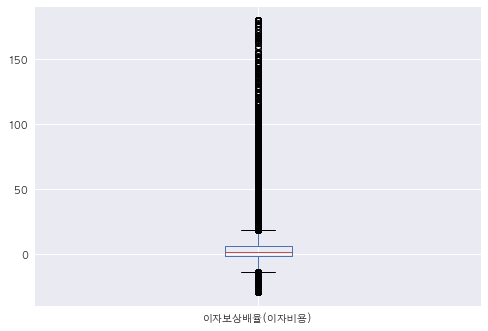

In [85]:
# 이상치 확인
import matplotlib.pyplot as plt
import warnings
import numpy as np
import matplotlib
%matplotlib inline

plt.style.use('seaborn')
warnings.simplefilter(action='ignore', category=FutureWarning)
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams["font.family"] = "AppleGothic"

df_이자보상배율[["이자보상배율(이자비용)"]].boxplot()
    
plt.show()

In [86]:
df_이자보상배율.sort_values(by="이자보상배율(이자비용)", ascending=False).head(5) # 최댓값 확인

회사명   거래소코드    회계년도  이자보상배율(이자비용)
9440     (주)시큐브  131090  2019.0        179.42
10590     (주)하츠  066130  2017.0        179.42
10670    (주)지씨셀  144510  2016.0        179.42
778     성보화학(주)  003080  2011.0        179.42
4785   라온시큐어(주)  042510  2017.0        179.42

In [87]:
df_이자보상배율.sort_values(by="이자보상배율(이자비용)", ascending=True).head(5) # 최솟값 확인

회사명   거래소코드    회계년도  이자보상배율(이자비용)
10063      (주)퓨전  195440  2017.0        -29.21
5714     (주)프리엠스  053160  2019.0        -29.21
4560   현대에이치티(주)  039010  2011.0        -29.21
4559   현대에이치티(주)  039010  2010.0        -29.21
5700     (주)소리바다  053110  2015.0        -29.21

### 3. Labeling

- 부실징후기업을 제거하기 위해서는 t-1, t-2년도의 이자보상배율 데이터가 필요하다. 그러나 2012~2019년에 상장한 기업의 경우 초기 2개년도에는 t-2년도 이자보상배율 데이터가 없기 때문에 이를 삭제시키면 정보 손실이 일어난다.
- 그러나 중간에 상장한 기업은 초기 2년 동안 한계기업이 될 수 없기 때문에, 모든 기업의 초기 2개 년도 t-1, t-2 이자보상배율 결측치 값을 1이상인 "2"로 대체 시켜 1이상인 기업으로 판단.

[예외의 경우]
- 각 기업의 2011~2019 사이의 데이터가 연속되지 않고 중간에 누락이 되어있다면 한계기업인지 확인하기 어려움.  

-> 중간에 데이터가 누락된 기업을 직접 확인!(2010데이터제외)

In [88]:
def func_yearnot2010(x):
    if x == 2010:
        return False
    else:
        return True
df_이자보상배율_test = df_이자보상배율[df_이자보상배율["회계년도"].map(func_yearnot2010)]
df_이자보상배율_test.sort_values(by=["거래소코드","회계년도"], axis=0, inplace=True, ascending=True)

/var/folders/x3/lny9bbwx64b561c29r4y4z400000gn/T/ipykernel_88610/735035177.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_이자보상배율_test.sort_values(by=["거래소코드","회계년도"], axis=0, inplace=True, ascending=True)


In [89]:
list_회계년도중간누락 = list()
list_code = list(df_이자보상배율_test["거래소코드"].unique())
for i in list_code:
    len_회계년도 = len(df_이자보상배율_test[df_이자보상배율_test["거래소코드"]==i])
    len_마지막년도첫년도차 = df_이자보상배율_test[df_이자보상배율_test["거래소코드"]==i]["회계년도"].iloc[-1] - df_이자보상배율_test[df_이자보상배율_test["거래소코드"]==i]["회계년도"].iloc[0] + 1
    if len_회계년도 != len_마지막년도첫년도차:
        list_회계년도중간누락.append(i)
list_회계년도중간누락

['004990', '011330', '118000']

In [90]:
df_이자보상배율[df_이자보상배율["거래소코드"]=="011330"]

회사명   거래소코드    회계년도  이자보상배율(이자비용)
2286  (주)유니켐  011330  2010.0          0.56
2287  (주)유니켐  011330  2011.0         -7.33
2288  (주)유니켐  011330  2012.0         -3.86
2289  (주)유니켐  011330  2013.0         -5.62
2290  (주)유니켐  011330  2016.0          2.00
2291  (주)유니켐  011330  2017.0          2.06
2292  (주)유니켐  011330  2018.0          6.86
2293  (주)유니켐  011330  2019.0         10.63

In [91]:
def func_company_filter3(x):
    if x in list_회계년도중간누락:
        return False
    else:
        return True
    
df_이자보상배율 = df_이자보상배율[df_이자보상배율["거래소코드"].map(func_company_filter3)] # 회계년도중간누락 되는 기업 확인

[labeling]  
2011~2019 사이에 상장한 기업은 (t-2),(t-1)년도 데이터를 알 수 없지만, 초기 2개년 동안은 한계기업이 될 수 없기에 데이터를 삭제하지 않는다.

In [92]:
df_이자보상배율_label = df_이자보상배율.copy()
list_companycode = list(df_이자보상배율_label["거래소코드"].unique())

dfs = list()
for i in list_companycode:
    #각 기업별로 데이터프레임 생성
    df_concat = df_이자보상배율_label[df_이자보상배율_label["거래소코드"]==i]
    # 연도 누락된거 생성하여 shift 문제없도록
    list_year_all = [2010,2011,2012,2013,2014,2015,2016,2017,2018,2019]
    list_year_real = list(df_concat["회계년도"].unique())
    for i in list_year_real:
        list_year_all.remove(i)
    df_year_all = pd.DataFrame({"회계년도":list_year_all})
    df_concat = pd.concat([df_concat,df_year_all])
    df_concat.sort_values(by="회계년도", inplace=True, ascending=True)
    
    df_concat["전년이자보상배율"] = df_concat["이자보상배율(이자비용)"].shift(1)
    dfs.append(df_concat)

df_이자보상배율_label = pd.concat(dfs)
df_이자보상배율_label.fillna(2) # 1이상인 2로 채워줌
df_이자보상배율_label.reset_index(drop=True, inplace=True)

In [93]:
list_companycode = list(df_이자보상배율_label["거래소코드"].unique())

dfs = list()
for i in list_companycode:
    #각 기업별로 데이터프레임 생성
    df_concat = df_이자보상배율_label[df_이자보상배율_label["거래소코드"]==i]
    # 연도 누락된거 생성하여 shift 문제없도록
    list_year_all = [2010,2011,2012,2013,2014,2015,2016,2017,2018,2019]
    list_year_real = list(df_concat["회계년도"].unique())
    for i in list_year_real:
        list_year_all.remove(i)
    df_year_all = pd.DataFrame({"회계년도":list_year_all})
    df_concat = pd.concat([df_concat,df_year_all])
    df_concat.sort_values(by="회계년도", inplace=True, ascending=True)
    
    df_concat["내년이자보상배율"] = df_concat["이자보상배율(이자비용)"].shift(-1)
    dfs.append(df_concat)

df_이자보상배율_label = pd.concat(dfs)
df_이자보상배율_label.dropna(inplace=True)
df_이자보상배율_label.reset_index(drop=True, inplace=True)

In [95]:
def func_updown1(x):
    if x >= 1:
        return True
    else:
        return False
    
df_이자보상배율_label["전년1미만"] = df_이자보상배율_label["전년이자보상배율"].map(func_updown1)
df_이자보상배율_label["올해1미만"] = df_이자보상배율_label["이자보상배율(이자비용)"].map(func_updown1)
df_이자보상배율_label["내년1미만"] = df_이자보상배율_label["내년이자보상배율"].map(func_updown1)

df_이자보상배율_label["부실징후여부"] = df_이자보상배율_label["전년1미만"]+df_이자보상배율_label["올해1미만"] # False & False인 것만 부실징후로
df_이자보상배율_label = df_이자보상배율_label[df_이자보상배율_label["부실징후여부"]==False]
df_이자보상배율_label.drop(["전년1미만","전년이자보상배율","내년이자보상배율"], axis=1, inplace=True)
df_이자보상배율_label.dropna(axis=0, inplace=True)
df_이자보상배율_label

/var/folders/x3/lny9bbwx64b561c29r4y4z400000gn/T/ipykernel_88610/438310337.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_이자보상배율_label.drop(["전년1미만","전년이자보상배율","내년이자보상배율"], axis=1, inplace=True)
/var/folders/x3/lny9bbwx64b561c29r4y4z400000gn/T/ipykernel_88610/438310337.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_이자보상배율_label.dropna(axis=0, inplace=True)


회사명   거래소코드    회계년도  이자보상배율(이자비용)  올해1미만  내년1미만  부실징후여부
2       케이알모터스(주)  000040  2013.0         -4.29  False  False   False
3       케이알모터스(주)  000040  2014.0         -4.60  False  False   False
4       케이알모터스(주)  000040  2015.0         -4.59  False  False   False
5       케이알모터스(주)  000040  2016.0         -2.26  False  False   False
6       케이알모터스(주)  000040  2017.0         -6.04  False  False   False
...           ...     ...     ...           ...    ...    ...     ...
8109  (주)얼라인드제네틱스  238120  2017.0        -29.21  False  False   False
8110  (주)얼라인드제네틱스  238120  2018.0        -29.21  False  False   False
8112       피씨엘(주)  241820  2018.0        -29.21  False  False   False
8113       (주)아스타  246720  2018.0        -22.95  False  False   False
8115       (주)모비스  250060  2018.0        -27.35  False  False   False

[2373 rows x 7 columns]

1. T/T, T/F는 뺴야함
2. F/T는 label=1
3. F/F는 label=0

In [96]:
df_이자보상배율_label_0 = df_이자보상배율_label[(df_이자보상배율_label["올해1미만"]==0)&(df_이자보상배율_label["내년1미만"]==0)]
df_이자보상배율_label_0["한계기업여부"] = 1
# df_이자보상배율_label_0
print(len(df_이자보상배율_label_0))

df_이자보상배율_label_1 = df_이자보상배율_label[(df_이자보상배율_label["올해1미만"]==0)&(df_이자보상배율_label["내년1미만"]==1)]
df_이자보상배율_label_1["한계기업여부"] = 0
# df_이자보상배율_label_1 
print(len(df_이자보상배율_label_1))

1790
583


/var/folders/x3/lny9bbwx64b561c29r4y4z400000gn/T/ipykernel_88610/1949664480.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_이자보상배율_label_0["한계기업여부"] = 1
/var/folders/x3/lny9bbwx64b561c29r4y4z400000gn/T/ipykernel_88610/1949664480.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_이자보상배율_label_1["한계기업여부"] = 0


In [97]:
df_이자보상배율_label = pd.concat([df_이자보상배율_label_0,df_이자보상배율_label_1], axis=0, ignore_index=True)
df_이자보상배율_label.sort_values(by=["거래소코드","회계년도"], ascending=True, inplace=True)
df_이자보상배율_label.reset_index(drop=True, inplace=True)

df_이자보상배율_label = df_이자보상배율_label[["회사명", "거래소코드", "회계년도", "한계기업여부", "이자보상배율(이자비용)"]]
df_이자보상배율_label.to_csv("./datasets/부실징후_라벨링.csv")
df_이자보상배율_label

회사명   거래소코드    회계년도  한계기업여부  이자보상배율(이자비용)
0       케이알모터스(주)  000040  2013.0       1         -4.29
1       케이알모터스(주)  000040  2014.0       1         -4.60
2       케이알모터스(주)  000040  2015.0       1         -4.59
3       케이알모터스(주)  000040  2016.0       1         -2.26
4       케이알모터스(주)  000040  2017.0       1         -6.04
...           ...     ...     ...     ...           ...
2368  (주)얼라인드제네틱스  238120  2017.0       1        -29.21
2369  (주)얼라인드제네틱스  238120  2018.0       1        -29.21
2370       피씨엘(주)  241820  2018.0       1        -29.21
2371       (주)아스타  246720  2018.0       1        -22.95
2372       (주)모비스  250060  2018.0       1        -27.35

[2373 rows x 5 columns]

In [98]:
print("전체 잠재 한계기업수 :",len(df_이자보상배율_label[df_이자보상배율_label["한계기업여부"]==True]["거래소코드"].unique()))
print("전체 잠재 회생기업수 :",len(df_이자보상배율_label[df_이자보상배율_label["한계기업여부"]==False]["거래소코드"].unique()))
print("2018 잠재 한계기업수 :",len(df_이자보상배율_label[(df_이자보상배율_label["회계년도"]==2018)&(df_이자보상배율_label["한계기업여부"]==True)]["거래소코드"].unique()))
print("2018 잠재 회생기업수 :",len(df_이자보상배율_label[(df_이자보상배율_label["회계년도"]==2018)&(df_이자보상배율_label["한계기업여부"]==False)]["거래소코드"].unique()))

전체 잠재 한계기업수 : 617
전체 잠재 회생기업수 : 528
2018 잠재 한계기업수 : 298
2018 잠재 회생기업수 : 86


In [99]:
# 각 년도 기업수
list_year = [2012, 2013,2014,2015,2016,2017,2018]
for i in list_year:
    print(str(i)+"년 : ", len(df_이자보상배율_label[df_이자보상배율_label["회계년도"]==i]["거래소코드"].unique()))

2012년 :  279
2013년 :  324
2014년 :  327
2015년 :  293
2016년 :  286
2017년 :  325
2018년 :  384


---
## Labeling Data & 재무데이터 통합 + 이상치 처리

### 1. 전년도 데이터 컬럼 생성
1) 전년도 대비 컬럼 생성을 위해
2) 증가율 컬럼 전처리
   - ~증가율 컬럼에 이상치 0이 존재.
   - 전년도데이터를 사용하여 직접 계산하기 위해 전년도 컬럼 생성

- 총자본증가율 : "자산(*)(요약)(백만원)
- 유형자산증가율 : '유형자산(요약)(백만원)'
- 비유동자산증가율 : "자산(*)(요약)(백만원)" - "유동자산(*)(요약)(백만원)"
- 재고자산증가율 : '재고자산(요약)(백만원)'
- 자기자본증가율 : '자본(*)(요약)(백만원)'
- 매출액증가율 : '매출액(수익)(요약)(백만원)'
- 순이익증가율 : '당기순이익(손실)(요약)(백만원)'
- 종업원수증가율 :  '종업원수'

In [ ]:
# 재무데이터 load
df_재무_통합 = pd.read_csv("./datasets/사업보고서_통합.csv", index_col=0)
df_재무_통합["거래소코드"] = df_재무_통합["거래소코드"].map(padding)
df_재무_통합 = df_재무_통합.drop(["회사명","이자보상배율(이자비용)"], axis=1)
# df_재무_통합

In [100]:
# 증가율컬럼에 0 떠서 전처리 해주는 컬럼
# df_재무_통합[df_재무_통합["총자본증가율"]==0][['총자본증가율', '유형자산증가율', '비유동자산증가율', '유동자산증가율', '재고자산증가율', '자기자본증가율', '매출액증가율', '순이익증가율','종업원수증가율']] # 결측치 있는 컬럼확인
list_col_lastyear1 = ['자본(*)(요약)(백만원)', '유형자산(요약)(백만원)', "자산(*)(요약)(백만원)", "유동자산(*)(요약)(백만원)", '재고자산(요약)(백만원)', '매출액(수익)(요약)(백만원)', '당기순이익(손실)(요약)(백만원)', '종업원수']
list_col_drop1 = ['총자본증가율', '유형자산증가율', '비유동자산증가율', '유동자산증가율', '재고자산증가율', '자기자본증가율', '매출액증가율', '순이익증가율','종업원수증가율']
df_재무_통합.drop(list_col_drop1, axis=1, inplace=True)

In [101]:
# 전년도 대비 증가율 컬럼
list_col_lastyear2 = ['배당성향', '투자활동으로인한현금흐름(*)(요약)(백만원)', '매출원가대매출액비율', '보통주배당금_현금(천원)', '장기금융부채(백만원)', "자본증가율_여부"]

df_재무_통합['장기금융부채(백만원)']=df_재무_통합['장기차입금(요약)(백만원)']+df_재무_통합['사채(요약)(백만원)']+df_재무_통합['장기매입채무및기타비유동채무(요약)(백만원)']
df_재무_통합['자산대비자본비율']=(df_재무_통합['자본(*)(요약)(백만원)']/df_재무_통합["자산(*)(요약)(백만원)"])*100

In [102]:
# 전년도 데이터가 필요한 컬럼 shift
list_companycode = list(df_재무_통합["거래소코드"].unique())

dfs = list()
for i in list_companycode:
    #각 기업별로 데이터프레임 생성
    df_concat = df_재무_통합[df_재무_통합["거래소코드"]==i]
    # 연도 누락된거 생성하여 shift 문제없도록
    list_year_all = [2010,2011,2012,2013,2014,2015,2016,2017,2018,2019]
    list_year_real = list(df_concat["회계년도"].unique())
    for i in list_year_real:
        list_year_all.remove(i)
    df_year_all = pd.DataFrame({"회계년도":list_year_all})
    df_concat = pd.concat([df_concat,df_year_all])
    df_concat.sort_values(by="회계년도", inplace=True, ascending=True)
    
    df_concat["자본(*)(요약)(백만원)_전년도"] = df_concat["자본(*)(요약)(백만원)"].shift(1)
    df_concat["유형자산(요약)(백만원)_전년도"] = df_concat["유형자산(요약)(백만원)"].shift(1)
    df_concat["자산(*)(요약)(백만원)_전년도"] = df_concat["자산(*)(요약)(백만원)"].shift(1)
    df_concat["유동자산(*)(요약)(백만원)_전년도"] = df_concat["유동자산(*)(요약)(백만원)"].shift(1)
    df_concat["재고자산(요약)(백만원)_전년도"] = df_concat["재고자산(요약)(백만원)"].shift(1)
    df_concat["당기순이익(손실)(요약)(백만원)_전년도"] = df_concat["당기순이익(손실)(요약)(백만원)"].shift(1)
    df_concat["종업원수_전년도"] = df_concat["종업원수"].shift(1)
    
    df_concat["투자활동으로인한현금흐름(*)(요약)(백만원)_전년도"] = df_concat["투자활동으로인한현금흐름(*)(요약)(백만원)"].shift(1)
    df_concat["배당금(총합)_현금(천원)_전년도"] = df_concat["배당금(총합)_현금(천원)"].shift(1)
    df_concat["자산대비자본비율_전년도"] = df_concat["자산대비자본비율"].shift(1)
    df_concat["장기금융부채(백만원)_전년도"] = df_concat["장기금융부채(백만원)"].shift(1)
    df_concat["자산(*)(요약)(백만원)_전년도"] = df_concat["자산(*)(요약)(백만원)"].shift(1)
    dfs.append(df_concat)

df_재무_통합 = pd.concat(dfs)
df_재무_통합.dropna(inplace=True)
df_재무_통합.reset_index(drop=True, inplace=True)
df_재무_통합.shape

(8638, 109)

In [103]:
df_재무_통합[df_재무_통합["거래소코드"]=="290660"] # 컬럼이 shift되어 전년도컬럼이 잘 생성되었음을 확인

거래소코드    회계년도  부가가치(백만원)  법인세비용차감전(계속사업)손익(백만원)  인건비(백만원)  금융비용(백만원)  \
8634  290660  2019.0    -1668.6              -16027.05  11390.92     878.71   

      감가상각비(백만원)  매출액총이익률  매출액순이익률  총자본사업이익률  ...  유형자산(요약)(백만원)_전년도  \
8634     1819.75    26.21  -128.95    -32.89  ...             4992.0   

      자산(*)(요약)(백만원)_전년도  유동자산(*)(요약)(백만원)_전년도  재고자산(요약)(백만원)_전년도  \
8634             35920.0               29301.0             2211.0   

      당기순이익(손실)(요약)(백만원)_전년도  종업원수_전년도  투자활동으로인한현금흐름(*)(요약)(백만원)_전년도  \
8634                 -9634.0      64.0                       -5060.0   

      배당금(총합)_현금(천원)_전년도  자산대비자본비율_전년도  장기금융부채(백만원)_전년도  
8634                 0.0     78.649777            274.0  

[1 rows x 109 columns]

### 2. 라벨링 데이터와 통합

In [104]:
df_부실징후 = pd.read_csv("./datasets/부실징후_라벨링.csv", index_col=0)
df_부실징후["거래소코드"] = df_부실징후["거래소코드"].map(padding)
len(df_부실징후["회사명"].unique())

805

In [105]:
# 라벨링 데이터 불러오기
df_부실징후 = pd.read_csv("./datasets/부실징후_라벨링.csv", index_col=0)
df_부실징후["거래소코드"] = df_부실징후["거래소코드"].map(padding)

# 라벨링데이터와 재무데이터 결합
df_부실징후 = pd.merge(df_부실징후,df_재무_통합, on=["거래소코드","회계년도"], how = 'left')

# 중복기업 제거
df_부실징후.dropna(inplace=True)
df_부실징후.sort_values(by=["거래소코드","회계년도"], inplace=True, ascending=True)
df_부실징후.drop_duplicates(['거래소코드'], keep='first', inplace=True)
df_부실징후.reset_index(drop=True, inplace=True)
df_부실징후

회사명   거래소코드    회계년도  한계기업여부  이자보상배율(이자비용)  부가가치(백만원)  \
0      케이알모터스(주)  000040  2013.0       1         -4.29    9379.15   
1      성창기업지주(주)  000180  2013.0       1         -1.39   28423.83   
2          디엘(주)  000210  2014.0       0         -3.33  494645.17   
3       일동홀딩스(주)  000230  2017.0       1          0.61   20134.11   
4       (주)대유플러스  000300  2012.0       0         -4.88   28096.06   
..           ...     ...     ...     ...           ...        ...   
779      (주)에이트원  230980  2018.0       1         -0.14   12878.02   
780  (주)얼라인드제네틱스  238120  2017.0       1        -29.21    2091.01   
781       피씨엘(주)  241820  2018.0       1        -29.21   -2639.11   
782       (주)아스타  246720  2018.0       1        -22.95    -929.19   
783       (주)모비스  250060  2018.0       1        -27.35    2070.53   

     법인세비용차감전(계속사업)손익(백만원)   인건비(백만원)  금융비용(백만원)  감가상각비(백만원)  ...  \
0                 -6614.45   11471.40     603.89     3494.34  ...   
1                 -2743.58   26305.23    1111.80     3750.38  ...   
2               -399132.20  730449.00   31419.37    79197.00  ...   
3                  -174.76   15539.49    1550.73     2502.66  ...   
4                -20808.00   24144.10    3110.15    11084.00  ...   
..                     ...        ...        ...         ...  ...   
779                -964.45    8872.93    4094.78      852.79  ...   
780               -1754.37    3290.81    -294.03      419.45  ...   
781               -5771.24    2557.81     -28.40      602.71  ...   
782               -3541.09    2194.05    -333.43      262.48  ...   
783                  -7.21    1833.33     -86.30      304.67  ...   

     유형자산(요약)(백만원)_전년도  자산(*)(요약)(백만원)_전년도  유동자산(*)(요약)(백만원)_전년도  \
0              55810.0            119327.0               61685.0   
1             219208.0            328454.0              101561.0   
2            1402234.0          10783047.0             6933026.0   
3              49462.0            204088.0               79510.0   
4             105879.0            605360.0              144700.0   
..                 ...                 ...                   ...   
779            15922.0             48118.0               24037.0   
780              451.0             25861.0               24351.0   
781             2953.0             15874.0               12804.0   
782             1003.0             23647.0               15266.0   
783              209.0             18035.0               12811.0   

     재고자산(요약)(백만원)_전년도  당기순이익(손실)(요약)(백만원)_전년도  종업원수_전년도  \
0              24763.0                 -8232.0     249.0   
1              29976.0                130666.0      78.0   
2            1036184.0                -10332.0    5456.0   
3               4934.0                266191.0      72.0   
4              21393.0                 -4626.0     389.0   
..                 ...                     ...       ...   
779            11738.0                   872.0      97.0   
780             1711.0                 -1556.0      57.0   
781                5.0                 -3869.0      35.0   
782             1482.0                 -4314.0      24.0   
783               39.0                 -2729.0      24.0   

     투자활동으로인한현금흐름(*)(요약)(백만원)_전년도  배당금(총합)_현금(천원)_전년도  자산대비자본비율_전년도  \
0                          -527.0                 0.0     50.949911   
1                        151698.0                 0.0     78.357396   
2                       -269731.0           4050000.0     45.166593   
3                        -42414.0           1046751.0     52.348987   
4                        -20302.0           1063000.0     14.996531   
..                            ...                 ...           ...   
779                      -14867.0                 0.0     21.594829   
780                      -12817.0                 0.0     93.511465   
781                       -7639.0                 0.0     97.247071   
782                      -13198.0                 0.0     61.014082   
783                       -1867.0   

### 3. inf값 확인(없음)

In [107]:
list(df_부실징후.select_dtypes(include="object").columns) # object columns 확인

['회사명', '거래소코드', '통계청한국표준산업분류10차(대분류)']

In [108]:
list_inf = list()
list_재무_columns = list(df_부실징후.columns)
# df_부실징후.select_dtypes(include="object")
list_재무_columns.remove("회사명")
list_재무_columns.remove("거래소코드")
list_재무_columns.remove("회계년도")
list_재무_columns.remove("통계청한국표준산업분류10차(대분류)")

# 1) inf값 있는 기업 리스트로 확인
for i in list_재무_columns:
    if len(df_부실징후[np.isinf(abs(df_부실징후[i]))]) > 0:
        list_inf.append(i)
list_inf

[]

### 4. 이상치 처리
- boxplot으로 이상치 확인

In [109]:
# 이상치 확인을 위한 boxplot 그리기 전 초기작업
import seaborn as sns
import matplotlib.pyplot as plt
import warnings
import numpy as np
import matplotlib

In [110]:
df_부실징후.shape

(784, 112)

In [ ]:
# df_부실징후_outlier = df_부실징후.drop(['회사명', '거래소코드', '회계년도', '통계청한국표준산업분류10차(대분류)'], axis=1)
# %matplotlib inline
# plt.style.use('seaborn')
# warnings.simplefilter(action='ignore', category=FutureWarning)
# plt.rcParams['axes.unicode_minus'] = False
# plt.rcParams["font.family"] = "AppleGothic"

# ncols = 3
# nrows = 38

# fig, axs = plt.subplots(nrows, ncols, constrained_layout=True)

# fig.set_size_inches((20, 200))

# for col, ax in zip(df_부실징후_outlier.columns, axs.T.ravel()):
#     df_부실징후_outlier[[col]].boxplot(ax=ax)
    
# plt.show()

<img width="1031" alt="image" src="https://user-images.githubusercontent.com/88031549/236765411-03437122-1517-49eb-ad9e-5d0ec755a876.png">

In [113]:
# boxplot을 확인하여 각 컬럼에 맞는 winsorizng 진행

list_2쩜5per = list(df_부실징후.columns)
list_0per = ["한계기업여부", "이자부담률", "순운전자본비율", "차입금의존도", "이자보상배율(이자비용)", "자기자본배당률","총자본회전률", "자기자본회전률", "타인자본회전률", "유동자산회전률", "당좌자산회전률", "총자본사업이익률", "총자본순이익률",
            "비유동자산회전률", "순운전자본회전률", "외국인_주식분포비율", "금융비용부담률", "자산대비자본비율", "기업순이익률", "인건비대총비용비율", "금융비용대총비용비율", "차입금평균이자율", "유동자산구성비율", "재고자산대유동자산비율", "자기자본구성비율", "타인자본구성비율",
            "자산대비자본비율_전년도", "사내유보율", "배당성향", "기타금융업부채(요약)(백만원)", '매출원가축소_여부']

list_0쩜5per = ["지급이자율", "자본금회전률", "매입채무회전률","매출액총이익률","매출액순이익률", "재고자산회전률", "매출채권회전률", "자기자본순이익률","경영자본순이익률", "유형자산회전율", "자본금순이익률","매출원가대매출액비율", "운전자본회전률", "영업비용대영업수익비율",
            "종업원수","사내유보대자기자본비율", "평균배당률", "차입금비율", "금융손익비율", "유보율", "유동자산대비유동자산비율", "종업원수_전년도", "자기자본배율", "유동비율", "현금비율",  "배당금지급(-)(요약)(백만원)", "우선주배당금_현금(천원)", '매출액대매출원가비율', '매출액대매출원가비율_전년도',]
for i in list_0per:
    list_2쩜5per.remove(i)
for i in list_0쩜5per:
    list_2쩜5per.remove(i)
list_2쩜5per.remove("회사명")
list_2쩜5per.remove("거래소코드")
list_2쩜5per.remove("회계년도")
list_2쩜5per.remove("통계청한국표준산업분류10차(대분류)")

In [114]:
# 상하위 0.5%, 2.5% 이상치 대체
from scipy.stats.mstats import winsorize
for i in list_0쩜5per:
    df_부실징후[i]= winsorize(df_부실징후[i], limits=[0.025, 0.025])
for i in list_2쩜5per:
    df_부실징후[i]= winsorize(df_부실징후[i], limits=[0.025, 0.025])

In [ ]:
# df_부실징후_outlier = df_부실징후.drop(['회사명', '거래소코드', '회계년도', '통계청한국표준산업분류10차(대분류)'], axis=1)
# %matplotlib inline
# plt.style.use('seaborn')
# warnings.simplefilter(action='ignore', category=FutureWarning)
# plt.rcParams['axes.unicode_minus'] = False
# plt.rcParams["font.family"] = "AppleGothic"

# ncols = 3
# nrows = 38

# fig, axs = plt.subplots(nrows, ncols, constrained_layout=True)

# fig.set_size_inches((20, 200))

# for col, ax in zip(df_부실징후_outlier.columns, axs.T.ravel()):
#     df_부실징후_outlier[[col]].boxplot(ax=ax)
    
# plt.show()


<img width="1032" alt="image" src="https://user-images.githubusercontent.com/88031549/236766042-d44c3c43-6c31-4bad-87ed-127a7cdecb3c.png">

#### “사내유보율”, “배당성향” 이상치 확인
- 사내유보율은 100또는 0이라 "사내유보금보유_여부"컬럼으로 반정형데이터 생성

<AxesSubplot: xlabel='사내유보율'>

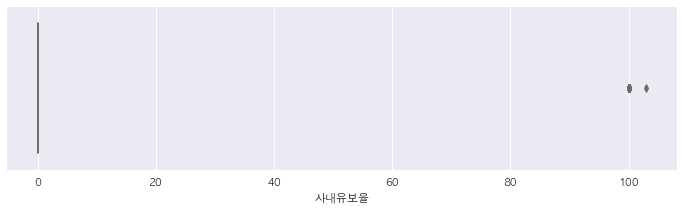

In [120]:
# 이상치 확인
import matplotlib.pyplot as plt
import seaborn as sns
target = "사내유보율"

plt.figure(figsize=(12,3))
sns.boxplot(x=target, data=df_부실징후, palette="Set3")
# sns.swarmplot(data=df_이자보상배율, x=target)

배당성향이 100%가 넘는 데이터 존재  
-> 직접 확인한 결과 당기순이익이 배당금보다 작은데, 배당을 많이하면 배당성향이 말도안되게 높게 나옴

![12](https://user-images.githubusercontent.com/88031549/208833134-8d4ec411-008b-47c1-8a45-12cb213dfc83.png)

<AxesSubplot: xlabel='배당성향'>

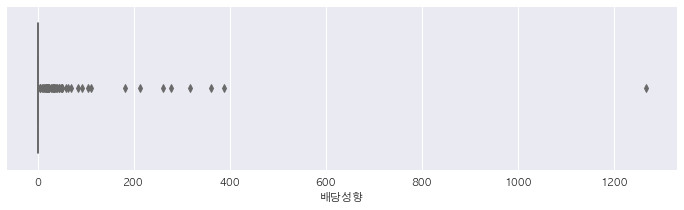

In [121]:
# 이상치 확인
import matplotlib.pyplot as plt
import seaborn as sns
target = "배당성향"

plt.figure(figsize=(12,3))
sns.boxplot(x=target, data=df_부실징후, palette="Set3")
# sns.swarmplot(data=df_이자보상배율, x=target)

In [123]:
df_부실징후[df_부실징후["배당성향"]>100][["회사명","거래소코드","회계년도","배당성향"]].sort_values(by="배당성향", ascending=False).head(5)

회사명   거래소코드    회계년도     배당성향
90     한일사료(주)  005860  2018.0  1268.36
244  (주)제이에스티나  026040  2018.0   388.49
125    대동기어(주)  008830  2013.0   360.91
3     일동홀딩스(주)  000230  2017.0   318.44
286    세종공업(주)  033530  2018.0   278.35

In [124]:
# 상하위 2.5% 이상치 대체
from scipy.stats.mstats import winsorize
df_부실징후["배당성향"]= winsorize(df_부실징후["배당성향"], limits=[0.025, 0.025])

<AxesSubplot: xlabel='배당성향'>

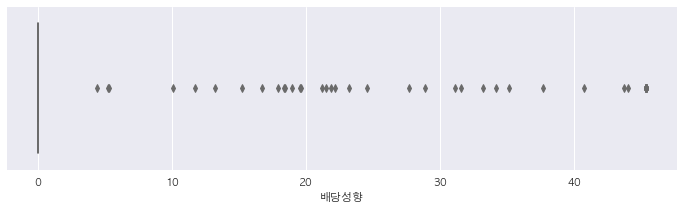

In [125]:
# 이상치 확인
import matplotlib.pyplot as plt
import seaborn as sns
target = "배당성향"

plt.figure(figsize=(12,3))
sns.boxplot(x=target, data=df_부실징후, palette="Set3")
# sns.swarmplot(data=df_이자보상배율, x=target)

---
# 파생변수 생성

In [126]:
df_부실징후_파생변수 = df_부실징후.copy()
print("row 수 :", df_부실징후_파생변수.shape[0])
df_부실징후_파생변수.head(3)

row 수 : 784


회사명   거래소코드    회계년도  한계기업여부  이자보상배율(이자비용)  부가가치(백만원)  \
0  케이알모터스(주)  000040  2013.0       1         -4.29    9379.15   
1  성창기업지주(주)  000180  2013.0       1         -1.39   28423.83   
2      디엘(주)  000210  2014.0       0         -3.33  494645.17   

   법인세비용차감전(계속사업)손익(백만원)   인건비(백만원)  금융비용(백만원)  감가상각비(백만원)  ...  \
0               -6614.45   11471.40     603.89     3494.34  ...   
1               -2743.58   26305.23    1111.80     3750.38  ...   
2             -250371.85  325771.45   31419.37    79197.00  ...   

   유형자산(요약)(백만원)_전년도  자산(*)(요약)(백만원)_전년도  유동자산(*)(요약)(백만원)_전년도  \
0            55810.0            119327.0               61685.0   
1           219208.0            328454.0              101561.0   
2          1402234.0           5310310.0             2144305.0   

   재고자산(요약)(백만원)_전년도  당기순이익(손실)(요약)(백만원)_전년도  종업원수_전년도  \
0            24763.0                 -8232.0     249.0   
1            29976.0                 13091.0      78.0   
2           389965.0                -10332.0    2849.0   

   투자활동으로인한현금흐름(*)(요약)(백만원)_전년도  배당금(총합)_현금(천원)_전년도  자산대비자본비율_전년도  \
0                        -527.0                 0.0     50.949911   
1                       24710.0                 0.0     78.357396   
2                     -244402.0           4050000.0     45.166593   

   장기금융부채(백만원)_전년도  
0            408.0  
1          16043.0  
2        1155487.0  

[3 rows x 112 columns]

### 1. 증가율컬럼 생성
- 총자본증가율 : "자산(*)(요약)(백만원)
- 유형자산증가율 : '유형자산(요약)(백만원)'
- 비유동자산증가율 : "자산(*)(요약)(백만원)" - "유동자산(*)(요약)(백만원)"
- 재고자산증가율 : '재고자산(요약)(백만원)'
- 자기자본증가율 : '자본(*)(요약)(백만원)'
- 매출액증가율 : '매출액(수익)(요약)(백만원)'
- 순이익증가율 : '당기순이익(손실)(요약)(백만원)'
- 종업원수증가율 :  '종업원수'

In [127]:
df_부실징후_파생변수['총자본증가율'] = (df_부실징후_파생변수['자산(*)(요약)(백만원)'] - df_부실징후_파생변수['자산(*)(요약)(백만원)_전년도'] ) / df_부실징후_파생변수['자산(*)(요약)(백만원)_전년도'] *100
df_부실징후_파생변수['유형자산증가율'] = (df_부실징후_파생변수['유형자산(요약)(백만원)'] - df_부실징후_파생변수['유형자산(요약)(백만원)_전년도'] ) / df_부실징후_파생변수['유형자산(요약)(백만원)_전년도'] *100
df_부실징후_파생변수['비유동자산(백만원)'] = (df_부실징후_파생변수['자산(*)(요약)(백만원)'] - df_부실징후_파생변수['유동자산(*)(요약)(백만원)'] ) 
df_부실징후_파생변수['비유동자산(백만원)_전년도'] = (df_부실징후_파생변수['자산(*)(요약)(백만원)_전년도'] - df_부실징후_파생변수['유형자산(요약)(백만원)_전년도'] ) 
df_부실징후_파생변수['비유동자산증가율'] = (df_부실징후_파생변수['비유동자산(백만원)']-df_부실징후_파생변수['비유동자산(백만원)_전년도']) / df_부실징후_파생변수['비유동자산(백만원)_전년도'] * 100
# df_부실징후_파생변수['재고자산증가율'] = (df_부실징후_파생변수['재고자산(요약)(백만원)'] - df_부실징후_파생변수['재고자산(요약)(백만원)_전년도'] ) / df_부실징후_파생변수['재고자산(요약)(백만원)_전년도'] *100 # 자본증가율 계산에 사용됨. 그러나 자본증가율이 inf값이 많아 drop
df_부실징후_파생변수['자기자본증가율'] = (df_부실징후_파생변수['자본(*)(요약)(백만원)'] - df_부실징후_파생변수['자본(*)(요약)(백만원)_전년도'] ) / df_부실징후_파생변수['자본(*)(요약)(백만원)_전년도'] *100
df_부실징후_파생변수['매출액증가율'] = (df_부실징후_파생변수['매출액(수익)(요약)(백만원)'] - df_부실징후_파생변수['매출액(수익)(요약)(백만원)_전년도'] ) / df_부실징후_파생변수['매출액(수익)(요약)(백만원)_전년도'] *100
# df_부실징후_파생변수['순이익증가율'] = (df_부실징후_파생변수['당기순이익(손실)(요약)(백만원)'] - df_부실징후_파생변수['당기순이익(손실)(요약)(백만원)_전년도'] ) / df_부실징후_파생변수['당기순이익(손실)(요약)(백만원)_전년도'] *100
df_부실징후_파생변수['종업원수증가율'] = (df_부실징후_파생변수['종업원수'] - df_부실징후_파생변수['종업원수_전년도'] ) / df_부실징후_파생변수['종업원수_전년도'] *100

결측치 확인(없음)

In [ ]:
# df_부실징후_파생변수.isna().sum().to_dict()
df_부실징후_파생변수.dropna(inplace=True)
df_부실징후_파생변수.reset_index(drop=True, inplace=True)

### 2. 반정형데이터 생성

In [130]:
df_부실징후_파생변수["투자활동현금흐름증감률"] = (df_부실징후_파생변수['투자활동으로인한현금흐름(*)(요약)(백만원)'] - df_부실징후_파생변수['투자활동으로인한현금흐름(*)(요약)(백만원)_전년도'])/df_부실징후_파생변수['투자활동으로인한현금흐름(*)(요약)(백만원)_전년도']*100
df_부실징후_파생변수["직원증감률"] = (df_부실징후_파생변수['종업원수'] - df_부실징후_파생변수['종업원수_전년도'])/df_부실징후_파생변수['종업원수_전년도']*100
# df_부실징후_파생변수['배당금증감률']=(df_부실징후_파생변수['배당금(총합)_현금(천원)'] - df_부실징후_파생변수['배당금(총합)_현금(천원)_전년도'])/df_부실징후_파생변수['배당금(총합)_현금(천원)_전년도']*100
# df_부실징후_파생변수['배당금증감률'] = df_부실징후_파생변수['배당금증감률'].fillna(0)
df_부실징후_파생변수['자본증가률']=(df_부실징후_파생변수['자산대비자본비율'] - df_부실징후_파생변수['자산대비자본비율_전년도'])/df_부실징후_파생변수['자산대비자본비율_전년도']*100
# df_부실징후_파생변수['장기금융부채증감률']=(df_부실징후_파생변수['장기금융부채(백만원)'] - df_부실징후_파생변수['장기금융부채(백만원)_전년도'])/df_부실징후_파생변수['장기금융부채(백만원)_전년도']*100 # inf 많아서 drop
# df_부실징후_파생변수['자본증가율']=df_부실징후_파생변수['자산(*)(요약)(백만원)'] /df_부실징후_파생변수['장기금융부채(백만원)']*100 # inf 많아서 drop
df_부실징후_파생변수['차입']=df_부실징후_파생변수['장기금융부채(백만원)']/df_부실징후_파생변수['자산(*)(요약)(백만원)']*100
df_부실징후_파생변수["자산대비_장기금융부채비율"] = df_부실징후_파생변수["장기금융부채(백만원)"]/df_부실징후_파생변수['자산(*)(요약)(백만원)']
# df_부실징후_파생변수["자산대비_장기금융부채비율_전년도"] = df_부실징후_파생변수["장기금융부채(백만원)_전년도"]/df_부실징후_파생변수['자산(*)(요약)(백만원)_전년도']
# df_부실징후_파생변수["자산대비_장기금융부채비율_증가율"] = df_부실징후_파생변수["자산대비_장기금융부채비율"]/df_부실징후_파생변수['자산대비_장기금융부채비율_전년도']

- # 분모가 0일경우 NA값이 된다.
- #### 결측치 있는 컬럼 : '배당금증감률', '장기금융부채증감률', '자산대비_장기금융부채비율_증가율'
- #### 전년도 0에서 올해 0이 되면 0으로
- #### 전년도 0에서 올해 0이상이되면 drop
- #### inf값이 많은건 drop

In [132]:
# df_부실징후_정상 = df_부실징후_파생변수[((df_부실징후_파생변수["배당금(총합)_현금(천원)"]==0)&(df_부실징후_파생변수["배당금(총합)_현금(천원)_전년도"]==0)&(df_부실징후_파생변수["배당금(총합)_현금(천원)_전년도"]==0)).map(func_not)]
# df_부실징후_결측 = df_부실징후_파생변수[(df_부실징후_파생변수["배당금(총합)_현금(천원)"]==0)&(df_부실징후_파생변수["배당금(총합)_현금(천원)_전년도"]==0)&(df_부실징후_파생변수["배당금(총합)_현금(천원)_전년도"]==0)]
# df_부실징후_결측["배당금증감률"]=0
# df_부실징후_파생변수 = pd.concat([df_부실징후_정상, df_부실징후_결측], axis=0)
# print("row drop 수 : ", df_부실징후_파생변수[df_부실징후_파생변수["배당금증감률"].isna()].shape[0])
# df_부실징후_파생변수 = df_부실징후_파생변수[df_부실징후_파생변수["배당금증감률"].isna().map(func_not)]
# df_부실징후_파생변수.reset_index(drop=True, inplace=True)

In [133]:
# df_부실징후_정상 = df_부실징후_파생변수[((df_부실징후_파생변수["장기금융부채(백만원)"]==0)&(df_부실징후_파생변수["장기금융부채(백만원)_전년도"]==0)).map(func_not)]
# df_부실징후_결측 = df_부실징후_파생변수[(df_부실징후_파생변수["장기금융부채(백만원)"]==0)&(df_부실징후_파생변수["장기금융부채(백만원)_전년도"]==0)]
# df_부실징후_결측["장기금융부채증감률"]=0
# df_부실징후_파생변수 = pd.concat([df_부실징후_정상, df_부실징후_결측], axis=0)
# print("row drop 수 : ", df_부실징후_파생변수[df_부실징후_파생변수["장기금융부채증감률"].isna()].shape[0])
# df_부실징후_파생변수 = df_부실징후_파생변수[df_부실징후_파생변수["장기금융부채증감률"].isna().map(func_not)]
# df_부실징후_파생변수.reset_index(drop=True, inplace=True)

In [134]:
# df_부실징후_정상 = df_부실징후_파생변수[((df_부실징후_파생변수["자산대비_장기금융부채비율"]==0)&(df_부실징후_파생변수["자산대비_장기금융부채비율_전년도"]==0)).map(func_not)]
# df_부실징후_결측 = df_부실징후_파생변수[(df_부실징후_파생변수["자산대비_장기금융부채비율"]==0)&(df_부실징후_파생변수["자산대비_장기금융부채비율_전년도"]==0)]
# df_부실징후_결측["자산대비_장기금융부채비율_증가율"]=0
# df_부실징후_파생변수 = pd.concat([df_부실징후_정상, df_부실징후_결측], axis=0)
# print("row drop 수 : ", df_부실징후_파생변수[df_부실징후_파생변수["자산대비_장기금융부채비율_증가율"].isna()].shape[0])
# df_부실징후_파생변수 = df_부실징후_파생변수[df_부실징후_파생변수["자산대비_장기금융부채비율_증가율"].isna().map(func_not)]
# df_부실징후_파생변수.reset_index(drop=True, inplace=True)

In [135]:
df_부실징후_파생변수.shape[0]

784

In [137]:
#투자활동현금흐름증감률_label t－1기 대비 15% 이상 감소한 경우 0, 아닐 경우 1
def func1_TF(x):
    if (x <= -15) :
        return 1
    else:
        return 0

#직원증감률_label t－1기 대비 20%이상 줄어든 경우 0, 아닐 경우1
def func2_TF(x):
    if (x <= -20) :
        return 1
    else:
        return 0    

def func3_TF(x):
    if x==0:
        return 0
    else:
        return 1

# 자산매각_label 고정자산(비유동자산)이 15% 이상 줄어드는 경우0, 아닐 경우 1   
def func4_TF(x):
    if (x <= -15):
        return 1
    else:
        return 0

# 배당금증감률_label
def func5_TF(x):
    if (x <= -25):
        return 1
    else:
        return 0     

# 증자증감률_label 증자를 통한 재무적 범주 구조조정 더미변수, t기 또는 t＋1기의 (자본/총자산)의 증가가 5% 이상인 경우 0, 아닐 경우 1  
# 차입_label (현금흐름표상 장기금융부채의 증가치/총자산)의 증가치가 5% 이상인 경우 0 아닐 경우 1   
def func6_TF(x):
    if (x >=5):
        return 1
    else:
        return 0        

def func7_TF(x):
    if x==0:
        return 0
    else:
        return 1

In [138]:
df_부실징후_파생변수['투자축소_여부']=df_부실징후_파생변수['투자활동현금흐름증감률'].map(func1_TF)
df_부실징후_파생변수['직원증감률_여부']=df_부실징후_파생변수['종업원수증가율'].map(func2_TF)
df_부실징후_파생변수['사내유보금보유_여부']=df_부실징후_파생변수['사내유보율'].map(func3_TF)
df_부실징후_파생변수['자산매각_여부']=df_부실징후_파생변수['비유동자산증가율'].map(func4_TF)
# df_부실징후_파생변수['배당금축소_여부']=df_부실징후_파생변수['배당금증감률'].map(func5_TF)
df_부실징후_파생변수['자본증가율_여부']=df_부실징후_파생변수['자본증가률'].map(func6_TF)
df_부실징후_파생변수['차입_여부']=df_부실징후_파생변수['차입'].map(func6_TF)
# df_부실징후_파생변수["자산대비_장기금융부채비율_증가율"]=df_부실징후_파생변수["자산대비_장기금융부채비율_증가율"].map(func6_TF) # 자산대비_장기금융부채비율_증가율에 inf가 많아 drop

In [139]:
df_부실징후_파생변수["운용적범주전략(OPS)변수"] = df_부실징후_파생변수['투자축소_여부']+df_부실징후_파생변수["매출원가축소_여부"]+df_부실징후_파생변수['직원증감률_여부']
# df_부실징후_파생변수["재무적범주전략(FIN)변수"] = df_부실징후_파생변수['자산매각_여부']+df_부실징후_파생변수["배당금축소_여부"]+df_부실징후_파생변수['차입_여부']+df_부실징후_파생변수['자본증가율_여부'] # 배당금증감률에 inf가 많아 drop
df_부실징후_파생변수["운용적범주전략(OPS)변수"] = df_부실징후_파생변수["운용적범주전략(OPS)변수"].map(func7_TF)
# df_부실징후_파생변수["재무적범주전략(FIN)변수"] = df_부실징후_파생변수["재무적범주전략(FIN)변수"].map(func7_TF)

### 3. 논문기반_재무적 제약수준 측정방법을 참고한 컬럼 생성(+NCAV)

In [140]:
df_부실징후_파생변수['배당금합산(천원)'] = df_부실징후_파생변수['보통주배당금_현금(천원)'] + df_부실징후_파생변수['우선주배당금_현금(천원)']
df_부실징후_파생변수['총자산자연로그']=''

In [141]:
# 배당금 지급하면 1을 가지는 더미변수 -> WW지수를 위해

def func_배당금여부(x):
  if x==0:
    return 0
  else:
    return 1

In [ ]:
# 총자산에 자연로그를 취한값 -> WW지수를 위해
from numpy import log as ln
for i in range(len(df_부실징후_파생변수)):
  df_부실징후_파생변수['총자산자연로그'][i] = ln(df_부실징후_파생변수['자산(*)(요약)(백만원)'][i])

def func_float(x):
  return float(x)
df_부실징후_파생변수['총자산자연로그'] = df_부실징후_파생변수['총자산자연로그'].map(func_float)

In [143]:
df_부실징후_파생변수['배당금지급_여부']=df_부실징후_파생변수['배당금합산(천원)'].map(func_배당금여부)
df_부실징후_파생변수.drop(columns = ['배당금합산(천원)'], inplace=True)

#### 1) LEV지수

In [145]:
# LEV지수 = 장기차입금 / (총자산 - 자본금 + 시가총액)
df_부실징후_파생변수['LEV지수'] = df_부실징후_파생변수['장기차입금(요약)(백만원)']*1000000 / (df_부실징후_파생변수['자산(*)(요약)(백만원)']*1000000 - df_부실징후_파생변수['자본(*)(요약)(백만원)']*1000000 + df_부실징후_파생변수['시가총액'])

#### 2) KZ지수

In [146]:
# 순자산가치(자기자본) = 1주당 순자산 * 발행주식수 
# 타인자본 + 자기자본 (부채 + 자본) 
# 순자산가치 = 자기자본 = 자산 - 부채
df_부실징후_파생변수["순자산가치(백만원)"] = df_부실징후_파생변수['자산(*)(요약)(백만원)'] - df_부실징후_파생변수['부채(*)(요약)(백만원)']

In [147]:
df_부실징후_파생변수.select_dtypes(include="object")

회사명   거래소코드 통계청한국표준산업분류10차(대분류)
0      케이알모터스(주)  000040                 제조업
1      성창기업지주(주)  000180    전문, 과학 및 기술 서비스업
2          디엘(주)  000210    전문, 과학 및 기술 서비스업
3       일동홀딩스(주)  000230                 제조업
4       (주)대유플러스  000300                 제조업
..           ...     ...                 ...
779      (주)에이트원  230980               정보통신업
780  (주)얼라인드제네틱스  238120                 제조업
781       피씨엘(주)  241820                 제조업
782       (주)아스타  246720                 제조업
783       (주)모비스  250060               정보통신업

[784 rows x 3 columns]

In [148]:
# 단위 통일 시켜줘야할듯 어떤건 백만원 어떤건 천원이럼 (단위통일 필수 !!!! )
# 자산(*)(요약) -> (*) 총이라는 뜻인듯!
# KZ지수 = = -1.002 * (당기순이익 + 감가상각비) + 0.28 (시가총액 + 순자산가치)/(장기차입금 + 자본)+3.139 * (장기차입금/장기차입금+자본금) - 39.368(보통주배당금+우선주배당금/총자산)-1.315(현금과 현금성자산/총자산) 
df_부실징후_파생변수['KZ지수'] = -1.002 * (df_부실징후_파생변수['당기순이익(손실)(요약)(백만원)']*1000000 + df_부실징후_파생변수['감가상각비(백만원)']*1000000) + 0.28* (df_부실징후_파생변수['시가총액'] + df_부실징후_파생변수["순자산가치(백만원)"]*1000000) / (df_부실징후_파생변수['장기차입금(요약)(백만원)']*1000000+df_부실징후_파생변수['자산(*)(요약)(백만원)']*1000000) + 3.139 *(df_부실징후_파생변수['장기차입금(요약)(백만원)']*1000000/(df_부실징후_파생변수['장기차입금(요약)(백만원)']*1000000+df_부실징후_파생변수['자산(*)(요약)(백만원)']*1000000)) - 39.368 * ( (df_부실징후_파생변수['보통주배당금_현금(천원)']*1000 +df_부실징후_파생변수['우선주배당금_현금(천원)']*1000)/df_부실징후_파생변수['자산(*)(요약)(백만원)']*1000000) -1.315*(df_부실징후_파생변수['현금및현금성자산(요약)(백만원)']*1000000/df_부실징후_파생변수['자산(*)(요약)(백만원)']*1000000)

#### 3) WW지수

In [149]:
df_산업매출성장률 = pd.read_excel("./datasets/raw/산업별_매출액증가율.xlsx", index_col=0)
df_산업매출성장률 = df_산업매출성장률[["회사명", "년도", "매출액증가율(계산)"]]
df_산업매출성장률.rename(columns={"회사명":'통계청한국표준산업분류10차(대분류)',"년도":"회계년도", "매출액증가율(계산)":"산업매출성장률"}, inplace=True)
df_산업매출성장률.dropna(axis=0, inplace=True)
df_산업매출성장률

통계청한국표준산업분류10차(대분류)  회계년도    산업매출성장률
1                   건설업  2012   5.213873
2                   건설업  2013   0.779270
3                   건설업  2014   0.855995
4                   건설업  2015   6.295117
5                   건설업  2016   1.856492
..                  ...   ...        ...
129                 제조업  2015  -0.947473
130                 제조업  2016   0.061381
131                 제조업  2017   7.191381
132                 제조업  2018   2.340424
133                 제조업  2019  10.120578

[115 rows x 3 columns]

In [150]:
df_부실징후_파생변수.shape

(784, 137)

In [151]:
df_부실징후_파생변수 = pd.merge(df_부실징후_파생변수, df_산업매출성장률, on=["통계청한국표준산업분류10차(대분류)","회계년도"], how = 'left')
print(df_부실징후_파생변수["산업매출성장률"].isna().sum())
df_부실징후_파생변수.dropna(axis=0, inplace=True)
df_부실징후_파생변수.reset_index(drop=True, inplace=True)

3


In [152]:
# WW지수 = -0.091(현금흐름 / 총자산) - 0.062*(배당금을 지급하면 1을 가지는 더미변수) +0.021 * (장기차입금/총자산) - 0.044 * (총자산에 자연로그를 취한값) + 0.102 * (기업이 속한 산업의 매출성장률)+0.035 * (기업의 매출성장률)
# 현금흐름은 영업에서 창출된 현금흐름
df_부실징후_파생변수['WW지수'] = -0.091 * (df_부실징후_파생변수['영업활동으로인한현금흐름(간접법)(*)(요약)(백만원)']*1000000/df_부실징후_파생변수['자산(*)(요약)(백만원)']*1000000) - 0.062 * df_부실징후_파생변수['배당금(총합)_현금(천원)']*1000 + 0.021*(df_부실징후_파생변수['장기차입금(요약)(백만원)']*1000000/df_부실징후_파생변수['자산(*)(요약)(백만원)']*1000000) - 0.044 * df_부실징후_파생변수['총자산자연로그'] + 0.102 * df_부실징후_파생변수["산업매출성장률"] + 0.035 * df_부실징후_파생변수['매출액증가율']

#### 4) CL지수

In [153]:
# # CL지수(FCCL) = = 0.0432 * (유동자산 / 유동부채) - 0.0011 * [(법인세비용차감전순이익-이자비용)/(이자비용+우선주배당금)] + 0.0039 * [(현금+0.5재고자산 +0.7매출채권-단기차입금)/유형자산]-3.3525*(당기순이익 / 총매출) -0.5723 * (매출성장률=매출액증가율) +0.6067 *(장기차입금/총자산)
# df_부실징후_파생변수['CL지수'] = 0.0432 * (df_부실징후_파생변수['유동자산(*)(요약)(백만원)']*1000000/df_부실징후_파생변수['유동부채(*)(요약)(백만원)']*1000000) - 0.0011*((df_부실징후_파생변수['법인세비용차감전순이익(손실)(요약)(백만원)']*1000000 -df_부실징후_파생변수['*이자비용(요약)(백만원)']*1000000)/(df_부실징후_파생변수['*이자비용(요약)(백만원)']*1000000+df_부실징후_파생변수['우선주배당금_현금(천원)']*1000)) + 0.0039 *((df_부실징후_파생변수['현금및현금성자산(요약)(백만원)']*1000000+0.5*df_부실징후_파생변수['재고자산(요약)(백만원)']*1000000+0.7*df_부실징후_파생변수['매출채권및기타유동채권(요약)(백만원)']*1000000-df_부실징후_파생변수['단기차입금(요약)(백만원)']*1000000)/df_부실징후_파생변수['유형자산(요약)(백만원)']*1000000)-3.3525*(df_부실징후_파생변수['당기순이익(손실)(요약)(백만원)']*1000000/df_부실징후_파생변수['매출액(수익)(요약)(백만원)']*1000000) -0.5723 * df_부실징후_파생변수['매출액증가율'] +0.6067*(df_부실징후_파생변수['장기차입금(요약)(백만원)']*1000000/df_부실징후_파생변수['자산(*)(요약)(백만원)']*1000000)

#### 5) NCAV지수

In [154]:
# - 파생변수 NCAV (유동자산-부채총계)/시가총액 
df_부실징후_파생변수["NCAV지수"] = ((df_부실징후_파생변수['유동자산(*)(요약)(백만원)']*1000000) - (df_부실징후_파생변수['부채(*)(요약)(백만원)']*1000000)) / df_부실징후_파생변수['시가총액']

In [155]:
list_inf = list()
list_재무_columns = list(df_부실징후_파생변수.columns)
# df_부실징후_파생변수.select_dtypes(include="object")
list_재무_columns.remove("회사명")
list_재무_columns.remove("거래소코드")
list_재무_columns.remove("회계년도")
list_재무_columns.remove("통계청한국표준산업분류10차(대분류)")

# 1) inf값 있는 기업 리스트로 확인
for i in list_재무_columns:
    if len(df_부실징후_파생변수[np.isinf(abs(df_부실징후_파생변수[i]))]) > 0:
        list_inf.append(i)
list_inf


## inf있는 컬럼 다 지워

[]

In [156]:
df_부실징후_파생변수.shape

(781, 140)

### 4. 기업생명주기
- '영업활동으로인한현금흐름(간접법)(*)(요약)(백만원)' / '투자활동으로인한현금흐름(*)(요약)(백만원)' / '재무활동으로인한현금흐름(*)(요약)(백만원)'
- 도입기 : 0
- 성장기 : 1
- 성숙기 : 2
- 쇄신기 : 3
- 쇠퇴기 : 4

In [163]:
def func_lifecycle(x):
    if x >= 0:
        return True
    else:
        return False

df_부실징후_파생변수["영업흐름_플마_영업"] = df_부실징후_파생변수['영업활동으로인한현금흐름(간접법)(*)(요약)(백만원)'].map(func_lifecycle)
df_부실징후_파생변수["영업흐름_플마_투자"] = df_부실징후_파생변수['투자활동으로인한현금흐름(*)(요약)(백만원)'].map(func_lifecycle)
df_부실징후_파생변수["영업흐름_플마_재무"] = df_부실징후_파생변수['재무활동으로인한현금흐름(*)(요약)(백만원)'].map(func_lifecycle)

In [ ]:
df_부실징후_도입기 = df_부실징후_파생변수[(df_부실징후_파생변수["영업흐름_플마_영업"]==False)&(df_부실징후_파생변수["영업흐름_플마_투자"]==False)&(df_부실징후_파생변수["영업흐름_플마_재무"]==True)]
df_부실징후_성장기 = df_부실징후_파생변수[(df_부실징후_파생변수["영업흐름_플마_영업"]==True)&(df_부실징후_파생변수["영업흐름_플마_투자"]==False)&(df_부실징후_파생변수["영업흐름_플마_재무"]==True)]
df_부실징후_성숙기 = df_부실징후_파생변수[(df_부실징후_파생변수["영업흐름_플마_영업"]==True)&(df_부실징후_파생변수["영업흐름_플마_투자"]==False)&(df_부실징후_파생변수["영업흐름_플마_재무"]==False)]
df_부실징후_쇄신기 = df_부실징후_파생변수[((df_부실징후_파생변수["영업흐름_플마_영업"]==False)&(df_부실징후_파생변수["영업흐름_플마_투자"]==False)&(df_부실징후_파생변수["영업흐름_플마_재무"]==True)).map(func_not)&
                            ((df_부실징후_파생변수["영업흐름_플마_영업"]==True)&(df_부실징후_파생변수["영업흐름_플마_투자"]==False)&(df_부실징후_파생변수["영업흐름_플마_재무"]==True)).map(func_not)&
                            ((df_부실징후_파생변수["영업흐름_플마_영업"]==True)&(df_부실징후_파생변수["영업흐름_플마_투자"]==False)&(df_부실징후_파생변수["영업흐름_플마_재무"]==False)).map(func_not)&
                            ((df_부실징후_파생변수["영업흐름_플마_영업"]==False)&(df_부실징후_파생변수["영업흐름_플마_투자"]==True)&(df_부실징후_파생변수["영업흐름_플마_재무"]==False)).map(func_not)]
df_부실징후_쇠퇴기 = df_부실징후_파생변수[(df_부실징후_파생변수["영업흐름_플마_영업"]==False)&(df_부실징후_파생변수["영업흐름_플마_투자"]==True)&(df_부실징후_파생변수["영업흐름_플마_재무"]==False)]


df_부실징후_도입기["기업생명주기"] = 0
df_부실징후_성장기["기업생명주기"] = 1
df_부실징후_성숙기["기업생명주기"] = 2
df_부실징후_쇄신기["기업생명주기"] = 3
df_부실징후_쇠퇴기["기업생명주기"] = 4

dfs = list()
dfs.append(df_부실징후_도입기)
dfs.append(df_부실징후_성장기)
dfs.append(df_부실징후_성숙기)
dfs.append(df_부실징후_쇄신기)
dfs.append(df_부실징후_쇠퇴기)

df_부실징후_파생변수 = pd.concat(dfs)
df_부실징후_파생변수.drop(['영업흐름_플마_영업', '영업흐름_플마_투자', '영업흐름_플마_재무'], axis=1, inplace=True)
df_부실징후_파생변수.sort_values(by=["거래소코드","회계년도"], inplace=True, ascending=True)
df_부실징후_파생변수.reset_index(drop=True, inplace=True)


In [165]:
print("전체 :",df_부실징후_파생변수.shape[0])
print("각 생명주기 총합 :", df_부실징후_도입기.shape[0]+df_부실징후_성장기.shape[0]+df_부실징후_성숙기.shape[0]+df_부실징후_쇠퇴기.shape[0]+df_부실징후_쇄신기.shape[0])
print("도입기 :",df_부실징후_도입기.shape[0])
print("성장기 :",df_부실징후_성장기.shape[0])
print("성숙기 :",df_부실징후_성숙기.shape[0])
print("쇄신기 :",df_부실징후_쇄신기.shape[0])
print("쇠퇴기 :",df_부실징후_쇠퇴기.shape[0])

전체 : 781
각 생명주기 총합 : 781
도입기 : 265
성장기 : 145
성숙기 : 117
쇄신기 : 179
쇠퇴기 : 75


### 5. 파생변수 winsorizing

In [167]:
list_boxplot_파생 = ['총자본증가율', '유형자산증가율', '비유동자산(백만원)', '비유동자산증가율', '자기자본증가율', '매출액증가율',
    '종업원수증가율', '투자활동현금흐름증감률', '직원증감률', '자본증가률', '차입', '자산대비_장기금융부채비율', '운용적범주전략(OPS)변수',
    '총자산자연로그', 'LEV지수', '순자산가치(백만원)', 'KZ지수', '산업매출성장률', 'WW지수', 'NCAV지수']

# '순이익증가율', '배당금증감률', '자산대비_장기금융부채비율_전년도', '자산대비_장기금융부채비율_증가율', '재무적범주전략(FIN)변수', 'CL지수' 제외

In [ ]:
# df_부실징후_outlier = df_부실징후_파생변수[list_boxplot_파생]
# %matplotlib inline
# plt.style.use('seaborn')
# warnings.simplefilter(action='ignore', category=FutureWarning)
# plt.rcParams['axes.unicode_minus'] = False
# plt.rcParams["font.family"] = "AppleGothic"

# ncols = 5
# nrows = 4

# fig, axs = plt.subplots(nrows, ncols, constrained_layout=True)

# fig.set_size_inches((20, 20))

# for col, ax in zip(df_부실징후_outlier.columns, axs.T.ravel()):
#     df_부실징후_outlier[[col]].boxplot(ax=ax)
    
# plt.show()

<img width="1031" alt="image" src="https://user-images.githubusercontent.com/88031549/236768280-6598e317-ab0d-46c4-8704-5b38843e0aac.png">

In [170]:
# 상하위 2.5% 이상치 대체
from scipy.stats.mstats import winsorize
for i in list_boxplot_파생:
    df_부실징후_파생변수[i]= winsorize(df_부실징후_파생변수[i], limits=[0.025, 0.025])

### 6. 최종 재무 피쳐 선택

In [ ]:
list_col_final = ['회사명', '거래소코드', '회계년도', '한계기업여부', '이자보상배율(이자비용)', '부가가치(백만원)',
    '금융비용(백만원)', '매출액총이익률', '매출액순이익률', '총자본사업이익률', '총자본순이익률', '자기자본순이익률',
    '경영자본순이익률', '자본금순이익률', '매출원가대매출액비율', '영업비용대영업수익비율', '금융손익비율', '금융비용부담률', 
    '기업순이익률', '인건비대총비용비율', '금융비용대총비용비율', '이자부담률', '지급이자율', '차입금평균이자율', '유보율',
    '유동자산구성비율', '재고자산대유동자산비율', '유동자산대비유동자산비율', '자기자본구성비율', '타인자본구성비율', '자기자본배율', 
    '유동비율', '현금비율', '매출채권비율', '매입채무대재고자산비율', '순운전자본비율', '차입금의존도', '차입금비율', '총자본회전률',
    '자기자본회전률', '자본금회전률', '타인자본회전률', '매입채무회전률', '당좌자산회전률', '재고자산회전률',
    '매출채권회전률', '비유동자산회전률', '유형자산회전율', '순운전자본회전률', '사내유보대자기자본비율',
    '자기자본배당률', '배당성향', '이익잉여금(결손금)(요약)(백만원)', '비유동금융부채(요약)(백만원)', '비유동자산증가율',
    '유동금융부채(요약)(백만원)', '외국인_주식분포비율', '장기금융부채(백만원)', '자산대비자본비율', '차입',
    '총자본증가율', '유형자산증가율', '비유동자산(백만원)', '자기자본증가율', '매출액증가율',
    '직원증감률', '자산대비_장기금융부채비율', '투자축소_여부', '직원증감률_여부', '종업원수증가율', '투자활동현금흐름증감률',
    '매출원가축소_여부', '자산매각_여부', '자본증가율_여부', '차입_여부', '사내유보금보유_여부',
    '운용적범주전략(OPS)변수', 'LEV지수', '순자산가치(백만원)', 'KZ지수', '산업매출성장률', 'WW지수', 'NCAV지수','기업생명주기']
#   제외 :  '순이익증가율', '자산대비_장기금융부채비율_증가율', '재무적범주전략(FIN)변수', '배당금축소_여부', 'CL지수'

df_부실징후_파생변수 = df_부실징후_파생변수[list_col_final]

In [174]:
df_부실징후_파생변수

회사명   거래소코드    회계년도  한계기업여부  이자보상배율(이자비용)  부가가치(백만원)  금융비용(백만원)  \
0      케이알모터스(주)  000040  2013.0       1         -4.29    9379.15     603.89   
1      성창기업지주(주)  000180  2013.0       1         -1.39   28423.83    1111.80   
2          디엘(주)  000210  2014.0       0         -3.33  494645.17   31419.37   
3       일동홀딩스(주)  000230  2017.0       1          0.61   20134.11    1550.73   
4       (주)대유플러스  000300  2012.0       0         -4.88   28096.06    3110.15   
..           ...     ...     ...     ...           ...        ...        ...   
776      (주)에이트원  230980  2018.0       1         -0.14   12878.02    4094.78   
777  (주)얼라인드제네틱스  238120  2017.0       1        -29.21    2091.01    -294.03   
778       피씨엘(주)  241820  2018.0       1        -29.21   -2639.11     -28.40   
779       (주)아스타  246720  2018.0       1        -22.95    -929.19    -333.43   
780       (주)모비스  250060  2018.0       1        -27.35    2070.53     -86.30   

     매출액총이익률  매출액순이익률  총자본사업이익률  ...  차입_여부  사내유보금보유_여부  운용적범주전략(OPS)변수  \
0       7.59    -6.64     -2.77  ...      0           0               0   
1      14.62    -2.82     -0.52  ...      0           0               1   
2       2.11    -4.74     -2.06  ...      1           0               1   
3      44.23     0.06      0.78  ...      0           0               1   
4       0.91    -4.78     -2.90  ...      0           0               0   
..       ...      ...       ...  ...    ...         ...             ...   
776     9.05    -1.56     -1.08  ...      0           0               1   
777    58.33   -31.13     -4.97  ...      0           0               1   
778    34.40  -249.62    -45.10  ...      0           0               1   
779    58.33  -202.15    -14.10  ...      0           0               0   
780    26.81   -14.17     -4.83  ...      1           0               1   

        LEV지수  순자산가치(백만원)          KZ지수   산업매출성장률          WW지수    NCAV지수  \
0    0.000000     57315.0 -8.591876e+10  8.405309 -6.576044e+08  0.001550   
1    0.078762    253423.0 -4.619692e+10  8.684003  2.632381e+09  0.106379   
2    0.119150   2648892.0  8.205913e+10 -2.139125  1.844954e+09 -1.336562   
3    0.000232    174057.0 -4.613540e+11  7.191381  6.045934e+08 -0.263390   
4    0.015758    101198.0 -2.580369e+10  5.164151  7.068060e+08 -2.521432   
..        ...         ...           ...       ...           ...       ...   
776  0.034893     22545.0 -1.272294e+11  6.732754 -5.899405e+09 -0.068759   
777  0.000000     22022.0 -3.992706e+11  7.191381  3.283293e+09  0.446974   
778  0.000000     12676.0 -4.106535e+11  2.340424  2.617107e+10  0.049385   
779  0.000000     33248.0 -1.545284e+10  2.340424  1.086485e+10  0.227212   
780  0.013804     24428.0 -3.375271e+11  6.732754  2.560419e+09  0.098268   

     기업생명주기  
0         1  
1         0  
2         1  
3         0  
4         0  
..      ...  
776       1  
777       0  
778       3  
779       0  
780       0  

[781 rows x 84 columns]

### 7. 주가데이터 추가

In [175]:
df_기관_2012 = pd.read_csv("./datasets/raw/주가데이터/기관/df_2012_시총_co.csv", index_col=0)
df_기관_2012["거래소코드"] = df_기관_2012["거래소코드"].map(padding)
df_기관_2012["날짜"] = df_기관_2012["날짜"].map(change_year)
df_기관_2012 = df_기관_2012[["거래소코드","날짜","순매수거래량_최종","순매수거래대금 비중_외국인"]]
df_기관_2012.drop_duplicates(['거래소코드'], keep='first', inplace=True)
df_기관_2012["날짜"]=2012

df_기관_2013 = pd.read_csv("./datasets/raw/주가데이터/기관/df_2013_시총_co.csv", index_col=0)
df_기관_2013["거래소코드"] = df_기관_2013["거래소코드"].map(padding)
df_기관_2013["날짜"] = df_기관_2013["날짜"].map(change_year)
df_기관_2013 = df_기관_2013[["거래소코드","날짜","순매수거래량_최종","순매수거래대금 비중_외국인"]]
df_기관_2013.drop_duplicates(['거래소코드'], keep='first', inplace=True)
df_기관_2013["날짜"]=2013

df_기관_2014 = pd.read_csv("./datasets/raw/주가데이터/기관/df_2014_시총_co.csv", index_col=0)
df_기관_2014["거래소코드"] = df_기관_2014["거래소코드"].map(padding)
df_기관_2014["날짜"] = df_기관_2014["날짜"].map(change_year)
df_기관_2014 = df_기관_2014[["거래소코드","날짜","순매수거래량_최종","순매수거래대금 비중_외국인"]]
df_기관_2014.drop_duplicates(['거래소코드'], keep='first', inplace=True)
df_기관_2014["날짜"]=2014

df_기관_2015 = pd.read_csv("./datasets/raw/주가데이터/기관/df_2015_시총_co.csv", index_col=0)
df_기관_2015["거래소코드"] = df_기관_2015["거래소코드"].map(padding)
df_기관_2015["날짜"] = df_기관_2015["날짜"].map(change_year)
df_기관_2015 = df_기관_2015[["거래소코드","날짜","순매수거래량_최종","순매수거래대금 비중_외국인"]]
df_기관_2015.drop_duplicates(['거래소코드'], keep='first', inplace=True)
df_기관_2015["날짜"]=2015

df_기관_2016 = pd.read_csv("./datasets/raw/주가데이터/기관/df_2016_시총_co.csv", index_col=0)
df_기관_2016["거래소코드"] = df_기관_2016["거래소코드"].map(padding)
df_기관_2016["날짜"] = df_기관_2016["날짜"].map(change_year)
df_기관_2016 = df_기관_2016[["거래소코드","날짜","순매수거래량_최종","순매수거래대금 비중_외국인"]]
df_기관_2016.drop_duplicates(['거래소코드'], keep='first', inplace=True)
df_기관_2016["날짜"]=2016

df_기관_2017 = pd.read_csv("./datasets/raw/주가데이터/기관/df_2017_시총_co.csv", index_col=0)
df_기관_2017["거래소코드"] = df_기관_2017["거래소코드"].map(padding)
df_기관_2017["날짜"] = df_기관_2017["날짜"].map(change_year)
df_기관_2017 = df_기관_2017[["거래소코드","날짜","순매수거래량_최종","순매수거래대금 비중_외국인"]]
df_기관_2017.drop_duplicates(['거래소코드'], keep='first', inplace=True)
df_기관_2017["날짜"]=2017

df_기관_2018 = pd.read_csv("./datasets/raw/주가데이터/기관/df_2018_시총_co.csv", index_col=0)
df_기관_2018["거래소코드"] = df_기관_2018["거래소코드"].map(padding)
df_기관_2018["날짜"] = df_기관_2018["날짜"].map(change_year)
df_기관_2018 = df_기관_2018[["거래소코드","날짜","순매수거래량_최종","순매수거래대금 비중_외국인"]]
df_기관_2018.drop_duplicates(['거래소코드'], keep='first', inplace=True)
df_기관_2018["날짜"]=2018

df_기관_통합 = pd.concat([df_기관_2012,df_기관_2013,df_기관_2014,df_기관_2015,df_기관_2016,df_기관_2017,df_기관_2018], axis=0)
df_기관_통합.rename(columns={"날짜":"회계년도", "순매수거래량_최종":"순매수거래량_기관", "순매수거래대금 비중_외국인":"순매수거래대금 비중_기관"}, inplace=True)
df_기관_통합

거래소코드  회계년도  순매수거래량_기관  순매수거래대금 비중_기관
0      138930  2012  -796505.0  -9.127250e-05
6      001460  2012    -1178.0  -4.485817e-05
12     001465  2012       -2.0  -8.968827e-07
13     001040  2012  -649706.0  -3.913720e-03
19     079160  2012  -578719.0  -9.211530e-03
...       ...   ...        ...            ...
11663  161570  2018        0.0   4.872490e-06
11664  239340  2018 -1606598.0  -5.375571e-02
11665  009620  2018        0.0   0.000000e+00
11666  019990  2018   -41146.0  -8.320149e-04
11667  222810  2018        0.0   8.032691e-06

[13196 rows x 4 columns]

In [176]:
df_외국인_2012 = pd.read_csv("./datasets/raw/주가데이터/외국인/df_2012_시총_fo.csv", index_col=0)
df_외국인_2012["거래소코드"] = df_외국인_2012["거래소코드"].map(padding)
df_외국인_2012["날짜"] = df_외국인_2012["날짜"].map(change_year)
df_외국인_2012 = df_외국인_2012[["거래소코드","날짜","순매수거래량_최종","순매수거래대금 비중_외국인"]]
df_외국인_2012.drop_duplicates(['거래소코드'], keep='first', inplace=True)
df_외국인_2012["날짜"]=2012

df_외국인_2013 = pd.read_csv("./datasets/raw/주가데이터/외국인/df_2013_시총_fo.csv", index_col=0)
df_외국인_2013["거래소코드"] = df_외국인_2013["거래소코드"].map(padding)
df_외국인_2013["날짜"] = df_외국인_2013["날짜"].map(change_year)
df_외국인_2013 = df_외국인_2013[["거래소코드","날짜","순매수거래량_최종","순매수거래대금 비중_외국인"]]
df_외국인_2013.drop_duplicates(['거래소코드'], keep='first', inplace=True)
df_외국인_2013["날짜"]=2013

df_외국인_2014 = pd.read_csv("./datasets/raw/주가데이터/외국인/df_2014_시총_fo.csv", index_col=0)
df_외국인_2014["거래소코드"] = df_외국인_2014["거래소코드"].map(padding)
df_외국인_2014["날짜"] = df_외국인_2014["날짜"].map(change_year)
df_외국인_2014 = df_외국인_2014[["거래소코드","날짜","순매수거래량_최종","순매수거래대금 비중_외국인"]]
df_외국인_2014.drop_duplicates(['거래소코드'], keep='first', inplace=True)
df_외국인_2014["날짜"]=2014

df_외국인_2015 = pd.read_csv("./datasets/raw/주가데이터/외국인/df_2015_시총_fo.csv", index_col=0)
df_외국인_2015["거래소코드"] = df_외국인_2015["거래소코드"].map(padding)
df_외국인_2015["날짜"] = df_외국인_2015["날짜"].map(change_year)
df_외국인_2015 = df_외국인_2015[["거래소코드","날짜","순매수거래량_최종","순매수거래대금 비중_외국인"]]
df_외국인_2015.drop_duplicates(['거래소코드'], keep='first', inplace=True)
df_외국인_2015["날짜"]=2015

df_외국인_2016 = pd.read_csv("./datasets/raw/주가데이터/외국인/df_2016_시총_fo.csv", index_col=0)
df_외국인_2016["거래소코드"] = df_외국인_2016["거래소코드"].map(padding)
df_외국인_2016["날짜"] = df_외국인_2016["날짜"].map(change_year)
df_외국인_2016 = df_외국인_2016[["거래소코드","날짜","순매수거래량_최종","순매수거래대금 비중_외국인"]]
df_외국인_2016.drop_duplicates(['거래소코드'], keep='first', inplace=True)
df_외국인_2016["날짜"]=2016

df_외국인_2017 = pd.read_csv("./datasets/raw/주가데이터/외국인/df_2017_시총_fo.csv", index_col=0)
df_외국인_2017["거래소코드"] = df_외국인_2017["거래소코드"].map(padding)
df_외국인_2017["날짜"] = df_외국인_2017["날짜"].map(change_year)
df_외국인_2017 = df_외국인_2017[["거래소코드","날짜","순매수거래량_최종","순매수거래대금 비중_외국인"]]
df_외국인_2017.drop_duplicates(['거래소코드'], keep='first', inplace=True)
df_외국인_2017["날짜"]=2017

df_외국인_2018 = pd.read_csv("./datasets/raw/주가데이터/외국인/df_2018_시총_fo.csv", index_col=0)
df_외국인_2018["거래소코드"] = df_외국인_2018["거래소코드"].map(padding)
df_외국인_2018["날짜"] = df_외국인_2018["날짜"].map(change_year)
df_외국인_2018 = df_외국인_2018[["거래소코드","날짜","순매수거래량_최종","순매수거래대금 비중_외국인"]]
df_외국인_2018.drop_duplicates(['거래소코드'], keep='first', inplace=True)
df_외국인_2018["날짜"]=2018

df_외국인_통합 = pd.concat([df_외국인_2012,df_외국인_2013,df_외국인_2014,df_외국인_2015,df_외국인_2016,df_외국인_2017,df_외국인_2018], axis=0)
df_외국인_통합.rename(columns={"날짜":"회계년도", "순매수거래량_최종":"순매수거래량_외국인"}, inplace=True)
df_외국인_통합

거래소코드  회계년도  순매수거래량_외국인  순매수거래대금 비중_외국인
0      138930  2012   6971675.0    5.264732e-03
6      001040  2012    480544.0    3.124214e-03
12     079160  2012    245424.0    7.009169e-03
18     011150  2012     52850.0    4.944929e-04
24     097950  2012    478652.0    4.978564e-03
...       ...   ...         ...             ...
12211  000325  2018      -391.0   -4.324401e-04
12212  023450  2018         9.0    5.393739e-07
12213  253590  2018     60994.0    3.321575e-04
12214  310200  2018      -607.0   -3.942778e-05
12215  239340  2018     14332.0    6.180024e-04

[13553 rows x 4 columns]

### 8. 최종 데이터 통합

In [177]:
df_부실징후_최종 = pd.merge(df_부실징후_파생변수, df_기관_통합, on=["거래소코드","회계년도"], how = 'left')
df_부실징후_최종 = pd.merge(df_부실징후_최종, df_외국인_통합, on=["거래소코드","회계년도"], how = 'left')
df_부실징후_최종.fillna(0, inplace=True) # 주가데이터 없는건 0으로 대체
df_부실징후_최종

회사명   거래소코드    회계년도  한계기업여부  이자보상배율(이자비용)  부가가치(백만원)  금융비용(백만원)  \
0      케이알모터스(주)  000040  2013.0       1         -4.29    9379.15     603.89   
1      성창기업지주(주)  000180  2013.0       1         -1.39   28423.83    1111.80   
2          디엘(주)  000210  2014.0       0         -3.33  494645.17   31419.37   
3       일동홀딩스(주)  000230  2017.0       1          0.61   20134.11    1550.73   
4       (주)대유플러스  000300  2012.0       0         -4.88   28096.06    3110.15   
..           ...     ...     ...     ...           ...        ...        ...   
776      (주)에이트원  230980  2018.0       1         -0.14   12878.02    4094.78   
777  (주)얼라인드제네틱스  238120  2017.0       1        -29.21    2091.01    -294.03   
778       피씨엘(주)  241820  2018.0       1        -29.21   -2639.11     -28.40   
779       (주)아스타  246720  2018.0       1        -22.95    -929.19    -333.43   
780       (주)모비스  250060  2018.0       1        -27.35    2070.53     -86.30   

     매출액총이익률  매출액순이익률  총자본사업이익률  ...  순자산가치(백만원)          KZ지수   산업매출성장률  \
0       7.59    -6.64     -2.77  ...     57315.0 -8.591876e+10  8.405309   
1      14.62    -2.82     -0.52  ...    253423.0 -4.619692e+10  8.684003   
2       2.11    -4.74     -2.06  ...   2648892.0  8.205913e+10 -2.139125   
3      44.23     0.06      0.78  ...    174057.0 -4.613540e+11  7.191381   
4       0.91    -4.78     -2.90  ...    101198.0 -2.580369e+10  5.164151   
..       ...      ...       ...  ...         ...           ...       ...   
776     9.05    -1.56     -1.08  ...     22545.0 -1.272294e+11  6.732754   
777    58.33   -31.13     -4.97  ...     22022.0 -3.992706e+11  7.191381   
778    34.40  -249.62    -45.10  ...     12676.0 -4.106535e+11  2.340424   
779    58.33  -202.15    -14.10  ...     33248.0 -1.545284e+10  2.340424   
780    26.81   -14.17     -4.83  ...     24428.0 -3.375271e+11  6.732754   

             WW지수    NCAV지수  기업생명주기  순매수거래량_기관  순매수거래대금 비중_기관  순매수거래량_외국인  \
0   -6.576044e+08  0.001550       1      154.0       0.000010    666080.0   
1    2.632381e+09  0.106379       0    28438.0       0.001337    -43268.0   
2    1.844954e+09 -1.336562       1 -2124518.0      -0.010160   -122922.0   
3    6.045934e+08 -0.263390       0     -854.0       0.000013   -148806.0   
4    7.068060e+08 -2.521432       0 -1414659.0      -0.002001  -1238620.0   
..            ...       ...     ...        ...            ...         ...   
776 -5.899405e+09 -0.068759       1     8810.0       0.000218   -192641.0   
777  3.283293e+09  0.446974       0    30809.0       0.001985     -8713.0   
778  2.617107e+10  0.049385       3        0.0       0.000000    -51504.0   
779  1.086485e+10  0.227212       0        0.0       0.000000   -139221.0   
780  2.560419e+09  0.098268       0   -11056.0      -0.000038    -87368.0   

     순매수거래대금 비중_외국인  
0          0.001283  
1          0.000147  
2          0.000605  
3         -0.001702  
4         -0.002065  
..              ...  
776       -0.005370  
777       -0.000922  
778       -0.001132  
779       -0.001538  
780       -0.001121  

[781 rows x 88 columns]

In [184]:
print(len(df_부실징후_최종["거래소코드"].unique()))
print(len(df_부실징후_최종[df_부실징후_최종["한계기업여부"]==0]))
print(len(df_부실징후_최종[df_부실징후_최종["한계기업여부"]==1]))

781
219
562


---
## 막간EDA
- 생애주기별 데이터수 확인
- 한계/회생기업별 데이터수 확인
- 연도별 데이터수 확인

### 1. 생애주기

In [185]:
len(df_부실징후_최종["회사명"].unique())

781

기업생애주기별 잠재한계기업 수

전체 : 781
각 생명주기 총합 : 781
도입기 : 265
성장기 : 145
성숙기 : 117
쇄신기 : 179
쇠퇴기 : 75


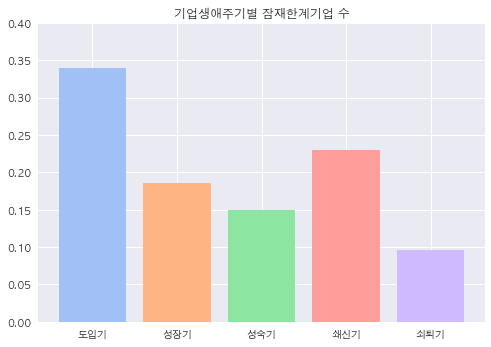

In [209]:
import matplotlib.pyplot as plt
import numpy as np

val_기업 = df_부실징후_최종.shape[0]
print("전체 :",df_부실징후_최종.shape[0])
print("각 생명주기 총합 :", df_부실징후_도입기.shape[0]+df_부실징후_성장기.shape[0]+df_부실징후_성숙기.shape[0]+df_부실징후_쇠퇴기.shape[0]+df_부실징후_쇄신기.shape[0])
print("도입기 :",df_부실징후_도입기.shape[0])
print("성장기 :",df_부실징후_성장기.shape[0])
print("성숙기 :",df_부실징후_성숙기.shape[0])
print("쇄신기 :",df_부실징후_쇄신기.shape[0])
print("쇠퇴기 :",df_부실징후_쇠퇴기.shape[0])

# --------------
x = np.arange(5)
years = ['도입기', '성장기', '성숙기', '쇄신기', '쇠퇴기']
values = [df_부실징후_도입기.shape[0]/val_기업,
        df_부실징후_성장기.shape[0]/val_기업,
        df_부실징후_성숙기.shape[0]/val_기업,
        df_부실징후_쇄신기.shape[0]/val_기업,
        df_부실징후_쇠퇴기.shape[0]/val_기업]

plt.bar(x, values, color=["#A1C0F4", "#FFB483", "#8CE5A1", "#FF9E9B", "#CFBBFF"])
plt.xticks(x, years)
plt.title('기업생애주기별 잠재한계기업 수')
plt.ylim(0,0.4)
plt.show()

기업생명주기별 한계기업

한계기업 수 : 562
도입기 : 207
성장기 : 103
성숙기 : 69
쇄신기 : 126
쇠퇴기 : 57


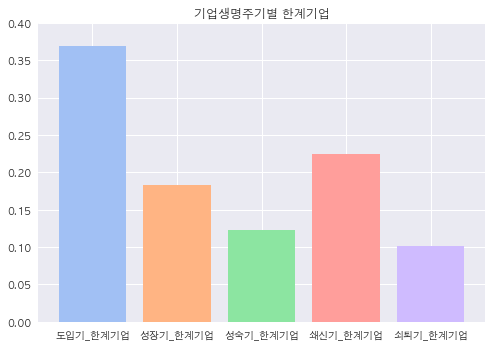

In [210]:
import matplotlib.pyplot as plt
import numpy as np

val_한계기업 = len(df_부실징후_최종[df_부실징후_최종["한계기업여부"]==1])
print("한계기업 수 :", df_부실징후_도입기[df_부실징후_도입기["한계기업여부"]==1].shape[0]+df_부실징후_성장기[df_부실징후_성장기["한계기업여부"]==1].shape[0]+df_부실징후_성숙기[df_부실징후_성숙기["한계기업여부"]==1].shape[0]+df_부실징후_쇄신기[df_부실징후_쇄신기["한계기업여부"]==1].shape[0]+df_부실징후_쇠퇴기[df_부실징후_쇠퇴기["한계기업여부"]==1].shape[0])
print("도입기 :",df_부실징후_도입기[df_부실징후_도입기["한계기업여부"]==1].shape[0])
print("성장기 :",df_부실징후_성장기[df_부실징후_성장기["한계기업여부"]==1].shape[0])
print("성숙기 :",df_부실징후_성숙기[df_부실징후_성숙기["한계기업여부"]==1].shape[0])
print("쇄신기 :",df_부실징후_쇄신기[df_부실징후_쇄신기["한계기업여부"]==1].shape[0])
print("쇠퇴기 :",df_부실징후_쇠퇴기[df_부실징후_쇠퇴기["한계기업여부"]==1].shape[0])

# --------------
x = np.arange(5)
years = ['도입기_한계기업', '성장기_한계기업', '성숙기_한계기업', '쇄신기_한계기업', '쇠퇴기_한계기업']
values = [df_부실징후_도입기[df_부실징후_도입기["한계기업여부"]==1].shape[0]/val_한계기업,
        df_부실징후_성장기[df_부실징후_성장기["한계기업여부"]==1].shape[0]/val_한계기업,
        df_부실징후_성숙기[df_부실징후_성숙기["한계기업여부"]==1].shape[0]/val_한계기업,
        df_부실징후_쇄신기[df_부실징후_쇄신기["한계기업여부"]==1].shape[0]/val_한계기업,
        df_부실징후_쇠퇴기[df_부실징후_쇠퇴기["한계기업여부"]==1].shape[0]/val_한계기업]

plt.bar(x, values, color=["#A1C0F4", "#FFB483", "#8CE5A1", "#FF9E9B", "#CFBBFF"])
plt.xticks(x, years)
plt.title('기업생명주기별 한계기업')
plt.ylim(0,0.4)
plt.show()

기업생명주기별 회생기업

회생기업 수 : 219
도입기 : 58
성장기 : 42
성숙기 : 48
쇄신기 : 53
쇠퇴기 : 18


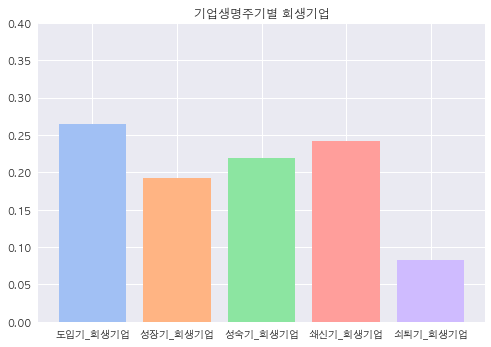

In [211]:
import matplotlib.pyplot as plt
import numpy as np

val_회생기업 = len(df_부실징후_최종[df_부실징후_최종["한계기업여부"]==0])
print("회생기업 수 :", df_부실징후_도입기[df_부실징후_도입기["한계기업여부"]==0].shape[0]+df_부실징후_성장기[df_부실징후_성장기["한계기업여부"]==0].shape[0]+df_부실징후_성숙기[df_부실징후_성숙기["한계기업여부"]==0].shape[0]+df_부실징후_쇄신기[df_부실징후_쇄신기["한계기업여부"]==0].shape[0]+df_부실징후_쇠퇴기[df_부실징후_쇠퇴기["한계기업여부"]==0].shape[0])
print("도입기 :",df_부실징후_도입기[df_부실징후_도입기["한계기업여부"]==0].shape[0])
print("성장기 :",df_부실징후_성장기[df_부실징후_성장기["한계기업여부"]==0].shape[0])
print("성숙기 :",df_부실징후_성숙기[df_부실징후_성숙기["한계기업여부"]==0].shape[0])
print("쇄신기 :",df_부실징후_쇄신기[df_부실징후_쇄신기["한계기업여부"]==0].shape[0])
print("쇠퇴기 :",df_부실징후_쇠퇴기[df_부실징후_쇠퇴기["한계기업여부"]==0].shape[0])

# --------------
x = np.arange(5)
years = ['도입기_회생기업', '성장기_회생기업', '성숙기_회생기업', '쇄신기_회생기업', '쇠퇴기_회생기업']
values = [df_부실징후_도입기[df_부실징후_도입기["한계기업여부"]==0].shape[0]/val_회생기업,
        df_부실징후_성장기[df_부실징후_성장기["한계기업여부"]==0].shape[0]/val_회생기업,
        df_부실징후_성숙기[df_부실징후_성숙기["한계기업여부"]==0].shape[0]/val_회생기업,
        df_부실징후_쇄신기[df_부실징후_쇄신기["한계기업여부"]==0].shape[0]/val_회생기업,
        df_부실징후_쇠퇴기[df_부실징후_쇠퇴기["한계기업여부"]==0].shape[0]/val_회생기업]

plt.bar(x, values, color=["#A1C0F4", "#FFB483", "#8CE5A1", "#FF9E9B", "#CFBBFF"])
plt.xticks(x, years)
plt.title('기업생명주기별 회생기업')
plt.ylim(0,0.4)
plt.show()

### 3. 한계/회생기업 수

전체 데이터 수 : 781
한계기업 데이터 수 : 562
회생기업 데이터 수 : 219


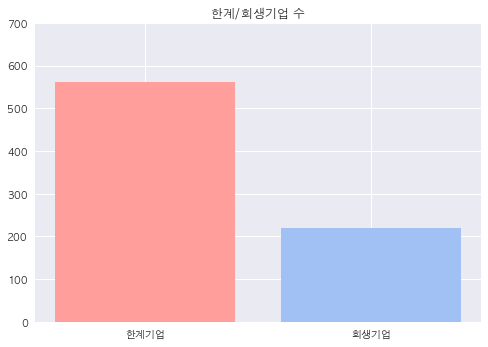

In [212]:
import matplotlib.pyplot as plt
import numpy as np

print("전체 데이터 수 :", df_부실징후_최종.shape[0])
print("한계기업 데이터 수 :", df_부실징후_최종[df_부실징후_최종["한계기업여부"]==1].shape[0])
print("회생기업 데이터 수 :", df_부실징후_최종[df_부실징후_최종["한계기업여부"]==0].shape[0])

# --------------
x = np.arange(2)
years = ['한계기업', '회생기업']
values = [df_부실징후_최종[df_부실징후_최종["한계기업여부"]==1].shape[0], df_부실징후_최종[df_부실징후_최종["한계기업여부"]==0].shape[0]]

plt.bar(x, values, color=["#FF9E9B", "#A1C0F4"])
plt.xticks(x, years)
plt.title('한계/회생기업 수')
plt.ylim(0,700)
plt.show()

### 4. 연도별 데이터 수

2012년 :  276
2013년 :  117
2014년 :  89
2015년 :  58
2016년 :  67
2017년 :  83
2018년 :  91


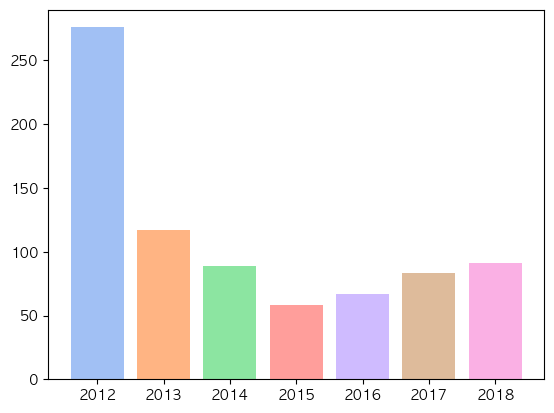

In [ ]:
import matplotlib.pyplot as plt
import numpy as np

# 각 년도 기업수
list_year = [2012, 2013,2014,2015,2016,2017,2018]
for i in list_year:
        print(str(i)+"년 : ", len(df_부실징후_최종[df_부실징후_최종["회계년도"]==i]["거래소코드"].unique()))          

# --------------
x = np.arange(7)
years = ['2012', '2013', '2014', '2015', '2016', '2017', '2018']
values = [df_부실징후_최종[df_부실징후_최종["회계년도"]==2012].shape[0], df_부실징후_최종[df_부실징후_최종["회계년도"]==2013].shape[0], df_부실징후_최종[df_부실징후_최종["회계년도"]==2014].shape[0]
        , df_부실징후_최종[df_부실징후_최종["회계년도"]==2015].shape[0], df_부실징후_최종[df_부실징후_최종["회계년도"]==2016].shape[0], df_부실징후_최종[df_부실징후_최종["회계년도"]==2017].shape[0], df_부실징후_최종[df_부실징후_최종["회계년도"]==2018].shape[0]]

plt.bar(x, values, color=["#A1C0F4", "#FFB483", "#8CE5A1", "#FF9E9B", "#CFBBFF", "#DEBB9B", "#FAB0E4"])
plt.xticks(x, years)

plt.show()

### 4. 마지막 결측치 확인

In [585]:
df_부실징후_최종.isna().sum().to_dict()

{'회사명': 0,
 '거래소코드': 0,
 '회계년도': 0,
 '한계기업여부': 0,
 '이자보상배율(이자비용)': 0,
 '부가가치(백만원)': 0,
 '금융비용(백만원)': 0,
 '매출액총이익률': 0,
 '매출액순이익률': 0,
 '총자본사업이익률': 0,
 '총자본순이익률': 0,
 '자기자본순이익률': 0,
 '경영자본순이익률': 0,
 '자본금순이익률': 0,
 '매출원가대매출액비율': 0,
 '영업비용대영업수익비율': 0,
 '금융손익비율': 0,
 '금융비용부담률': 0,
 '기업순이익률': 0,
 '인건비대총비용비율': 0,
 '금융비용대총비용비율': 0,
 '이자부담률': 0,
 '지급이자율': 0,
 '차입금평균이자율': 0,
 '유보율': 0,
 '유동자산구성비율': 0,
 '재고자산대유동자산비율': 0,
 '유동자산대비유동자산비율': 0,
 '자기자본구성비율': 0,
 '타인자본구성비율': 0,
 '자기자본배율': 0,
 '유동비율': 0,
 '현금비율': 0,
 '매출채권비율': 0,
 '매입채무대재고자산비율': 0,
 '순운전자본비율': 0,
 '차입금의존도': 0,
 '차입금비율': 0,
 '총자본회전률': 0,
 '자기자본회전률': 0,
 '자본금회전률': 0,
 '타인자본회전률': 0,
 '매입채무회전률': 0,
 '당좌자산회전률': 0,
 '재고자산회전률': 0,
 '매출채권회전률': 0,
 '비유동자산회전률': 0,
 '유형자산회전율': 0,
 '순운전자본회전률': 0,
 '사내유보대자기자본비율': 0,
 '자기자본배당률': 0,
 '배당성향': 0,
 '이익잉여금(결손금)(요약)(백만원)': 0,
 '비유동금융부채(요약)(백만원)': 0,
 '비유동자산증가율': 0,
 '유동금융부채(요약)(백만원)': 0,
 '외국인_주식분포비율': 0,
 '장기금융부채(백만원)': 0,
 '자산대비자본비율': 0,
 '차입': 0,
 '총자본증가율': 0,
 '유형자산증가율': 0,
 '비유동자산(백만원)': 0,
 '자기자본증가율

### 5. 마지막 inf값 확인

In [586]:
list_inf = list()
list_재무_columns = list(df_부실징후_최종.columns)
# df_부실징후_최종.select_dtypes(include="object")
list_재무_columns.remove("회사명")
list_재무_columns.remove("거래소코드")
list_재무_columns.remove("회계년도")

# 1) inf값 있는 기업 리스트로 확인
for i in list_재무_columns:
    if len(df_부실징후_최종[np.isinf(abs(df_부실징후_최종[i]))]) > 0:
        list_inf.append(i)
list_inf

[]

In [587]:
df_부실징후_최종.to_csv("./datasets/부실징후_전처리끝.csv")

In [7]:
df_부실징후_최종 = pd.read_csv("./datasets/부실징후_전처리끝.csv", index_col=0)
df_부실징후_최종["거래소코드"] = df_부실징후_최종["거래소코드"].map(padding)
df_부실징후_최종

회사명   거래소코드    회계년도  한계기업여부  이자보상배율(이자비용)  부가가치(백만원)  금융비용(백만원)  \
0      케이알모터스(주)  000040  2013.0       1         -4.29    9379.15     603.89   
1      성창기업지주(주)  000180  2013.0       1         -1.39   28423.83    1111.80   
2          디엘(주)  000210  2014.0       0         -3.33  494645.17   31419.37   
3       일동홀딩스(주)  000230  2017.0       1          0.61   20134.11    1550.73   
4       (주)대유플러스  000300  2012.0       0         -4.88   28096.06    3110.15   
..           ...     ...     ...     ...           ...        ...        ...   
776      (주)에이트원  230980  2018.0       1         -0.14   12878.02    4094.78   
777  (주)얼라인드제네틱스  238120  2017.0       1        -29.21    2091.01    -294.03   
778       피씨엘(주)  241820  2018.0       1        -29.21   -2639.11     -28.40   
779       (주)아스타  246720  2018.0       1        -22.95    -929.19    -333.43   
780       (주)모비스  250060  2018.0       1        -27.35    2070.53     -86.30   

     매출액총이익률  매출액순이익률  총자본사업이익률  ...  순자산가치(백만원)          KZ지수   산업매출성장률  \
0       7.59    -6.64     -2.77  ...     57315.0 -8.591876e+10  8.405309   
1      14.62    -2.82     -0.52  ...    253423.0 -4.619692e+10  8.684003   
2       2.11    -4.74     -2.06  ...   2648892.0  8.205913e+10 -2.139125   
3      44.23     0.06      0.78  ...    174057.0 -4.613540e+11  7.191381   
4       0.91    -4.78     -2.90  ...    101198.0 -2.580369e+10  5.164151   
..       ...      ...       ...  ...         ...           ...       ...   
776     9.05    -1.56     -1.08  ...     22545.0 -1.272294e+11  6.732754   
777    58.33   -31.13     -4.97  ...     22022.0 -3.992706e+11  7.191381   
778    34.40  -249.62    -45.10  ...     12676.0 -4.106535e+11  2.340424   
779    58.33  -202.15    -14.10  ...     33248.0 -1.545284e+10  2.340424   
780    26.81   -14.17     -4.83  ...     24428.0 -3.375271e+11  6.732754   

             WW지수    NCAV지수  기업생명주기  순매수거래량_기관  순매수거래대금 비중_기관  순매수거래량_외국인  \
0   -6.576044e+08  0.001550       1      154.0       0.000010    666080.0   
1    2.632381e+09  0.106379       0    28438.0       0.001337    -43268.0   
2    1.844954e+09 -1.336562       1 -2124518.0      -0.010160   -122922.0   
3    6.045934e+08 -0.263390       0     -854.0       0.000013   -148806.0   
4    7.068060e+08 -2.521432       0 -1414659.0      -0.002001  -1238620.0   
..            ...       ...     ...        ...            ...         ...   
776 -5.899405e+09 -0.068759       1     8810.0       0.000218   -192641.0   
777  3.283293e+09  0.446974       0    30809.0       0.001985     -8713.0   
778  2.617107e+10  0.049385       3        0.0       0.000000    -51504.0   
779  1.086485e+10  0.227212       0        0.0       0.000000   -139221.0   
780  2.560419e+09  0.098268       0   -11056.0      -0.000038    -87368.0   

     순매수거래대금 비중_외국인  
0          0.001283  
1          0.000147  
2          0.000605  
3         -0.001702  
4         -0.002065  
..              ...  
776       -0.005370  
777       -0.000922  
778       -0.001132  
779       -0.001538  
780       -0.001121  

[781 rows x 88 columns]

> # 전처리끝 :)

---

---
# Feature Selection

In [ ]:
# 전처리 끝난 데이터 Load
df_부실징후 = pd.read_csv("./datasets/부실징후_전처리끝.csv", index_col=0)
df_부실징후["거래소코드"] = df_부실징후["거래소코드"].map(padding)
print(df_부실징후.shape[0])
df_부실징후

## Data Split
- Data Leakage 방지
- Train과 Test를 분리 후 각각 scaling
- Train set를 가지고 Feature selection 진행

In [ ]:
target = '한계기업여부'
list_non_col = ['투자축소_여부', '직원증감률_여부', '종업원수증가율','매출원가축소_여부', '자산매각_여부', '자본증가율_여부', '차입_여부', '사내유보금보유_여부', '운용적범주전략(OPS)변수','기업생명주기',]

# tain : 2012~2016
train_set = df_부실징후[((df_부실징후["회계년도"]==2017)|(df_부실징후["회계년도"]==2018)).map(func_not)]
train_set.reset_index(drop=True, inplace=True)
train_set_index = train_set[["거래소코드","회계년도"]] # 나중에 투자할 회생기업 뽑을 때 사용
y_train = train_set[target]
X_train_non_scale = train_set[list_non_col]
X_train = train_set.drop(["회사명", '거래소코드', "회계년도", target], axis=1)
X_train = X_train.drop(list_non_col, axis=1)


# test : 2017, 2018
test_set = df_부실징후[((df_부실징후["회계년도"]==2017)|(df_부실징후["회계년도"]==2018))]
test_set.reset_index(drop=True, inplace=True)
test_set_index = test_set[["거래소코드","회계년도"]] # 나중에 투자할 회생기업 뽑을 때 사용
y_test = test_set[target]
X_test_non_scale = test_set[list_non_col]
X_test = test_set.drop(["회사명", '거래소코드', "회계년도",target], axis=1)
X_test = X_test.drop(list_non_col, axis=1)

In [ ]:
from sklearn.preprocessing import StandardScaler

# StandardScaler객체 생성
scaler_stan = StandardScaler()
scaler_stan.fit(X_train)
data_scaled_stan = scaler_stan.transform(X_train)

# transform()시 scale 변환된 데이터 셋이 numpy ndarry로 반환되어 이를 DataFrame으로 변환
x_train_stan = pd.DataFrame(data = data_scaled_stan, columns=X_train.columns)
x_train_stan = pd.concat([x_train_stan, X_train_non_scale], axis=1)
x_train_stan

이자보상배율(이자비용)  부가가치(백만원)  금융비용(백만원)   매출액총이익률   매출액순이익률   총자본사업이익률  \
0        0.239475  -0.237312  -0.363394 -0.339336  0.421883   0.332877   
1        0.550029  -0.036135  -0.337115  0.088769  0.499815   0.551640   
2        0.342279   4.888761   1.230999 -0.673051  0.460645   0.401909   
3        0.176293  -0.039597  -0.233721 -0.746127  0.459829   0.320238   
4        0.364767  -1.006339   1.972799 -1.571888 -0.381508  -0.199930   
..            ...        ...        ...       ...       ...        ...   
602     -2.429155  -0.360176  -0.406313 -0.801543 -0.119560  -1.027338   
603     -2.429155  -0.370890  -0.390894  0.790910 -4.535150  -4.329190   
604     -1.324008  -0.390163  -0.384113  2.750570 -4.535150  -1.771130   
605      0.139883  -0.594071  -0.386730 -1.944577 -4.535150  -0.699681   
606     -2.186066  -0.350052  -0.391095  2.750570 -1.801009 -11.231383   

      총자본순이익률  자기자본순이익률  경영자본순이익률   자본금순이익률  ...  투자축소_여부  직원증감률_여부  \
0    0.278988  0.431860  0.453838  0.662705  ...        0         0   
1    0.481249  0.664605  0.707267  0.636958  ...        1         0   
2    0.348766  0.435374  0.478286 -0.681660  ...        1         0   
3    0.402042  0.296970  0.413885  0.464017  ...        0         0   
4   -0.233971 -1.463621 -0.704185 -2.567871  ...        0         0   
..        ...       ...       ...       ...  ...      ...       ...   
602 -0.844525 -0.213123 -1.085820 -0.960450  ...        0         0   
603 -1.720516 -2.264037 -2.080455 -0.928505  ...        1         0   
604 -0.537598 -0.305302 -0.646940 -0.073198  ...        0         0   
605 -4.685591  0.709748 -3.487733 -3.526711  ...        0         0   
606 -5.082097  0.709748 -3.487733  0.442493  ...        1         0   

       종업원수증가율  매출원가축소_여부  자산매각_여부  자본증가율_여부  차입_여부  사내유보금보유_여부  \
0    -4.819277        0.0        0         0      0           0   
1    -8.974359        1.0        0         0      0           0   
2    -5.089505        0.0        0         0      1           0   
3    15.424165        0.0        0         1      0           0   
4   -13.318777        0.0        1         0      0           0   
..         ...        ...      ...       ...    ...         ...   
602  34.146341        0.0        1         0      0           0   
603  21.276596        0.0        0         1      0           0   
604  27.419355        0.0        1         0      1           0   
605  19.444444        0.0        1         0      0           0   
606  18.750000        0.0        1         0      0           0   

     운용적범주전략(OPS)변수  기업생명주기  
0                 0       1  
1                 1       0  
2                 1       1  
3                 0       0  
4                 0       3  
..              ...     ...  
602               0       4  
603               1       0  
604               0       0  
605               0       0  
606               1       0  

[607 rows x 84 columns]

In [ ]:
from sklearn.preprocessing import StandardScaler

# StandardScaler객체 생성
scaler_stan = StandardScaler()
scaler_stan.fit(X_test)
data_scaled_stan = scaler_stan.transform(X_test)

# transform()시 scale 변환된 데이터 셋이 numpy ndarry로 반환되어 이를 DataFrame으로 변환
x_test_stan = pd.DataFrame(data = data_scaled_stan, columns=X_test.columns)
x_test_stan = pd.concat([x_test_stan, X_test_non_scale], axis=1)
x_test_stan

이자보상배율(이자비용)  부가가치(백만원)  금융비용(백만원)   매출액총이익률   매출액순이익률  총자본사업이익률  \
0        0.905577  -0.173789  -0.195188  1.767937  0.526339  0.693626   
1       -1.617986  -0.074835  -0.500284 -0.311486  0.519420  0.439925   
2        0.868341  -0.312552  -0.077032  0.172671  0.486919  0.639867   
3        0.933503  -0.018960  -0.220650  1.265394  0.618693  0.748327   
4        0.831951  -0.643130  -0.215774 -0.154595  0.060383  0.640811   
..            ...        ...        ...       ...       ...       ...   
169      0.842107  -0.260385   0.063378 -0.388093  0.500274  0.518204   
170     -1.617986  -0.389121  -0.382682  2.632065  0.024503  0.151328   
171     -1.617986  -0.445572  -0.355684  1.165498 -3.490920 -3.633435   
172     -1.088224  -0.425165  -0.386686  2.632065 -2.727145 -0.709745   
173     -1.460580  -0.389366  -0.361569  0.700340  0.297383  0.164532   

      총자본순이익률  자기자본순이익률  경영자본순이익률   자본금순이익률  ...  투자축소_여부  직원증감률_여부  \
0    0.701375  0.681572  0.795620  0.910634  ...        1         0   
1    0.681263  0.656212  0.761824  0.840937  ...        1         0   
2    0.660457  0.637714  0.604734  0.808465  ...        0         0   
3    1.041205  0.917870  1.087270  1.012532  ...        1         1   
4   -0.549061 -0.202159 -0.717705 -2.454353  ...        1         0   
..        ...       ...       ...       ...  ...      ...       ...   
169  0.620232  0.505841  0.709252  0.352509  ...        1         0   
170  0.215903  0.444081  0.350635  0.194500  ...        1         0   
171 -2.321033 -0.700115 -1.997585 -0.017310  ...        1         0   
172 -0.088557  0.317876 -0.205127  0.524715  ...        0         0   
173  0.611909  0.626376  0.688599  0.790124  ...        0         0   

       종업원수증가율  매출원가축소_여부  자산매각_여부  자본증가율_여부  차입_여부  사내유보금보유_여부  \
0     1.388889        0.0        0         1      0           0   
1     3.209877        0.0        0         1      0           0   
2     0.000000        1.0        0         0      1           0   
3   -30.576441        0.0        0         1      1           0   
4     0.000000        1.0        0         0      0           0   
..         ...        ...      ...       ...    ...         ...   
169 -10.309278        0.0        1         1      0           0   
170  -8.771930        0.0        1         0      0           0   
171  40.000000        0.0        1         0      0           0   
172  -4.166667        0.0        1         1      0           0   
173   0.000000        1.0        1         0      1           0   

     운용적범주전략(OPS)변수  기업생명주기  
0                 1       0  
1                 1       4  
2                 1       1  
3                 1       1  
4                 1       0  
..              ...     ...  
169               1       1  
170               1       0  
171               1       3  
172               0       0  
173               1       0  

[174 rows x 84 columns]

## Heatmap

<AxesSubplot: title={'center': 'Correlation of Features'}>

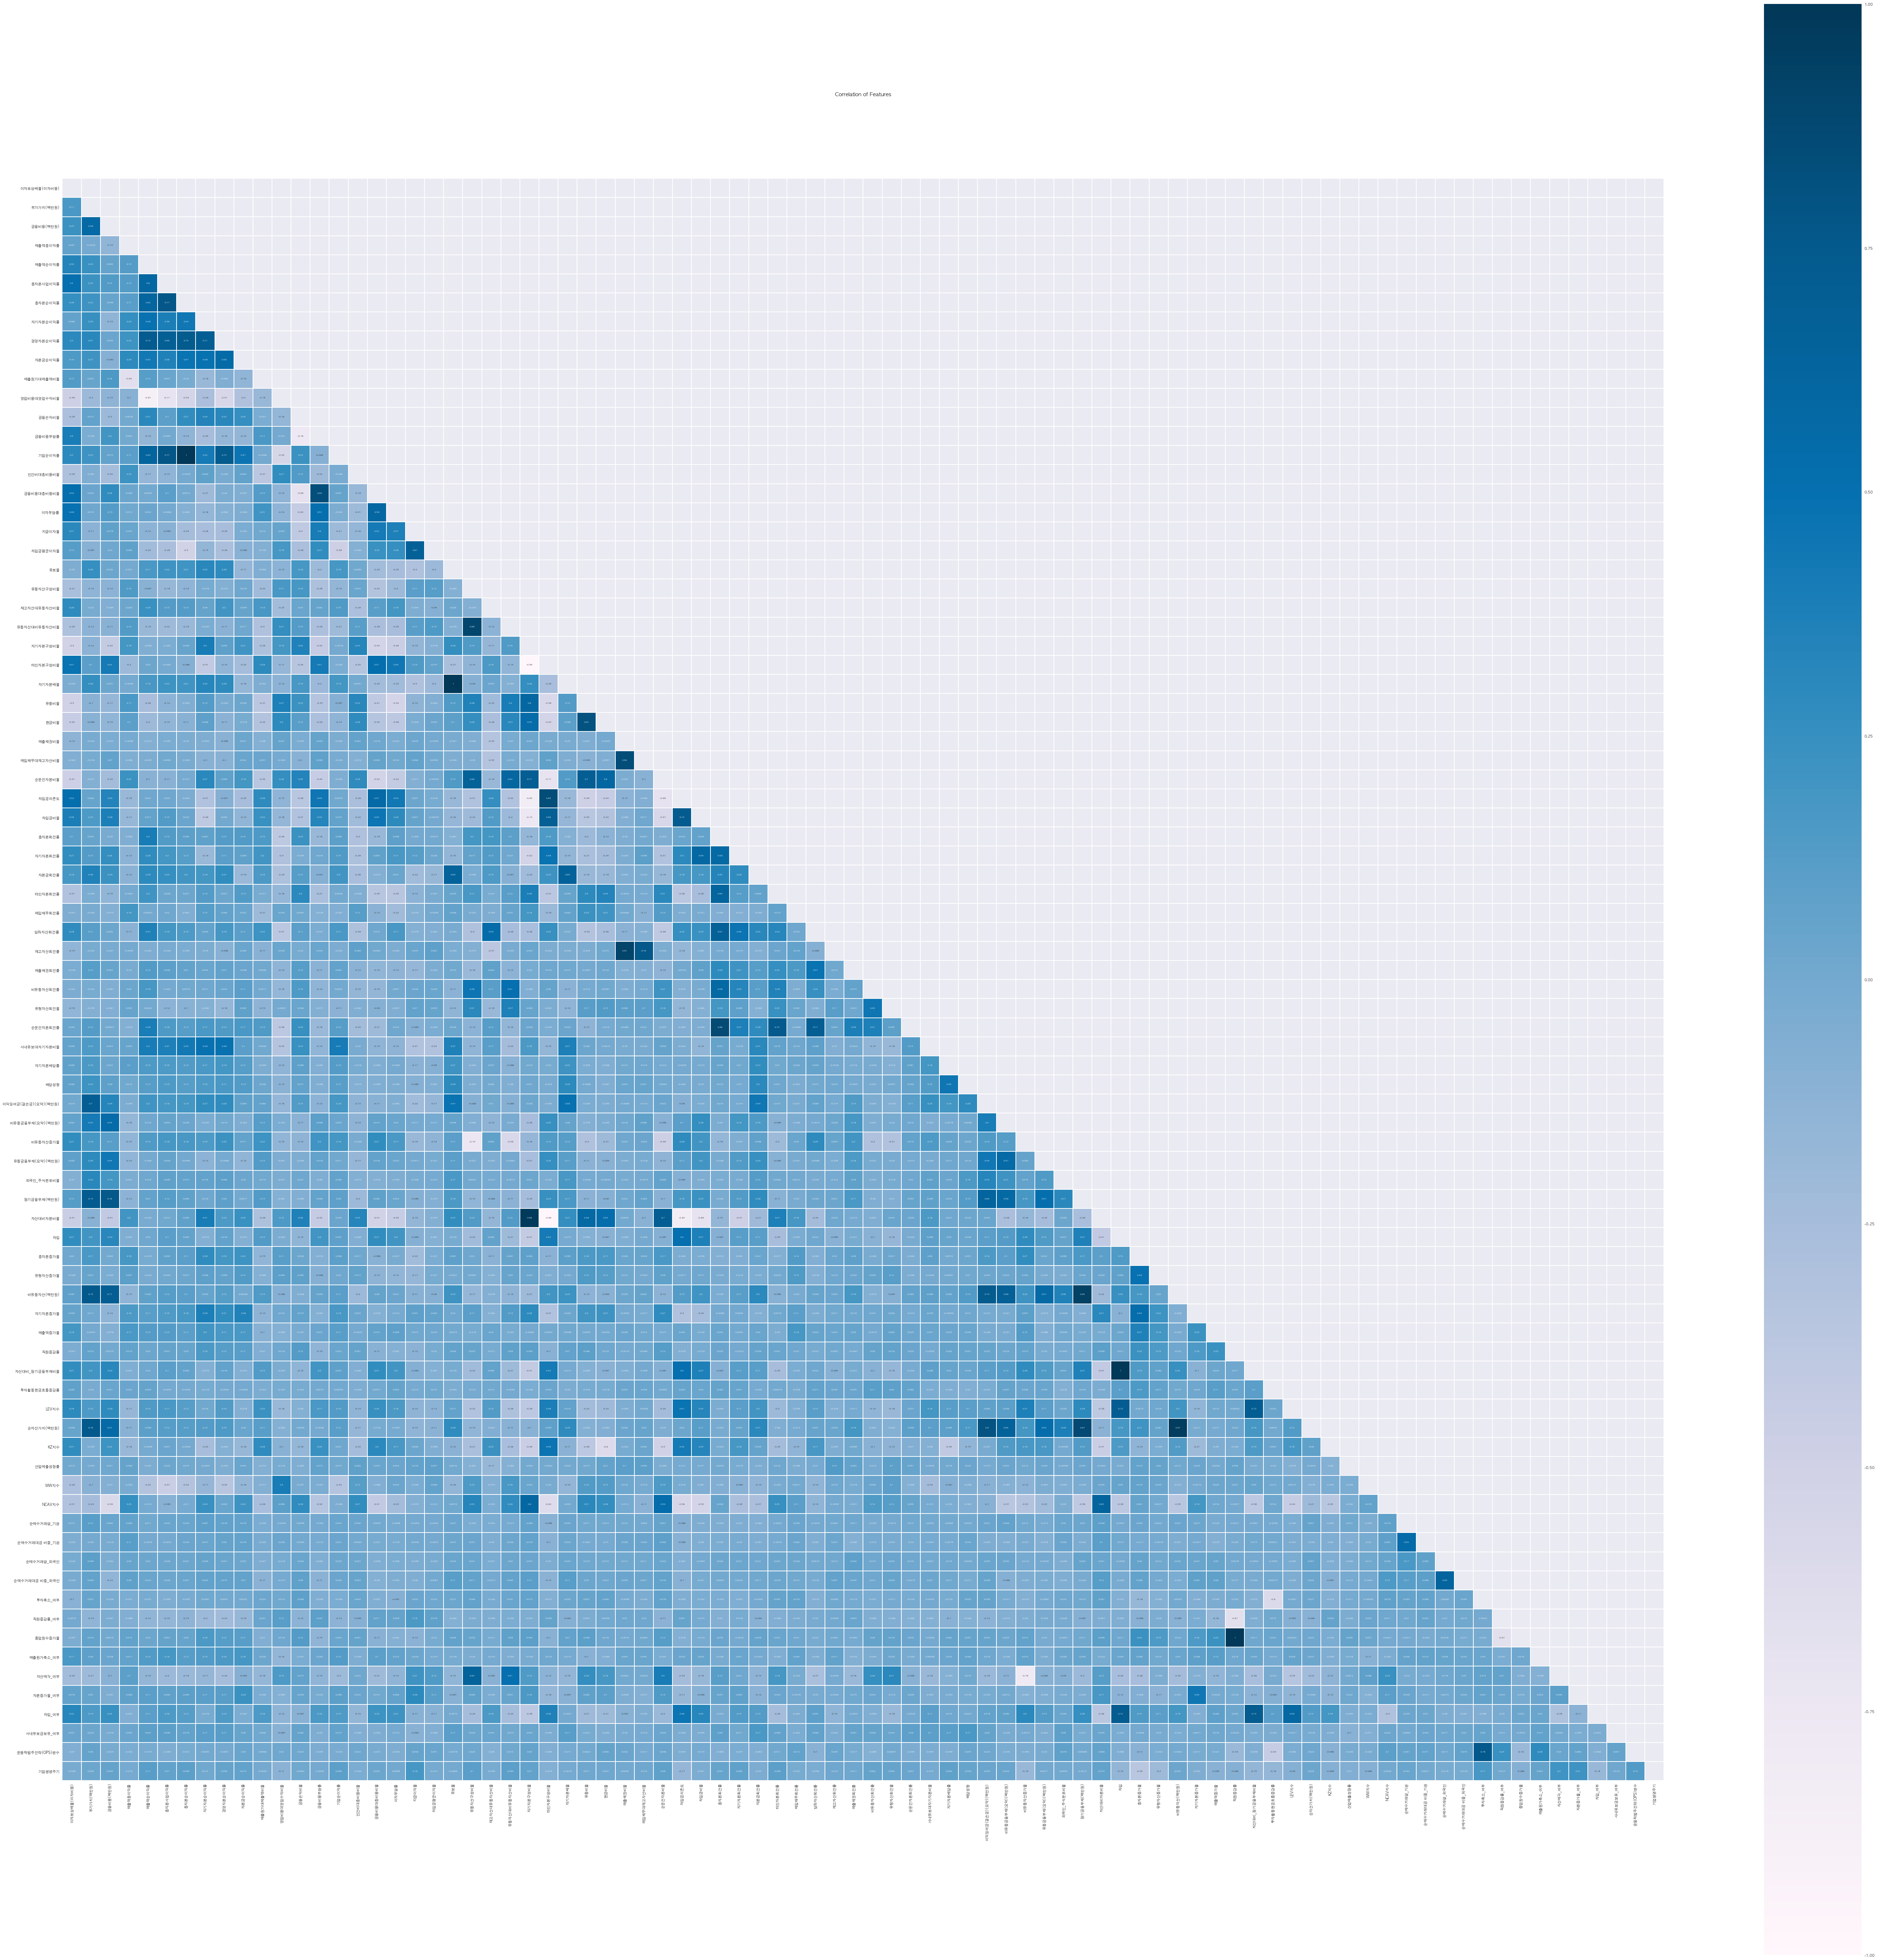

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings(action='ignore')

# plt.rcParams['font.family'] = 'Malgun Gothic'
df_corr = x_train_stan.corr()

mask = np.zeros_like(df_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True


colormap = plt.cm.PuBu
plt.figure(figsize=(100, 100))
plt.rcParams['axes.unicode_minus'] = False
plt.rc('font', family='AppleGothic')
plt.title("Correlation of Features", y = 1.05, size = 15)
sns.heatmap(x_train_stan.astype(float).corr(), linewidths = 0.1, mask=mask ,vmax = 1.0, 
            vmin= -1.0 , square = True, cmap = colormap, linecolor = "white", annot = True, annot_kws = {"size" : 6})

## 1. 정규성검정
- shapiro, anderson, kstest, jarque_bera, normaltest 별로 검정만족하는 컬럼 확인

In [ ]:
# 정규성 검정을 하나의 함수로
from scipy.stats import shapiro, anderson, kstest, jarque_bera, normaltest

def normal_test(test_name,x):
    normal = []
    notnormal = []
    if test_name == 'shapiro':
        for var in x.columns :
            stat, p  = shapiro(x[var].values)
            alpha = 0.05
            if p > alpha :
                normal.append(var)
            else :
                notnormal.append(var)
                
    elif test_name == 'anderson':
        for var in x.columns :
            result  = anderson(x[var].values,dist='norm')
            normality = 0
            for i in range(len(result.critical_values)):
                # sl, cv = result.significance_level[i], result.critical_values[i]
                if result.statistic < result.critical_values[i]:
                    normality +=1
                else :
                    normality +=0
            if normality > 2.5 :
                normal.append(var)
            else :
                notnormal.append(var)
                
    elif test_name == 'kstest':
        for var in x.columns :
            stat,p  = kstest(x[var].values, "norm")
            alpha = 0.05
            if p > alpha :
                normal.append(var)
            else :
                notnormal.append(var)
    
    elif test_name == 'jarque_bera':
        for var in x.columns :
            stat,p  = jarque_bera(x[var].values)
            alpha = 0.05
            if p > alpha :
                normal.append(var)
            else :
                notnormal.append(var)
                
    elif test_name == 'normaltest':
        for var in x.columns :
            stat, p  = normaltest(x[var].values)
            alpha = 0.05
            if p > alpha :
                normal.append(var)
            else :
                notnormal.append(var)
    else:
        pass
    return pd.DataFrame(normal, columns = ['normal']),pd.DataFrame(notnormal, columns = ['notnormal'])

In [ ]:
# 1) shapiro
## normal
## 귀무가설을 기각하지 못했다 -> 정규분포를 따른다
## notnormal
## 귀무가설을 기각 대립가설 채택 -> data 분포가 정규분포를 따르지 않는다.
normal_s,notnormal_s = normal_test('shapiro',x_train_stan)
normal_s

Empty DataFrame
Columns: [normal]
Index: []

In [ ]:
# 2) anderson test
normal_a,notnormal_a = normal_test('anderson',x_train_stan)
normal_a

Empty DataFrame
Columns: [normal]
Index: []

In [ ]:
# 3) ks test
normal_ks,notnormal_ks = normal_test('kstest',x_train_stan)
normal_ks

normal
0  유동자산구성비율
1  타인자본구성비율
2   순운전자본비율
3    차입금의존도
4  자산대비자본비율

In [ ]:
# 4) jarque_bera test
normal_jb,notnormal_jb = normal_test('jarque_bera',x_train_stan)
normal_jb

normal
0  차입금의존도

In [ ]:
# 5) normaltest
normal_n,notnormal_n = normal_test('normaltest',x_train_stan)
normal_n

normal
0  차입금의존도

## 2. 등분산 검정

In [ ]:
x_등분산 = pd.concat([x_train_stan, y_train], axis=1)
x_등분산

이자보상배율(이자비용)  부가가치(백만원)  금융비용(백만원)   매출액총이익률   매출액순이익률   총자본사업이익률  \
0        0.239475  -0.237312  -0.363394 -0.339336  0.421883   0.332877   
1        0.550029  -0.036135  -0.337115  0.088769  0.499815   0.551640   
2        0.342279   4.888761   1.230999 -0.673051  0.460645   0.401909   
3        0.176293  -0.039597  -0.233721 -0.746127  0.459829   0.320238   
4        0.364767  -1.006339   1.972799 -1.571888 -0.381508  -0.199930   
..            ...        ...        ...       ...       ...        ...   
602     -2.429155  -0.360176  -0.406313 -0.801543 -0.119560  -1.027338   
603     -2.429155  -0.370890  -0.390894  0.790910 -4.535150  -4.329190   
604     -1.324008  -0.390163  -0.384113  2.750570 -4.535150  -1.771130   
605      0.139883  -0.594071  -0.386730 -1.944577 -4.535150  -0.699681   
606     -2.186066  -0.350052  -0.391095  2.750570 -1.801009 -11.231383   

      총자본순이익률  자기자본순이익률  경영자본순이익률   자본금순이익률  ...  직원증감률_여부    종업원수증가율  \
0    0.278988  0.431860  0.453838  0.662705  ...         0  -4.819277   
1    0.481249  0.664605  0.707267  0.636958  ...         0  -8.974359   
2    0.348766  0.435374  0.478286 -0.681660  ...         0  -5.089505   
3    0.402042  0.296970  0.413885  0.464017  ...         0  15.424165   
4   -0.233971 -1.463621 -0.704185 -2.567871  ...         0 -13.318777   
..        ...       ...       ...       ...  ...       ...        ...   
602 -0.844525 -0.213123 -1.085820 -0.960450  ...         0  34.146341   
603 -1.720516 -2.264037 -2.080455 -0.928505  ...         0  21.276596   
604 -0.537598 -0.305302 -0.646940 -0.073198  ...         0  27.419355   
605 -4.685591  0.709748 -3.487733 -3.526711  ...         0  19.444444   
606 -5.082097  0.709748 -3.487733  0.442493  ...         0  18.750000   

     매출원가축소_여부  자산매각_여부  자본증가율_여부  차입_여부  사내유보금보유_여부  운용적범주전략(OPS)변수  기업생명주기  \
0          0.0        0         0      0           0               0       1   
1          1.0        0         0      0           0               1       0   
2          0.0        0         0      1           0               1       1   
3          0.0        0         1      0           0               0       0   
4          0.0        1         0      0           0               0       3   
..         ...      ...       ...    ...         ...             ...     ...   
602        0.0        1         0      0           0               0       4   
603        0.0        0         1      0           0               1       0   
604        0.0        1         0      1           0               0       0   
605        0.0        1         0      0           0               0       0   
606        0.0        1         0      0           0               1       0   

     한계기업여부  
0         1  
1         1  
2         0  
3         0  
4         1  
..      ...  
602       1  
603       1  
604       1  
605       1  
606       1  

[607 rows x 85 columns]

In [ ]:
# H가 1인 경우 이분산성 / H가 0인 경우 등분산
from scipy.stats import bartlett
def bartlett_test(col, p_value = 0.05, H = 1):
    list= []
    for i in col:
        T, p_val =bartlett(x_등분산[x_등분산['한계기업여부']==1][i], x_등분산[x_등분산['한계기업여부']==0][i]) 
        list.append([i, p_val])

    list = pd.DataFrame(list, columns = ['변수', 'p_value'])
    if H == 1:
        a = list[(list['p_value'] < p_value)][['변수', 'p_value']].sort_values('p_value')
        return a
    else:
        a = list[(list['p_value'] >= p_value)][['변수', 'p_value']].sort_values('p_value')
        return a

In [ ]:
# 이분산성 변수
x_hetero = bartlett_test(x_train_stan, H = 1)
# 등분산성 변수
x_homo = bartlett_test(x_train_stan.columns, H = 0)

set_이분산 = set(x_hetero["변수"])
set_등분산 = set(x_homo["변수"])
print(len(set_이분산))
print(len(set_등분산))

49
35


## 3. durbin-watsons


<img width="1104" alt="image" src="https://user-images.githubusercontent.com/88031549/236772221-87a4785f-a5f2-4bcb-bdf9-8d388662a67a.png">

## 4. t-test

In [ ]:
# t_test
import scipy.stats as stats
def t_test(col, col_h0, col_h1, p_value = 0.05):
    list= []
    for i in col:
        if (col_h0['변수']==i).any():
            t_stat, p_val = stats.ttest_ind(x_등분산[x_등분산['한계기업여부']==1][i], x_등분산[x_등분산['한계기업여부']==0][i], equal_var=True) # 등분산성 : wald t-test
            list.append([i, p_val])
        elif (col_h1['변수']==i).any():
            t_stat, p_val = stats.ttest_ind(x_등분산[x_등분산['한계기업여부']==1][i], x_등분산[x_등분산['한계기업여부']==0][i], equal_var=False) # 이분산성 : welch’s t-test
            list.append([i, p_val])

    list = pd.DataFrame(list, columns = ['변수', 'p_value'])
    a = list[(list['p_value'] < p_value)][['변수', 'p_value']].sort_values('p_value')
    return a

In [ ]:
# 2) t_test 결과 p_value < 0.05보다 작은 유의한 변수 가져오기
x_ttest = t_test(x_train_stan.columns, x_homo, x_hetero, p_value=0.05)
ttest_col = list(x_ttest["변수"])
print("유의한 피쳐 수 :", len(x_ttest))
x_ttest.sort_values(by="변수", ascending=True)

유의한 피쳐 수 : 25


변수       p_value
68                 WW지수  2.873925e-04
8              경영자본순이익률  1.620124e-09
16           금융비용대총비용비율  8.557245e-03
13              금융비용부담률  3.141947e-03
14               기업순이익률  5.887691e-07
4               매출액순이익률  9.607308e-09
77            매출원가축소_여부  1.174554e-02
1             부가가치(백만원)  4.689994e-02
45          사내유보대자기자본비율  1.303747e-08
44             순운전자본회전률  7.680234e-03
11          영업비용대영업수익비율  1.108736e-10
20                  유보율  2.709734e-03
57              유형자산증가율  1.436878e-03
48  이익잉여금(결손금)(요약)(백만원)  4.148450e-03
26               자기자본배율  2.587360e-03
7              자기자본순이익률  7.350436e-08
9               자본금순이익률  2.642739e-02
36               자본금회전률  2.087615e-04
18                지급이자율  4.286547e-03
75             직원증감률_여부  4.197852e-03
32               차입금의존도  1.779824e-02
19             차입금평균이자율  2.187966e-04
5              총자본사업이익률  9.305229e-08
6               총자본순이익률  1.856565e-07
34               총자본회전률  9.068482e-03

## 5. VIF

In [ ]:
col_유의 = list(x_ttest["변수"])
X_train_유의 = x_train_stan[col_유의]

In [ ]:
from statsmodels.stats.outliers_influence import variance_inflation_factor

# VIF 출력을 위한 데이터 프레임 형성
vif = pd.DataFrame()

# VIF 값과 각 Feature 이름에 대해 설정
vif["VIF Factor"] = [variance_inflation_factor(X_train_유의.values, i) for i in range(X_train_유의.shape[1])]
vif["features"] = X_train_유의.columns 

# VIF 값이 높은 순으로 정렬
vif = vif.sort_values(by="VIF Factor", ascending=False)
vif = vif.reset_index().drop(columns='index')
vif

VIF Factor             features
0   1487.012572               기업순이익률
1   1475.041424              총자본순이익률
2    203.950202               자기자본배율
3    197.439760                  유보율
4     11.218960              매출액순이익률
5     10.327767          영업비용대영업수익비율
6      7.543100           금융비용대총비용비율
7      6.454596             경영자본순이익률
8      6.267619               총자본회전률
9      6.081260             총자본사업이익률
10     4.893032             순운전자본회전률
11     3.903378              금융비용부담률
12     3.750559               차입금의존도
13     3.602912               자본금회전률
14     3.261581                지급이자율
15     2.953181             자기자본순이익률
16     2.705523             차입금평균이자율
17     2.536779              자본금순이익률
18     2.503982  이익잉여금(결손금)(요약)(백만원)
19     2.301992            부가가치(백만원)
20     1.729980          사내유보대자기자본비율
21     1.366512                 WW지수
22     1.146353              유형자산증가율
23     1.145863             직원증감률_여부
24     1.121140            매출원가축소_여부

## 6. Wrapper Method

### Stepwise

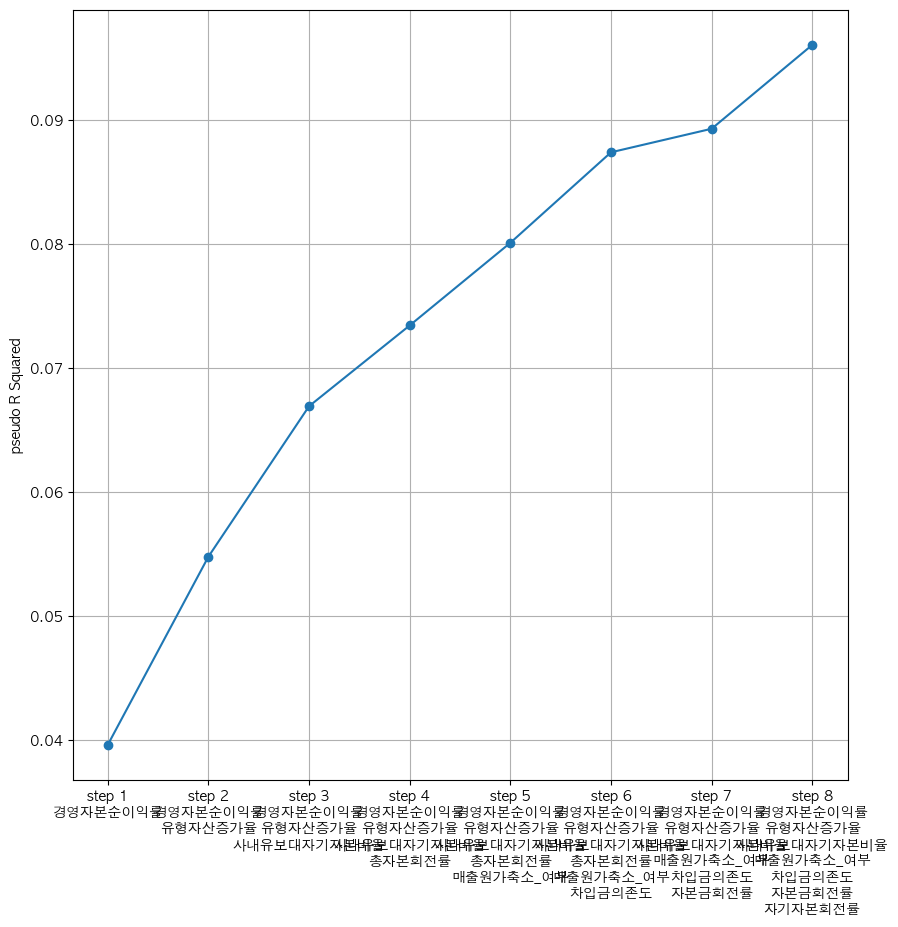

In [ ]:
def stepwise_feature_selection(feature, target, variables):
    import statsmodels.api as sm
    import matplotlib.pyplot as plt
    import warnings
    import pandas as pd
    warnings.filterwarnings("ignore")
    
    y = target ## 반응 변수

    selected_variables = [] ## 선택된 변수들
    sl_enter = 0.05
    sl_remove = 0.05
    
    sv_per_step = [] ## 각 스텝별로 선택된 변수들
    r_squared = [] ## 각 스텝별 수정된 결정계수
    steps = [] ## 스텝
    step = 0
    while len(variables) > 0:
        remainder = list(set(variables) - set(selected_variables))
        pval = pd.Series(index=remainder) ## 변수의 p-value
        ## 기존에 포함된 변수와 새로운 변수 하나씩 돌아가면서
        ## 선형 모형을 적합한다.
        for col in remainder: 
            X = feature[selected_variables+[col]]
            X = sm.add_constant(X)
            model = sm.Logit(y,X).fit(disp=0)
            pval[col] = model.pvalues[col]
    
        min_pval = pval.min()
        if min_pval < sl_enter: ## 최소 p-value 값이 기준 값보다 작으면 포함
            selected_variables.append(pval.idxmin())
            ## 선택된 변수들에대해서
            ## 어떤 변수를 제거할지 고른다.
            while len(selected_variables) > 0:
                selected_X = feature[selected_variables]
                selected_X = sm.add_constant(selected_X)
                selected_pval = sm.Logit(y,selected_X).fit(disp=0).pvalues[1:]
                max_pval = selected_pval.max()
                if max_pval >= sl_remove: ## 최대 p-value값이 기준값보다 크거나 같으면 제외
                    remove_variable = selected_pval.idxmax()
                    selected_variables.remove(remove_variable)
                else:
                    break
            
            step += 1
            steps.append(step)
            presudo_r_squared = sm.Logit(y,sm.add_constant(feature[selected_variables])).fit(disp=0).prsquared
            r_squared.append(presudo_r_squared)
            sv_per_step.append(selected_variables.copy())
        else:
            break

    
    # 시각화
    fig = plt.figure(figsize=(10,10))
    plt.xticks(steps,[f'step {s}\n'+'\n'.join(sv_per_step[i]) for i,s in enumerate(steps)])
    plt.plot(steps,r_squared, marker='o')
    plt.ylabel('pseudo R Squared')
    plt.grid(True)
    plt.show()

    return selected_variables
    
selected_variables = stepwise_feature_selection(x_train_stan, y_train, x_train_stan.columns.tolist())

In [ ]:
print(len(selected_variables))
selected_variables

7


['경영자본순이익률',
 '유형자산증가율',
 '사내유보대자기자본비율',
 '매출원가축소_여부',
 '차입금의존도',
 '자본금회전률',
 '자기자본회전률']

## 7. Embbeded Method

### Lasso

In [ ]:
import numpy as np
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import GridSearchCV
from sklearn.metrics import r2_score, mean_squared_error
import warnings
warnings.simplefilter('ignore')

lasso_model = LogisticRegression()
param_grid = {'penalty' : ['l1'], 
                'C' : [0.001, 0.01, 0.1, 1, 2, 5, 10],
                'solver' : ['liblinear']}

grid_search = GridSearchCV(lasso_model, param_grid=param_grid, return_train_score=True, cv=5)
grid_search.fit(x_train_stan, y_train)

df = pd.DataFrame(grid_search.cv_results_)
df = df.sort_values(by=['rank_test_score'], ascending=True)
df[['params', 'mean_train_score', 'mean_test_score', 'rank_test_score']]
print('GridSearchCV 최적 파라미터:', grid_search.best_params_)
print('GridSearchCV 최고 정확도:{0:.4f}'.format(grid_search.best_score_))

GridSearchCV 최적 파라미터: {'C': 0.1, 'penalty': 'l1', 'solver': 'liblinear'}
GridSearchCV 최고 정확도:0.7249


In [ ]:
lasso_best = LogisticRegression(C=0.06,penalty='l1',solver='liblinear').fit(x_train_stan, y_train)

df_lasso = pd.DataFrame()
df_lasso['feature'] = x_train_stan.columns
df_lasso['coef'] = lasso_best.coef_[0]
df_lasso.drop(df_lasso[df_lasso['coef']==0].index, inplace=True)
df_lasso

feature      coef
7              자기자본순이익률 -0.009603
8              경영자본순이익률 -0.109551
11          영업비용대영업수익비율  0.154821
16           금융비용대총비용비율  0.006158
19             차입금평균이자율  0.008026
30          매입채무대재고자산비율 -0.009228
32               차입금의존도  0.086229
36               자본금회전률 -0.111998
45          사내유보대자기자본비율 -0.150863
48  이익잉여금(결손금)(요약)(백만원) -0.003466
57              유형자산증가율  0.116568
68                 WW지수  0.037704
76              종업원수증가율 -0.005761

In [ ]:
# 라쏘에서 선택된 피처
lasso_features = df_lasso['feature'].values.tolist()
print('Lasso에서 선택된 피처 수 {0:1.0f}'.format(len(df_lasso)), '개')
lasso_features

Lasso에서 선택된 피처 수 13 개


['자기자본순이익률',
 '경영자본순이익률',
 '영업비용대영업수익비율',
 '금융비용대총비용비율',
 '차입금평균이자율',
 '매입채무대재고자산비율',
 '차입금의존도',
 '자본금회전률',
 '사내유보대자기자본비율',
 '이익잉여금(결손금)(요약)(백만원)',
 '유형자산증가율',
 'WW지수',
 '종업원수증가율']

## 8. Filter Method

### selectKBest
: 각 피처와 타겟 사이에 통계적 관계(상관계수)를 계산 후, 유의미하다고 판단되는 피처를 선택하는 방식, 피처 선택 후 따로 모델 적용이 필요가 없다.

In [ ]:
from sklearn.feature_selection import SelectKBest
from sklearn.feature_selection import f_classif

f_classif_selector = SelectKBest(f_classif, k=13)
f_classif_selector.fit(x_train_stan, y_train)

f_classif_scores = pd.DataFrame()
f_classif_scores['Feature'] = x_train_stan.columns
f_classif_scores['Support'] = f_classif_selector.get_support()
f_classif_scores[f_classif_scores["Support"]==True]

Feature  Support
4               매출액순이익률     True
5              총자본사업이익률     True
6               총자본순이익률     True
7              자기자본순이익률     True
8              경영자본순이익률     True
11          영업비용대영업수익비율     True
14               기업순이익률     True
20                  유보율     True
26               자기자본배율     True
36               자본금회전률     True
45          사내유보대자기자본비율     True
48  이익잉여금(결손금)(요약)(백만원)     True
68                 WW지수     True

In [ ]:
list_kbest = list(f_classif_scores[f_classif_scores["Support"]==True]["Feature"])
print(len(list_kbest))
list_kbest

13


['매출액순이익률',
 '총자본사업이익률',
 '총자본순이익률',
 '자기자본순이익률',
 '경영자본순이익률',
 '영업비용대영업수익비율',
 '기업순이익률',
 '유보율',
 '자기자본배율',
 '자본금회전률',
 '사내유보대자기자본비율',
 '이익잉여금(결손금)(요약)(백만원)',
 'WW지수']

## 9. 최종피쳐 선정 : 중복 3번 이상
- Ttest, Stepwise, Lasso, Kbest에서 중복 3번 이상인 피쳐를 최종피쳐로 선정

In [ ]:
list_ttest = list(ttest_col)
list_stepwise = list(selected_variables)
list_lasso = list(lasso_features)
list_kbest = list(list_kbest)
list_col_all = pd.Series(df_부실징후.drop(["회사명","거래소코드","회계년도","한계기업여부"], axis=1).columns)

In [ ]:
def func_ttest(x):
    if x in list_ttest:
        return 1
    else:
        return 0

def func_stepwise(x):
    if x in list_stepwise:
        return 1
    else:
        return 0

def func_lasso(x):
    if x in list_lasso:
        return 1
    else:
        return 0

def func_kbest(x):
    if x in list_kbest:
        return 1
    else:
        return 0

In [ ]:
feature_counts = pd.DataFrame()
feature_counts['Feature'] = list_col_all
feature_counts['ttest'] = list_col_all.map(func_ttest)
feature_counts['stepwise'] = list_col_all.map(func_stepwise)
feature_counts['lasso'] = list_col_all.map(func_lasso)
feature_counts['kbest'] = list_col_all.map(func_kbest)

feature_counts["total"] = feature_counts["ttest"]+feature_counts["stepwise"]+feature_counts["lasso"]+feature_counts["kbest"]
feature_final = feature_counts[feature_counts["total"]>=3]
list_feature_final = list(feature_final["Feature"])
print("선택된 피쳐수 :", len(list_feature_final))
feature_final


선택된 피쳐수 : 9


Feature  ttest  stepwise  lasso  kbest  total
7              자기자본순이익률      1         0      1      1      3
8              경영자본순이익률      1         1      1      1      4
11          영업비용대영업수익비율      1         0      1      1      3
32               차입금의존도      1         1      1      0      3
36               자본금회전률      1         1      1      1      4
45          사내유보대자기자본비율      1         1      1      1      4
48  이익잉여금(결손금)(요약)(백만원)      1         0      1      1      3
57              유형자산증가율      1         1      1      0      3
77                 WW지수      1         0      1      1      3

In [ ]:
df_fs = x_train_stan[list_feature_final]
from statsmodels.stats.outliers_influence import variance_inflation_factor

# VIF 출력을 위한 데이터 프레임 형성
vif = pd.DataFrame()

# VIF 값과 각 Feature 이름에 대해 설정
vif["VIF Factor"] = [variance_inflation_factor(df_fs.values, i) for i in range(df_fs.shape[1])]
vif["features"] = df_fs.columns 

# VIF 값이 높은 순으로 정렬
vif = vif.sort_values(by="VIF Factor", ascending=False)
vif = vif.reset_index().drop(columns='index')
vif

VIF Factor             features
0    2.993755             경영자본순이익률
1    2.541418             자기자본순이익률
2    1.769108          영업비용대영업수익비율
3    1.473639          사내유보대자기자본비율
4    1.439103               자본금회전률
5    1.326381  이익잉여금(결손금)(요약)(백만원)
6    1.271074               차입금의존도
7    1.239397                 WW지수
8    1.040659              유형자산증가율

<AxesSubplot: title={'center': 'Correlation of Features'}>

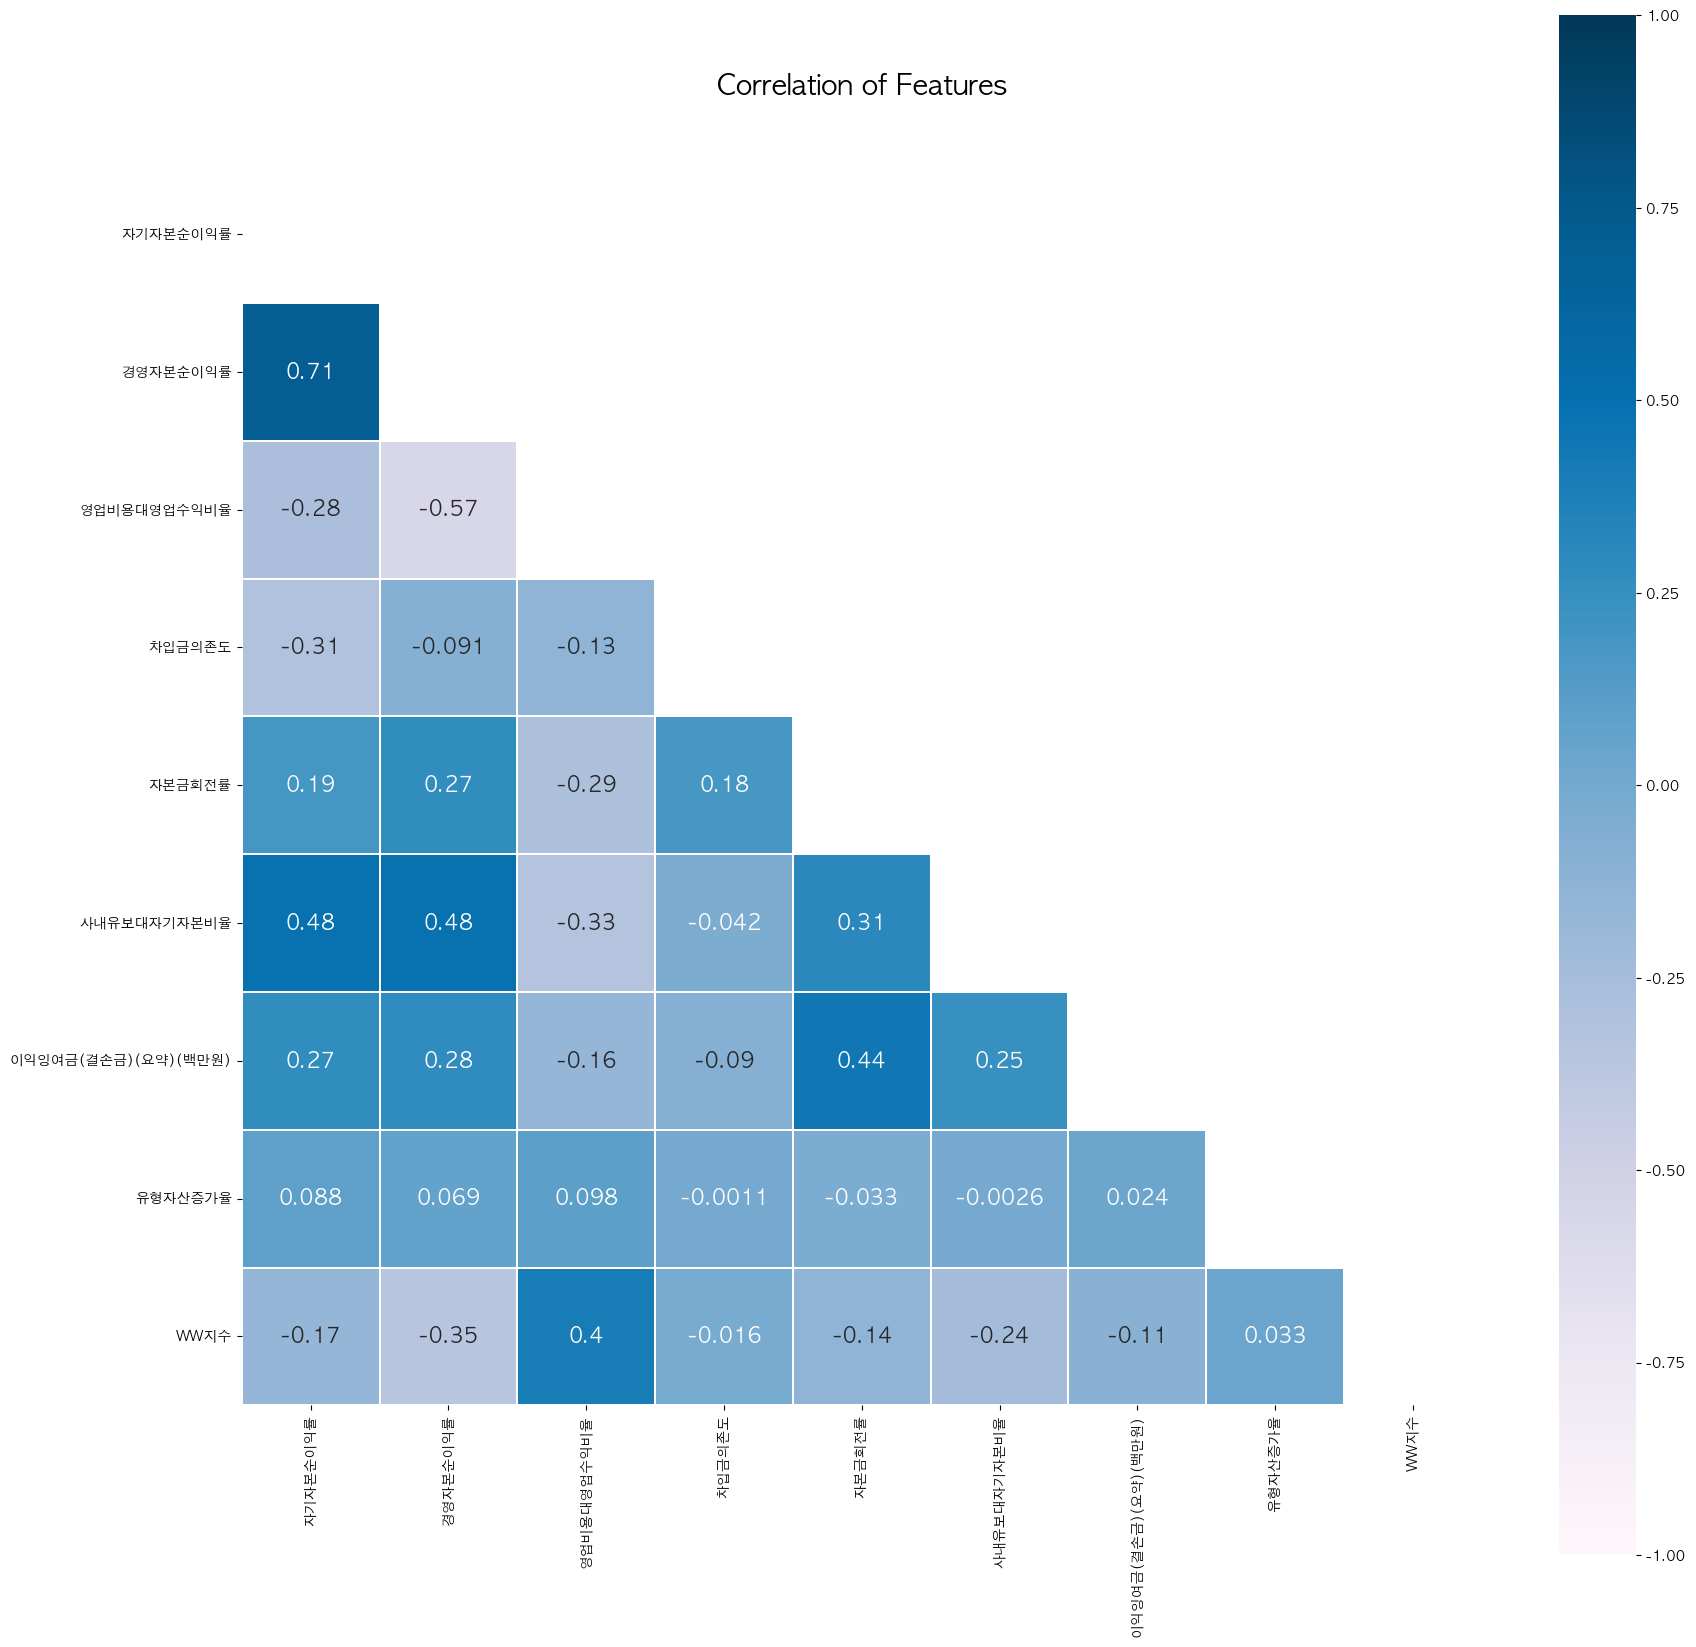

In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
warnings.filterwarnings(action='ignore')

# plt.rcParams['font.family'] = 'Malgun Gothic'
df_corr = df_fs.corr()

mask = np.zeros_like(df_corr, dtype=np.bool)
mask[np.triu_indices_from(mask)] = True


colormap = plt.cm.PuBu
plt.figure(figsize=(20, 20))
plt.rcParams['axes.unicode_minus'] = False
plt.rc('font', family='AppleGothic')
plt.title("Correlation of Features", y = 1.05, size = 20)
sns.heatmap(df_fs.astype(float).corr(), linewidths = 0.1, mask=mask ,vmax = 1.0, 
            vmin= -1.0 , square = True, cmap = colormap, linecolor = "white", annot = True, annot_kws = {"size" : 15})

---
# Modeling

## 1. 최종피쳐로 구성된 데이터 가져오기

In [ ]:
X_train = x_train_stan[list_feature_final]
y_train = y_train
X_test = x_test_stan[list_feature_final]
y_test = y_test

## 2. Resampling(안씀)

<img width="814" alt="image" src="https://user-images.githubusercontent.com/88031549/236773512-8e7f0ed8-ad01-4486-a096-d4e216b1b4e1.png">

## 3. Modeling

<img width="1224" alt="image" src="https://user-images.githubusercontent.com/88031549/236773859-60c4229b-cc31-489c-82ca-cf3508851ccf.png">

In [ ]:
# from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score, recall_score, precision_score , f1_score, roc_auc_score, confusion_matrix
from sklearn.linear_model import LogisticRegression
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.naive_bayes import BernoulliNB
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from lightgbm import LGBMClassifier # 컬럼명 바꿔서 돌려야함(특수문자는 아스키문자로 변환 안됌)

### 1) 하이퍼파라미터 조정 전 성능

<img width="791" alt="image" src="https://user-images.githubusercontent.com/88031549/236774511-376438ee-b32e-46c8-af87-f1e01453992c.png">

### 2) 하이퍼파라미터 튜닝 후

<img width="1287" alt="스크린샷 2023-01-04 오후 2 16 37" src="https://user-images.githubusercontent.com/88031549/210489080-3150d741-d2b7-4e9d-bf12-117d0b3b4a09.png">


<img width="1330" alt="스크린샷 2023-01-03 오후 2 33 28" src="https://user-images.githubusercontent.com/88031549/210304646-cdf3ca6f-49b3-4d1a-862b-21414115b666.png">

<img width="1321" alt="스크린샷 2023-01-03 오후 2 33 34" src="https://user-images.githubusercontent.com/88031549/210304662-90db68cd-7546-4a32-afdb-612cac2243a8.png">

### 3) Modeling

##### 1. Logistic

In [ ]:
model_LR = LogisticRegression(C=0.001, penalty='l2', solver="liblinear")

##### 2. KNN

In [ ]:
model_KNN = KNeighborsClassifier(n_neighbors=15, weights='uniform', metric='manhattan')

##### 3. DT

In [ ]:
model_DT = DecisionTreeClassifier(min_samples_leaf=1, max_depth=2, min_samples_split=2) # 최적

##### 4. NB

In [ ]:
model_NB = BernoulliNB(alpha=1, fit_prior=False, class_prior=None, binarize=0)

##### 5. SVM

In [ ]:
model_SVC = SVC(C=10, gamma=0.1, kernel='rbf', degree=4, probability=True)

##### 6. RF - 여기서부터 앙상블

In [ ]:
model_RF = RandomForestClassifier(n_estimators=10, max_depth=10	, min_samples_leaf=2, min_samples_split=2)

##### 7. XGB

In [ ]:
model_XGB = XGBClassifier(random_state=1, min_child_weight=1, gamma=2, subsample=1, colsample_bytree=1, max_depth=6, learning_rate=0.15)

##### 8. LGBM

In [ ]:
model_LGBM = LGBMClassifier(n_estimators=100, max_depth=-1, min_data_in_leaf=8)

##### 9. Voting
- Logistic
- DT
- RF
- XGB
- LGBM

In [ ]:
# LGBM은 컬럼명에 특수문자 있으면 안돌아가서 rename해줌
X_train_re = X_train.copy()
X_test_re = X_test.copy()

X_train_re.columns = list(range(1,len(X_train.columns)+1))
X_test_re.columns = list(range(1,len(X_train.columns)+1))

In [ ]:
from sklearn.ensemble import VotingClassifier

rdict={'model':[],'acc_train':[], 'auc_train':[], 'acc_val':[],'precision':[],'recall':[],'f1_score':[], 'AUC_val':[]}

estimators = [['lr', model_LR],
            ['dt', model_DT],
            ['rf', model_RF],
            ['xgb', model_XGB],
            ['lgbm', model_LGBM]]

SV = VotingClassifier(estimators, voting="soft",n_jobs=-1)
SV.fit(X_train_re, y_train)

y_hat = SV.predict(X_train_re)
results_train  = (round(accuracy_score(y_train,y_hat),2),round(roc_auc_score(y_train,y_hat),2))
#2열:Val
y_hat = SV.predict(X_test_re)
results = (round(accuracy_score(y_test,y_hat),2),
                round(precision_score(y_test,y_hat),2),
                round(recall_score(y_test,y_hat),2),
                round(f1_score(y_test,y_hat),2),
                round(roc_auc_score(y_test,y_hat),2))

rdict['model'].append(SV); 
rdict['acc_train'].append(results_train[0])
rdict['auc_train'].append(results_train[1])

rdict['acc_val'].append(results[0])
rdict['precision'].append(results[1])
rdict['recall'].append(results[2])
rdict['f1_score'].append(results[3])
rdict['AUC_val'].append(results[4])

rdf = pd.DataFrame(data=rdict)
rdf 

/Users/kyle/opt/anaconda3/lib/python3.8/site-packages/xgboost/compat.py:31: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


[LightGBM] [Warning] min_data_in_leaf is set=8, min_child_samples=20 will be ignored. Current value: min_data_in_leaf=8
[13:33:43] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


/Users/kyle/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:888: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)
/Users/kyle/opt/anaconda3/lib/python3.8/site-packages/xgboost/data.py:192: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  from pandas import MultiIndex, Int64Index


model  acc_train  auc_train  \
0  VotingClassifier(estimators=[['lr',\n         ...       0.98       0.97   

   acc_val  precision  recall  f1_score  AUC_val  
0      0.7        0.7    0.97      0.81     0.53

In [ ]:
model_voting = VotingClassifier(estimators, voting="soft",n_jobs=-1)

##### 10. Stacking

In [ ]:
# LGBM은 컬럼명에 특수문자 있으면 안돌아가서 rename해줌
X_train_re = X_train.copy()
X_test_re = X_test.copy()

X_train_re.columns = list(range(1,len(X_train.columns)+1))
X_test_re.columns = list(range(1,len(X_train.columns)+1))

In [ ]:
# 개별모델 내부에서 CV 적용해 Stacking하는 함수 구현
from sklearn.model_selection import KFold

def get_stacking_datasets(model):

    # 최종 메타 모델이 사용할 학습 데이터 반환을 위해서 넘파이 배열을 0으로 만들어서 초기화
    train_fold_pred = np.zeros((X_train_re.shape[0], 1)) # 2차원으로
    test_pred = np.zeros((X_test_re.shape[0], 5)) # n_splits=5
    print(model.__class__.__name__, '모델 시작')
    
    for folder_counter, (train_idx, valid_idx) in enumerate(KFold(n_splits=5, shuffle=True, random_state=42).split(X_train_re)):
        # 개별 모델 내부에서 학습하고 1개의 fold로 예측할 데이터 셋 추출
        print(f" Fold 횟수 : {folder_counter+1}")
        X_train_ = X_train_re.iloc[train_idx]
        y_train_ = y_train.iloc[train_idx]
        X_test_ = X_train_re.iloc[valid_idx]
        
        # 개별 모델이 학습한 후 1개의 fold데이터셋으로 예측값 반환 후 최종 메타모델이 학습할 데이터셋에 첨가
        model.fit(X_train_, y_train_)
        train_fold_pred[valid_idx, :] = model.predict(X_test_).reshape(-1,1)
        # 개별 모델이 원본 데이터셋의 검증 데이터셋을 기반으로 예측 결과값 반환 후 최종 메타모델이 검증할 데이터셋에 첨가
        test_pred[:, folder_counter] = model.predict(X_test_re)
    
    # 개별모델안에서 테스트 데이터셋을 기반으로 예측한 결과값들 mean취해주고 2차원으로 바꾸어주기
    test_pred_mean = np.mean(test_pred, axis=1).reshape(-1,1)
    
    return train_fold_pred, test_pred_mean

In [ ]:
LR_train, LR_test = get_stacking_datasets(model_LR)
DT_train, DT_test = get_stacking_datasets(model_DT)
RF_train, RF_test = get_stacking_datasets(model_RF)
LGBM_train, LGBM_test = get_stacking_datasets(model_LGBM)

new_X_train = np.concatenate((LR_train, DT_train, RF_train, LGBM_train), axis = 1)
new_X_test = np.concatenate(( LR_test, DT_test,  RF_test, LGBM_test), axis = 1)

# meta learner
model_XGB.fit(new_X_train, y_train)
y_test = pd.DataFrame(y_test)
y_hat_train = pd.DataFrame(model_XGB.predict(new_X_train))
y_hat = pd.DataFrame(model_XGB.predict(new_X_test))

In [ ]:
rdict={'model':[], "acc_train":[], "auc_train":[], 'acc_test':[],'precision':[],'recall':[],'f1_score':[], 'AUC_test':[]}

results_train  = (round(accuracy_score(y_train,y_hat_train),2),round(roc_auc_score(y_train,y_hat_train),2))

results = (round(accuracy_score(y_test,y_hat),2),
                round(precision_score(y_test,y_hat),2),
                round(recall_score(y_test,y_hat),2),
                round(f1_score(y_test,y_hat),2),
                round(roc_auc_score(y_test,y_hat),2))

rdict['model'].append(SV); 
rdict['acc_train'].append(results_train[0])
rdict['auc_train'].append(results_train[1])
rdict['acc_test'].append(results[0])
rdict['precision'].append(results[1])
rdict['recall'].append(results[2])
rdict['f1_score'].append(results[3])
rdict['AUC_test'].append(results[4])

rdf_stacking = pd.DataFrame(data=rdict)
rdf_stacking 

model  acc_train  auc_train  \
0  VotingClassifier(estimators=[['lr',\n         ...       0.73        0.5   

   acc_test  precision  recall  f1_score  AUC_test  
0      0.69       0.69     1.0      0.82       0.5

##### 11. Tabnet - 여기서부터 딥러닝

In [ ]:
# !pip install pytorch_tabnet
# !pip install optuna

In [ ]:
import os
import numpy as np
import pandas as pd
from sklearn.metrics import roc_auc_score
from sklearn.preprocessing import LabelEncoder
from matplotlib import pyplot as plt

import torch
import torch.nn as nn
from pytorch_tabnet.tab_model import TabNetClassifier

from sklearn.model_selection import train_test_split

import optuna
from sklearn.model_selection import KFold

In [ ]:
X = X_train.values
y = y_train.values

In [ ]:
def Objective(trial):
    mask_type = trial.suggest_categorical("mask_type", ["entmax", "sparsemax"])
    n_da = trial.suggest_int("n_da", 56, 64, step=4)
    n_steps = trial.suggest_int("n_steps", 1, 3, step=1)
    gamma = trial.suggest_float("gamma", 1., 1.4, step=0.2)
    n_shared = trial.suggest_int("n_shared", 1, 3)
    lambda_sparse = trial.suggest_float("lambda_sparse", 1e-6, 1e-3, log=True)
    tabnet_params = dict(n_d=n_da, n_a=n_da, n_steps=n_steps, gamma=gamma,
                    lambda_sparse=lambda_sparse, optimizer_fn=torch.optim.Adam,
                    optimizer_params=dict(lr=2e-2, weight_decay=1e-5),
                    mask_type=mask_type, n_shared=n_shared,
                    scheduler_params=dict(mode="min",
                                        patience=trial.suggest_int("patienceScheduler",low=3,high=10), # changing sheduler patience to be lower than early stopping patience 
                                        min_lr=1e-5,
                                        factor=0.5,),
                    scheduler_fn=torch.optim.lr_scheduler.ReduceLROnPlateau,
                    verbose=0,
                    ) #early stopping
    kf = KFold(n_splits=3, random_state=42, shuffle=True)
    CV_score_array    =[]
    for train_index, test_index in kf.split(X):
        X_train, X_valid = X[train_index], X[test_index]
        y_train, y_valid = y[train_index], y[test_index]
        clf = TabNetClassifier(**tabnet_params)
        clf.fit(X_train=X_train, y_train=y_train,
                eval_set=[(X_valid, y_valid)],
                patience=trial.suggest_int("patience",low=15,high=30), max_epochs=trial.suggest_int('epochs', 1, 100),
                eval_metric=['auc'])
        CV_score_array.append(clf.best_cost)
    avg = np.mean(CV_score_array)
    return avg

In [ ]:
study = optuna.create_study(direction="maximize", study_name='TabNet optimization')
study.optimize(Objective, n_trials=20) # timeout=6*60

In [ ]:
TabNet_params = study.best_params

In [ ]:
print(TabNet_params)

{'mask_type': 'entmax', 'n_da': 56, 'n_steps': 2, 'gamma': 1.4, 'n_shared': 1, 'lambda_sparse': 2.3808040718731446e-06, 'patienceScheduler': 6, 'patience': 15, 'epochs': 64}


In [ ]:
final_params = dict(n_d=TabNet_params['n_da'], n_a=TabNet_params['n_da'], n_steps=TabNet_params['n_steps'], gamma=TabNet_params['gamma'],
                    lambda_sparse=TabNet_params['lambda_sparse'], optimizer_fn=torch.optim.Adam,
                    optimizer_params=dict(lr=2e-2, weight_decay=1e-5),
                    mask_type=TabNet_params['mask_type'], n_shared=TabNet_params['n_shared'],
                    scheduler_params=dict(mode="min",
                                        patience=TabNet_params['patienceScheduler'],
                                        min_lr=1e-5,
                                        factor=0.5,),
                    scheduler_fn=torch.optim.lr_scheduler.ReduceLROnPlateau,
                    verbose=0,
                    )
epochs = TabNet_params['epochs']

In [ ]:
clf = TabNetClassifier(**final_params)
clf.fit(X_train=X, y_train=y,
          patience=TabNet_params['patience'], max_epochs=epochs,
          eval_metric=['auc'])

In [ ]:
# train
X_train_re = X_train.values
dt1_pred_train = clf.predict(X_train_re)

# test
X_test_re = X_test.values
dt1_pred = clf.predict(X_test_re)

In [ ]:
rdict={'model':[], "acc_train":[], "auc_train":[], 'acc_test':[],'precision':[],'recall':[],'f1_score':[], 'AUC_test':[]}

results_train  = (round(accuracy_score(y_train,dt1_pred_train),2),round(roc_auc_score(y_train,dt1_pred_train),2))

results = (round(accuracy_score(y_test,dt1_pred),2),
                round(precision_score(y_test,dt1_pred),2),
                round(recall_score(y_test,dt1_pred),2),
                round(f1_score(y_test,dt1_pred),2),
                round(roc_auc_score(y_test,dt1_pred),2))

rdict['model'].append(SV)
rdict['acc_train'].append(results_train[0])
rdict['auc_train'].append(results_train[1])
rdict['acc_test'].append(results[0])
rdict['precision'].append(results[1])
rdict['recall'].append(results[2])
rdict['f1_score'].append(results[3])
rdict['AUC_test'].append(results[4])

rdf_tabnet = pd.DataFrame(data=rdict)
rdf_tabnet

model  acc_train  auc_train  \
0  VotingClassifier(estimators=[['lr',\n         ...       0.66       0.49   

   acc_test  precision  recall  f1_score  AUC_test  
0      0.63       0.68    0.85      0.76      0.49

##### 12. DNN

In [ ]:
# 딥러닝을 구동하는 데 필요한 케라스 함수 불러오기
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense

# 필요한 라이브러리 불러오기
import numpy
import tensorflow as tf

# 실행할 때마다 같은 결과를 출력하기 위해 설정하는 부분
numpy.random.seed(3)
tf.random.set_seed(3)

In [ ]:
# 모델을 설정
# 딥러닝 모델에 은닉층 추가할 때는 model.add() 함수 이용
DL_ANN = Sequential()
DL_ANN.add(Dense(12, input_dim=9, activation='relu'))
DL_ANN.add(Dense(8, activation='relu'))
DL_ANN.add(Dense(1, activation='sigmoid'))

# 모델을 컴파일합니다.
DL_ANN.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# 모델 실행
History = DL_ANN.fit(X_train, y_train, epochs=400, batch_size=5)

# Test 결과 출력
print('\n Accuracy : %.4f' % (DL_ANN.evaluate(X_test, y_test)[1]))

In [ ]:
# Test 결과 출력
print('\n Accuracy : %.4f' % (DL_ANN.evaluate(X_test, y_test)[1]))

6/6 [==============================] - 0s 1ms/step - loss: 0.9024 - accuracy: 0.6552

 Accuracy : 0.6552


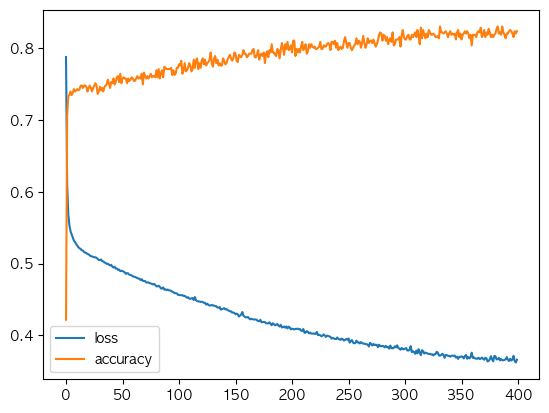

In [ ]:
loss = History.history["loss"]
acc = History.history["accuracy"]

import matplotlib.pyplot as plt
plt.plot(loss, label="loss")
plt.plot(acc, label="accuracy")
plt.legend()
plt.show()

In [ ]:
# 최적 에폭 찾기
epochs_list = [100,200,400,800] # 결과적으로 400이 좋음, 이후 과적합되어 test acc 떨어짐
평가리스트 = []
for i in epochs_list:
    # 모델 설정
    model = Sequential()
    model.add(Dense(12, input_dim=9, activation='relu'))
    model.add(Dense(8, activation='relu'))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy',
                    optimizer='adam',
                    metrics= ['accuracy'])

    History = model.fit(X_train, y_train, epochs=i, batch_size=5)
    fit_acc = History.history["accuracy"][-1]
    acc = model.evaluate(X_test, y_test)[1]
    result = fit_acc, acc
    
    평가리스트.append(result)

In [ ]:
평가리스트

[(0.7693575024604797, 0.6839080452919006),
 (0.8319604396820068, 0.6206896305084229),
 (0.8764415383338928, 0.6724137663841248),
 (0.8583195805549622, 0.6091954112052917)]

결과값 출력 및 평가

In [ ]:
def DL_predict(model, data):
    y_pred = model.predict(data)
    y_pred = list(map(int, np.round(y_pred,0))) # 0.5를 기준으로 0,1로 라벨링(딥러닝은 예측결과가 확률로 나옴)
    y_pred = np.transpose(y_pred)
    return y_pred

In [ ]:
# train
y_pred_train = DL_predict(DL_ANN, X_train)

# test
y_pred_test = DL_predict(DL_ANN, X_test)

In [ ]:
rdict={'model':[], "acc_train":[], "auc_train":[], 'acc_test':[],'precision':[],'recall':[],'f1_score':[], 'AUC_test':[]}

results_train  = (round(accuracy_score(y_train,y_pred_train),2),round(roc_auc_score(y_train,y_pred_train),2))

results = (round(accuracy_score(y_test,y_pred_test),2),
                round(precision_score(y_test,y_pred_test),2),
                round(recall_score(y_test,y_pred_test),2),
                round(f1_score(y_test,y_pred_test),2),
                round(roc_auc_score(y_test,y_pred_test),2))

SV = DL_ANN
rdict['model'].append(SV)
rdict['acc_train'].append(results_train[0])
rdict['auc_train'].append(results_train[1])
rdict['acc_test'].append(results[0])
rdict['precision'].append(results[1])
rdict['recall'].append(results[2])
rdict['f1_score'].append(results[3])
rdict['AUC_test'].append(results[4])

rdf_tabnet = pd.DataFrame(data=rdict)
rdf_tabnet

model  acc_train  auc_train  \
0  <keras.engine.sequential.Sequential object at ...       0.83       0.73   

   acc_test  precision  recall  f1_score  AUC_test  
0      0.66       0.71    0.83      0.77      0.55

### 4) 하이퍼파라미터 튜닝 후(Final)
- Feature selection : 3번 중복(ttest, stepwise, Lasso, kbest)
- scaling : Standard scaling
- Data split : train(2012~2016) / test(2017,2018)
- model : 총 12개
> #### 최종 모델 : XGB

In [ ]:
# LGBM은 컬럼명에 특수문자 있으면 안돌아가서 rename해줌
X_train_re = X_train.copy()
X_test_re = X_test.copy()

X_train_re.columns = list(range(1,len(X_train.columns)+1))
X_test_re.columns = list(range(1,len(X_train.columns)+1))

In [ ]:
models = [
    model_LR,
    model_KNN,
    model_DT,
    model_NB,
    model_SVC,
    model_RF,
    model_XGB,   # 최종모델
    model_LGBM,
    model_voting
]

rdict={'model':[],'acc_train':[], 'auc_train':[], 'acc_test':[],'precision':[],'recall':[],'f1_score':[], 'AUC_test':[]}


for clf in models:
    clf = clf.fit(X_train_re, y_train)
#1열:Train
    y_hat = clf.predict(X_train_re)
    results_train  = (round(accuracy_score(y_train,y_hat),2),round(roc_auc_score(y_train,y_hat),2))
#2열:Test
    y_hat = clf.predict(X_test_re)
    results = (round(accuracy_score(y_test,y_hat),2),
                    round(precision_score(y_test,y_hat),2),
                    round(recall_score(y_test,y_hat),2),
                    round(f1_score(y_test,y_hat),2),
                    round(roc_auc_score(y_test,y_hat),2))

    rdict['model'].append(clf); 
    rdict['acc_train'].append(results_train[0])
    rdict['auc_train'].append(results_train[1])
    
    rdict['acc_test'].append(results[0])
    rdict['precision'].append(results[1])
    rdict['recall'].append(results[2])
    rdict['f1_score'].append(results[3])
    rdict['AUC_test'].append(results[4])   

    print(results_train, results)

rdf_final = pd.DataFrame(data=rdict)

In [ ]:
rdf_final = pd.concat([rdf_final, rdf_stacking, rdf_tabnet], axis=0)
rdf_final.reset_index(drop=True, inplace=True)
rdf_final["model"] = ["Logistic", "KNN", "Decision Tree", "Naive Bayes", "SVC", "RandomForest", "XGB", "LGBM", "Voting", "Stacking", "TabNet"]
rdf_final.columns = ['model', 'acc_train', 'auc_train', 'acc_test', 'precision_test', 'recall_test', 'f1_score_test', 'AUC_test']
rdf_final

model  acc_train  auc_train  acc_test  precision_test  \
0        Logistic       0.71       0.57      0.71            0.75   
1             KNN       0.75       0.58      0.69            0.71   
2   Decision Tree       0.74       0.54      0.68            0.69   
3     Naive Bayes       0.58       0.63      0.56            0.77   
4             SVC       0.78       0.60      0.71            0.71   
5    RandomForest       0.93       0.89      0.70            0.72   
6             XGB       0.93       0.87      0.73            0.73   
7            LGBM       1.00       1.00      0.71            0.72   
8          Voting       0.99       0.98      0.69            0.70   
9        Stacking       0.73       0.50      0.69            0.69   
10         TabNet       0.66       0.49      0.63            0.68   

    recall_test  f1_score_test  AUC_test  
0          0.88           0.81      0.61  
1          0.93           0.81      0.54  
2          0.98           0.81      0.50  
3          0.52           0.62      0.58  
4          0.98           0.82      0.55  
5          0.92           0.81      0.56  
6          0.97           0.83      0.59  
7          0.94           0.82      0.56  
8          0.97           0.81      0.52  
9          1.00           0.82      0.50  
10         0.85           0.76      0.49

In [ ]:
models = [model_XGB]   # 최종모델

rdict={'model':[],'acc_train':[], 'auc_train':[], 'acc_test':[],'precision':[],'recall':[],'f1_score':[], 'AUC_test':[]}


for clf in models:
    clf = clf.fit(X_train_re, y_train)
#1열:Train
    y_hat = clf.predict(X_train_re)
    results_train  = (round(accuracy_score(y_train,y_hat),2),round(roc_auc_score(y_train,y_hat),2))
#2열:Test
    y_hat = clf.predict(X_test_re)
    results = (round(accuracy_score(y_test,y_hat),2),
                    round(precision_score(y_test,y_hat),2),
                    round(recall_score(y_test,y_hat),2),
                    round(f1_score(y_test,y_hat),2),
                    round(roc_auc_score(y_test,y_hat),2))

    rdict['model'].append(clf); 
    rdict['acc_train'].append(results_train[0])
    rdict['auc_train'].append(results_train[1])
    
    rdict['acc_test'].append(results[0])
    rdict['precision'].append(results[1])
    rdict['recall'].append(results[2])
    rdict['f1_score'].append(results[3])
    rdict['AUC_test'].append(results[4])   

    print(results_train, results)

rdf_final = pd.DataFrame(data=rdict)
rdf_final

[14:25:04] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.
(0.93, 0.87) (0.73, 0.73, 0.97, 0.83, 0.59)


model  acc_train  auc_train  \
0  XGBClassifier(base_score=0.5, booster='gbtree'...       0.93       0.87   

   acc_test  precision  recall  f1_score  AUC_test  
0      0.73       0.73    0.97      0.83      0.59

accuracy score : 0.730
precision score : 0.730
recall score : 0.967
f1 score : 0.832
roc score : 0.585


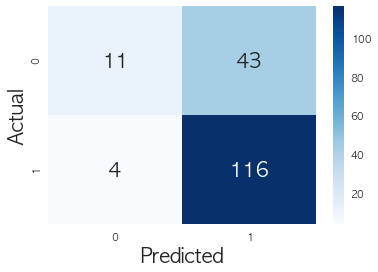

In [ ]:
from sklearn.metrics import accuracy_score, recall_score, precision_score , f1_score, roc_auc_score, confusion_matrix

# confusion matrix 만드는 함수
def score(y_test, pred):
    # score print
    print('accuracy score : {0:.3f}'.format(accuracy_score(y_test, pred)))
    print('precision score : {0:.3f}'.format(precision_score(y_test, pred)))
    print('recall score : {0:.3f}'.format(recall_score(y_test, pred)))
    print('f1 score : {0:.3f}'.format(f1_score(y_test, pred)))
    print('roc score : {0:.3f}'.format(roc_auc_score(y_test, pred)))
    # confusion matirx 함수
    cm = confusion_matrix(y_test, pred)
    sns.heatmap(cm, annot=True, annot_kws={"size": 20}, cmap='Blues', fmt='g')
    plt.xlabel('Predicted', fontsize=20)
    plt.ylabel('Actual', fontsize=20)
    
score(y_test, y_hat)

---
# Final Model Evaluating

## Feature Imfortance

[14:25:05] WARNING: /opt/concourse/worker/volumes/live/7a2b9f41-3287-451b-6691-43e9a6c0910f/volume/xgboost-split_1619728204606/work/src/learner.cc:1061: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


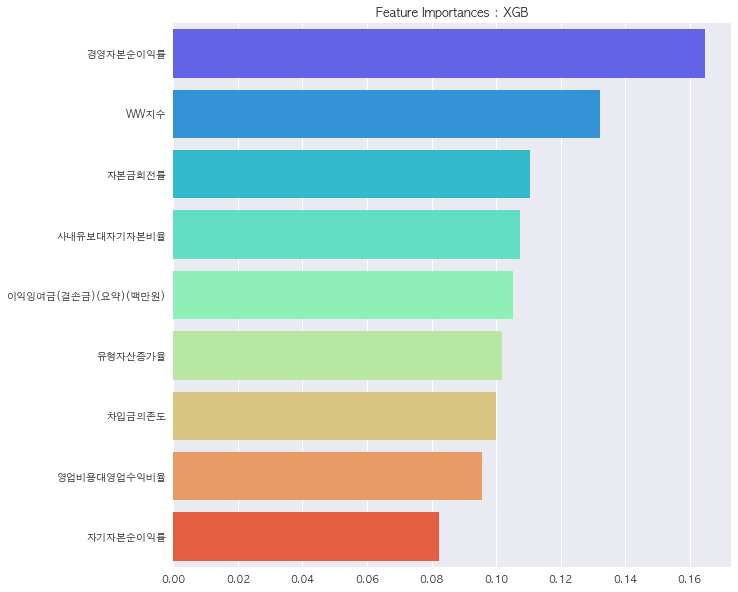

In [ ]:
plt.rcParams['axes.unicode_minus'] = False
plt.rcParams["font.family"] = "AppleGothic"
model_XGB.fit(X_train, y_train)
#feature 중요도도 그려볼 수 있다. 
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline

df_non_label = X_train
# del df_non_label["Delay_from_due_date"]
# df_non_label.columns

feature_importances_values = model_XGB.feature_importances_
feature_importances = pd.Series(feature_importances_values, index=df_non_label.columns)
feature_importances_top20 = feature_importances.sort_values(ascending=False)[:10] #중요한 순서로 정렬 후 top 10개만 뽑아 시각화

plt.figure(figsize=(10, 10))
plt.title('Feature Importances : XGB')
sns.barplot(x=feature_importances_top20, y=feature_importances_top20.index, palette="rainbow")
plt.show()

## Shapely Value

In [ ]:
import shap

shap.initjs()
explainer = shap.TreeExplainer(model_XGB)
shap_values = explainer.shap_values(X_train)
shap.force_plot(explainer.expected_value, shap_values[0, :], X_train.iloc[0, :])

In [ ]:
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values, X_train)

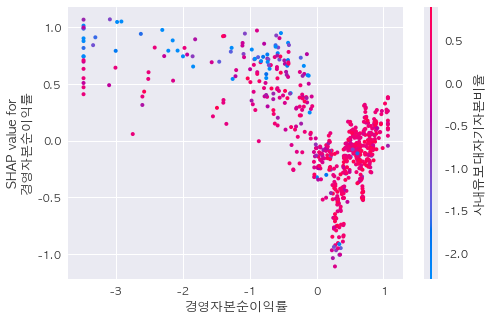

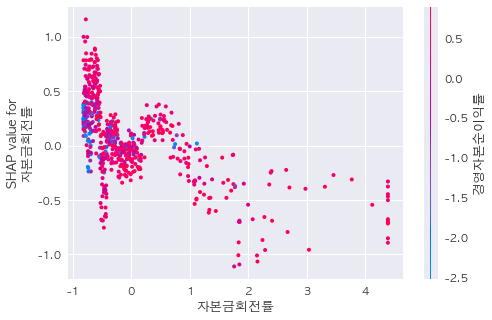

In [ ]:
shap.initjs()
# 총 13개 특성의 Shapley value를 절댓값 변환 후 각 특성마다 더함 -> np.argsort()는 작은 순서대로 정렬, 큰 순서대로 정렬하려면
# 앞에 마이너스(-) 기호를 붙임
top_inds = np.argsort(-np.sum(np.abs(shap_values), 0))

# 영향력 top 2 컬럼
for i in range(2):
    shap.dependence_plot(top_inds[i], shap_values, X_train)

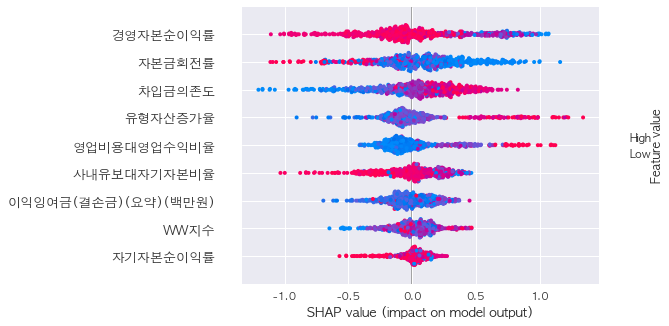

In [ ]:
shap.summary_plot(shap_values, X_train)

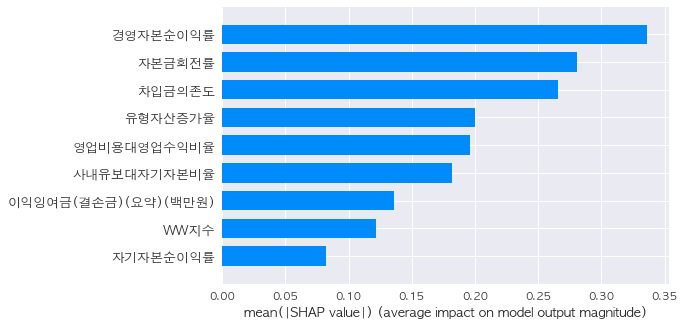

In [ ]:
shap.summary_plot(shap_values, X_train, plot_type='bar')

---
# 회생기업 투자

## 1. 투자흐름도

<img width="1416" alt="image" src="https://user-images.githubusercontent.com/88031549/236778066-0aac2151-79ef-4110-832d-0193ce9e5764.png">

## 2. 투자대상인 회생기업 리스트 뽑기
- 위 오차행렬에서 0으로 예측한 15개의 기업을 대상으로 투자

In [ ]:
x_test_predict = pd.concat([X_train, X_test], axis=0)
y_test_predict = pd.concat([y_train, y_test], axis=0)

predict_index = pd.concat([train_set_index,test_set_index], axis=0)
predict_index.reset_index(drop=True, inplace=True)
predict_index

In [ ]:
# 최종모델
clf = XGBClassifier(random_state=1, min_child_weight=1, gamma=2, subsample=1, colsample_bytree=1, max_depth=5, learning_rate=0.1)
clf.fit(X_train, y_train)
y_hat = clf.predict(x_test_predict)

In [ ]:
predict = pd.concat([predict_index, pd.Series(y_hat)], axis=1)
predict.columns = ["거래소코드", "회계년도", "예측_한계기업여부"]

predict = pd.merge(predict, df_부실징후, on=["거래소코드","회계년도"], how="left")
predict = predict[predict["예측_한계기업여부"]==False]
predict.drop("예측_한계기업여부", axis=1, inplace=True)
predict.sort_values(by="회계년도", inplace=True)
predict.reset_index(drop=True, inplace=True)
predict.to_excel("./datasets/예상회생기업.xlsx")
predict

## 3. 비중계산(샤프지수 최대화, 리스크 최소화)

### 연간 투자종목 조회

In [ ]:
df=pd.read_excel('./datasets/investing/투자종목_2012.xlsx', index_col=0)
df["거래소코드"] = df["거래소코드"].map(padding)
df=pd.DataFrame(df['거래소코드'].unique())
df.rename(columns={0:'거래소코드'}, inplace=True)
df

거래소코드
0   011080
1   052770
2   020120
3   066700
4   035460
5   039740
6   096040
7   052300
8   007720
9   134060
10  004870
11  001780

### 1) t-1년도의 일별 종가

> ### 2012년도에는 2012/04/01~2013/03/31에 투자하기에 해당기간 데이터 필요

In [ ]:
n=20
sigma = 2
df_marko=[]

for i in df.index:
    df_market = stock.get_market_ohlcv("20120401", "20130331", df.loc[i,"거래소코드"])
    df_market["거래소코드"] = df.loc[i,"거래소코드"]
    df_market["center"] = df_market['종가'].rolling(n).mean()
    df_market["ub"] = df_market['center'] + sigma*df_market['종가'].rolling(n).std()
    df_market["lb"] = df_market['center'] - sigma*df_market['종가'].rolling(n).std()
    df_marko.append(df_market)

In [ ]:
df_marko = pd.concat(df_marko)
df_marko['PB'] = (df_marko['종가'] - df_marko['lb']) / (df_marko['ub'] - df_marko['lb'])
df_marko.reset_index(drop=False, inplace=True)
df_marko=df_marko.pivot(index='날짜', columns='거래소코드', values='종가')
df_marko

거래소코드       001780  004870  007720  011080  020120  035460  039740  052300  \
날짜                                                                           
2012-04-02    2590    3100    4545    1300    1600    1980    3200     574   
2012-04-03    2600    3100    4430    1370    1840    1980    3370     571   
2012-04-04    2545    3100    4340    1340    1850    1950    3330     597   
2012-04-05    2510    3100    4835    1330    1990    1980    3320     610   
2012-04-06    2495    3100    4515    1360    1900    1925    3340     608   
...            ...     ...     ...     ...     ...     ...     ...     ...   
2013-03-25    2350    1790    3330    1510    2430    2500    4600    1030   
2013-03-26    2305    1745    3340    1650    2510    2380    4630    1030   
2013-03-27    2310    1815    3345    1645    2435    2450    4655    1020   
2013-03-28    2335    1835    3270    1630    2495    2400    4455    1035   
2013-03-29    2355    1790    3310    1590    2505    2450    4420    1060   

거래소코드       052770  066700  096040  134060  
날짜                                          
2012-04-02    2675    7650    2120    3955  
2012-04-03    2640    7750    2210    3980  
2012-04-04    2490    7550    2250    3925  
2012-04-05    2525    7460    2395    3775  
2012-04-06    2555    7450    2220    3785  
...            ...     ...     ...     ...  
2013-03-25    4005   11500    3465    3315  
2013-03-26    4110   11450    3475    3300  
2013-03-27    4040   11100    3630    3315  
2013-03-28    4050   11250    4170    3305  
2013-03-29    4015   11500    4165    3345  

[247 rows x 12 columns]

### 2) pct change(종목별 일별수익률)

In [ ]:
daily_ret = df_marko.pct_change()
daily_ret

거래소코드         001780    004870    007720    011080    020120    035460  \
날짜                                                                       
2012-04-02       NaN       NaN       NaN       NaN       NaN       NaN   
2012-04-03  0.003861  0.000000 -0.025303  0.053846  0.150000  0.000000   
2012-04-04 -0.021154  0.000000 -0.020316 -0.021898  0.005435 -0.015152   
2012-04-05 -0.013752  0.000000  0.114055 -0.007463  0.075676  0.015385   
2012-04-06 -0.005976  0.000000 -0.066184  0.022556 -0.045226 -0.027778   
...              ...       ...       ...       ...       ...       ...   
2013-03-25  0.058559 -0.005556 -0.007452  0.041379  0.104545  0.033058   
2013-03-26 -0.019149 -0.025140  0.003003  0.092715  0.032922 -0.048000   
2013-03-27  0.002169  0.040115  0.001497 -0.003030 -0.029880  0.029412   
2013-03-28  0.010823  0.011019 -0.022422 -0.009119  0.024641 -0.020408   
2013-03-29  0.008565 -0.024523  0.012232 -0.024540  0.004008  0.020833   

거래소코드         039740    052300    052770    066700    096040    134060  
날짜                                                                      
2012-04-02       NaN       NaN       NaN       NaN       NaN       NaN  
2012-04-03  0.053125 -0.005226 -0.013084  0.013072  0.042453  0.006321  
2012-04-04 -0.011869  0.045534 -0.056818 -0.025806  0.018100 -0.013819  
2012-04-05 -0.003003  0.021776  0.014056 -0.011921  0.064444 -0.038217  
2012-04-06  0.006024 -0.003279  0.011881 -0.001340 -0.073069  0.002649  
...              ...       ...       ...       ...       ...       ...  
2013-03-25  0.009879 -0.019048 -0.001247  0.000000  0.022124  0.000000  
2013-03-26  0.006522  0.000000  0.026217 -0.004348  0.002886 -0.004525  
2013-03-27  0.005400 -0.009709 -0.017032 -0.030568  0.044604  0.004545  
2013-03-28 -0.042965  0.014706  0.002475  0.013514  0.148760 -0.003017  
2013-03-29 -0.007856  0.024155 -0.008642  0.022222 -0.001199  0.012103  

[247 rows x 12 columns]

### 3) annuar_ret(일별수익률의 공분산)

In [ ]:
annual_ret = daily_ret.mean()*252 # 연간 수익률(아래 비중 계산에 사용됨)
daily_cov = daily_ret.cov()
annual_cov = daily_cov * 252
annual_cov

거래소코드     001780    004870    007720    011080    020120    035460    039740  \
거래소코드                                                                          
001780  0.109861  0.008249  0.014808  0.026703  0.022433  0.026807  0.037839   
004870  0.008249  0.572648  0.000267 -0.050874  0.010004  0.002114  0.049272   
007720  0.014808  0.000267  0.308766  0.001920  0.004690  0.029295 -0.026910   
011080  0.026703 -0.050874  0.001920  0.444735  0.007164  0.028122  0.067099   
020120  0.022433  0.010004  0.004690  0.007164  0.230977  0.009281  0.015497   
035460  0.026807  0.002114  0.029295  0.028122  0.009281  0.227970  0.035557   
039740  0.037839  0.049272 -0.026910  0.067099  0.015497  0.035557  1.151796   
052300  0.029898  0.011204  0.019851 -0.048971  0.032522 -0.009781  0.019558   
052770  0.062348  0.047887  0.014901  0.020334  0.022556  0.023146 -0.015793   
066700  0.042978 -0.010635  0.003695  0.029105  0.001565  0.013787  0.009336   
096040  0.046840  0.014615  0.013846  0.075959  0.030846  0.062763  0.113297   
134060  0.025440  0.026038  0.010029  0.024309 -0.004000  0.001267 -0.012931   

거래소코드     052300    052770    066700    096040    134060  
거래소코드                                                     
001780  0.029898  0.062348  0.042978  0.046840  0.025440  
004870  0.011204  0.047887 -0.010635  0.014615  0.026038  
007720  0.019851  0.014901  0.003695  0.013846  0.010029  
011080 -0.048971  0.020334  0.029105  0.075959  0.024309  
020120  0.032522  0.022556  0.001565  0.030846 -0.004000  
035460 -0.009781  0.023146  0.013787  0.062763  0.001267  
039740  0.019558 -0.015793  0.009336  0.113297 -0.012931  
052300  0.603059 -0.012716 -0.010997 -0.000010 -0.042128  
052770 -0.012716  0.649496  0.026275  0.061786  0.087649  
066700 -0.010997  0.026275  0.171058  0.052564 -0.005205  
096040 -0.000010  0.061786  0.052564  0.579665  0.032868  
134060 -0.042128  0.087649 -0.005205  0.032868  0.263764

In [ ]:
list_stocks=annual_cov.columns.tolist()
port_ret = []
port_risk = []
port_weights = []
sharpe_ratio = [] 

### 4) 몬테까를로 시뮬레이션 20000개 시나리오 

In [ ]:
#몬테까를로 시뮬레이션 20000개 시나리오 
for _ in range(20000): 
    weights = np.random.random(len(list_stocks))  # 랜덤숫자 4개
    weights /= np.sum(weights)  # 4개의 랜덤 숫자를 랜덤 숫자의 총합으로 나눠서, 4 종목 비중의 합이 1

    returns = np.dot(weights, annual_ret) # 비중 * 연간 수익율 --> 포트 수익률
    risk = np.sqrt(np.dot(weights.T, np.dot(annual_cov, weights)))  # 종목별 연간 공분산과 종목별 비중 배열 곱하고, 이를 다시 종목 별 비중 전치로 곱함. 이걸 제곱근. 

    port_ret.append(returns) 
    port_risk.append(risk) 
    port_weights.append(weights)
    sharpe_ratio.append(returns/risk) 

portfolio = {'Returns': port_ret, 'Risk': port_risk, 'Sharpe': sharpe_ratio}
for i, s in enumerate(list_stocks): 
    portfolio[s] = [weight[i] for weight in port_weights] 
df = pd.DataFrame(portfolio) 
df = df[['Returns', 'Risk', 'Sharpe'] + [s for s in list_stocks]]  

In [ ]:
df

Returns      Risk    Sharpe    001780    004870    007720    011080  \
0      0.441171  0.283021  1.558791  0.099657  0.006300  0.111264  0.056112   
1      0.382384  0.267757  1.428098  0.126728  0.152925  0.066749  0.007453   
2      0.370401  0.233438  1.586726  0.051991  0.084527  0.115475  0.075845   
3      0.383067  0.266140  1.439345  0.035876  0.097457  0.143852  0.086096   
4      0.215511  0.228224  0.944293  0.094648  0.124405  0.137913  0.095669   
...         ...       ...       ...       ...       ...       ...       ...   
19995  0.598780  0.264636  2.262653  0.045284  0.001856  0.010854  0.128965   
19996  0.316660  0.266016  1.190383  0.160002  0.069226  0.168924  0.080534   
19997  0.369595  0.272602  1.355805  0.034228  0.105249  0.158578  0.133908   
19998  0.476762  0.250385  1.904115  0.047217  0.091395  0.069303  0.057224   
19999  0.321515  0.253191  1.269854  0.103204  0.133258  0.026921  0.144865   

         020120    035460    039740    052300    052770    066700    096040  \
0      0.080928  0.061141  0.146525  0.053622  0.156086  0.012734  0.082609   
1      0.028407  0.018261  0.048321  0.117190  0.100268  0.086925  0.155800   
2      0.108017  0.132362  0.092739  0.042334  0.118659  0.134685  0.004126   
3      0.069125  0.145613  0.117603  0.069409  0.006664  0.014212  0.137895   
4      0.104894  0.133260  0.081894  0.029702  0.018610  0.025065  0.013183   
...         ...       ...       ...       ...       ...       ...       ...   
19995  0.138340  0.095264  0.016379  0.142634  0.130622  0.125716  0.137250   
19996  0.002739  0.143163  0.141447  0.124412  0.024952  0.001292  0.031835   
19997  0.021762  0.057171  0.114609  0.018245  0.122426  0.079688  0.095910   
19998  0.042547  0.132700  0.062397  0.108423  0.109577  0.128782  0.127244   
19999  0.091455  0.124425  0.028961  0.009687  0.124313  0.036144  0.075315   

         134060  
0      0.133022  
1      0.090973  
2      0.039240  
3      0.076199  
4      0.140758  
...         ...  
19995  0.026834  
19996  0.051472  
19997  0.058226  
19998  0.023189  
19999  0.101453  

[20000 rows x 15 columns]

In [ ]:
# 리스크가 같을 때 수익률을 높게 : 아래 별모양
max_sharpe = df.loc[df['Sharpe'] == df['Sharpe'].max()]
max_sharpe

Returns      Risk    Sharpe    001780    004870    007720    011080  \
440  0.571425  0.248922  2.295594  0.024771  0.013581  0.049936  0.078275   

       020120   035460    039740    052300    052770    066700    096040  \
440  0.159046  0.13196  0.025647  0.156822  0.113933  0.132193  0.102671   

       134060  
440  0.011165

In [ ]:
list_code = list(max_sharpe.columns)
list_percen = list(max_sharpe.iloc[0])
dict_weight_max = dict(zip(list_code, list_percen))
print(dict_weight_max)

{'Returns': 0.5714245473570612, 'Risk': 0.2489222680765521, 'Sharpe': 2.295594330601747, '001780': 0.024770939299409944, '004870': 0.013581483071569513, '007720': 0.04993593875740821, '011080': 0.07827483567108717, '020120': 0.15904625753674767, '035460': 0.13196013438261045, '039740': 0.025646873337589787, '052300': 0.15682240480926962, '052770': 0.11393283298370173, '066700': 0.13219262860750064, '096040': 0.10267112720546055, '134060': 0.011164544337644825}


In [ ]:
# 수익률이 같을 때 리스크를 낮게 : 아래 x모양
min_risk = df.loc[df['Risk'] == df['Risk'].min()] 
min_risk

Returns      Risk    Sharpe    001780    004870    007720    011080  \
12578  0.300879  0.201865  1.490496  0.100071  0.090171  0.113236  0.054376   

         020120    035460    039740    052300    052770    066700    096040  \
12578  0.161568  0.109551  0.014378  0.075143  0.023069  0.164261  0.020552   

         134060  
12578  0.073624

In [ ]:
list_code = list(min_risk.columns)
list_percen = list(min_risk.iloc[0])
dict_weight_min = dict(zip(list_code, list_percen))
print(dict_weight_min)

{'Returns': 0.3008794780644493, 'Risk': 0.20186529365581218, 'Sharpe': 1.4904963236397635, '001780': 0.10007075471840672, '004870': 0.09017132335677376, '007720': 0.11323575059256429, '011080': 0.05437592153148131, '020120': 0.16156815291040835, '035460': 0.10955097456758804, '039740': 0.014377761508754161, '052300': 0.07514289020827307, '052770': 0.02306929736004931, '066700': 0.16426079685461648, '096040': 0.020552014066585602, '134060': 0.07362436232449888}


### 5) 몬테까를로 시각화

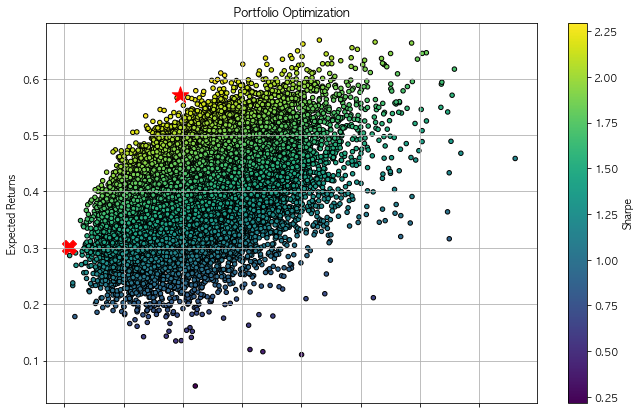

In [ ]:
df.plot.scatter(x='Risk', y='Returns', c='Sharpe', cmap='viridis', edgecolors='k', figsize=(11,7), grid=True)  
plt.scatter(x=max_sharpe['Risk'], y=max_sharpe['Returns'], c='r', marker='*', s=300) 
plt.scatter(x=min_risk['Risk'], y=min_risk['Returns'], c='r', marker='X', s=200)  
plt.title('Portfolio Optimization') 
plt.xlabel('Risk') 
plt.ylabel('Expected Returns') 
plt.show()

---
# 트레이팅 보조지표 생성
<img width="1199" alt="image" src="https://user-images.githubusercontent.com/88031549/236781021-4e43aafa-be51-45c9-8722-846d692ef009.png">

## 0. Data

In [ ]:
df_2012=pd.read_excel('./datasets/investing/투자종목_2012.xlsx', index_col=0)
df_2012["거래소코드"] = df_2012["거래소코드"].map(padding)
df_2012=pd.DataFrame(df_2012['거래소코드'].unique())
df_2012.rename(columns={0:'거래소코드'}, inplace=True)
df_2012

거래소코드
0   011080
1   052770
2   020120
3   066700
4   035460
5   039740
6   096040
7   052300
8   007720
9   134060
10  004870
11  001780

## 1. Bolinger

In [ ]:
n=20
sigma = 2
df_invest=[]

for i in df_2012.index:
    df_market = stock.get_market_ohlcv("20130101", "20140331", df_2012.loc[i,"거래소코드"]) # 연도마다 날짜 설정
    df_market["거래소코드"] = df_2012.loc[i,"거래소코드"]
    df_market["center"] = df_market['종가'].rolling(n).mean()
    df_market["ub"] = df_market['center'] + sigma*df_market['종가'].rolling(n).std()
    df_market["lb"] = df_market['center'] - sigma*df_market['종가'].rolling(n).std()
    df_invest.append(df_market)

In [ ]:
df_invest = pd.concat(df_invest)
df_invest['PB'] = (df_invest['종가'] - df_invest['lb']) / (df_invest['ub'] - df_invest['lb'])
df_invest['PB'] = df_invest['PB'].fillna(0.5) # 상한선 하한선이 같아서 PB(바닥부터의 위치)를 중간인 0.5로 설정
df_invest

시가    고가    저가    종가     거래량        거래대금   등락률   거래소코드   center  \
날짜                                                                              
2013-01-02   909   916   869   916   41105    46184285  2.20  011080      NaN   
2013-01-03   924   940   912   940   49536    57776870  2.59  011080      NaN   
2013-01-04   940   948   916   948   51402    60286530  0.84  011080      NaN   
2013-01-07   956  1031   936  1003  124374   157557835  5.83  011080      NaN   
2013-01-08  1019  1031   984  1019   35562    45543835  1.57  011080      NaN   
...          ...   ...   ...   ...     ...         ...   ...     ...      ...   
2014-03-25  2350  2390  2340  2340  265502   624095930 -0.85  001780  2124.75   
2014-03-26  2315  2365  2300  2355  296778   691025880  0.64  001780  2146.25   
2014-03-27  2360  2360  2315  2320  162788   378902650 -1.49  001780  2165.75   
2014-03-28  2340  2525  2300  2420  896309  2169679560  4.31  001780  2191.75   
2014-03-31  2460  2490  2390  2420  390409   950827120  0.00  001780  2220.50   

                     ub           lb        PB  
날짜                                              
2013-01-02          NaN          NaN  0.500000  
2013-01-03          NaN          NaN  0.500000  
2013-01-04          NaN          NaN  0.500000  
2013-01-07          NaN          NaN  0.500000  
2013-01-08          NaN          NaN  0.500000  
...                 ...          ...       ...  
2014-03-25  2583.747477  1665.752523  0.734478  
2014-03-26  2606.134139  1686.365861  0.726959  
2014-03-27  2620.065853  1711.434147  0.669761  
2014-03-28  2641.525090  1741.974910  0.753738  
2014-03-31  2650.002772  1790.997228  0.732245  

[3696 rows x 12 columns]

## 2. MFI (Money Flow Index)

In [ ]:
df_invest.rename(columns={'고가':'high'},inplace = True)
df_invest.rename(columns={'저가':'low'},inplace = True)
df_invest.rename(columns={'종가':'close'},inplace = True)
df_invest.rename(columns={'거래량':'volume'},inplace = True)

In [ ]:
df_invest['TP'] = (df_invest['high'] + df_invest['low'] + df_invest['close']) / 3
df_invest["PMF"] = 0
df_invest["NMF"] = 0

In [ ]:
for i in range(len(df_invest.close)-1):
    if df_invest.TP.values[i] < df_invest.TP.values[i+1]:
        df_invest.PMF.values[i+1] = df_invest.TP.values[i+1] * df_invest.volume.values[i+1]
        df_invest.NMF.values[i+1] = 0
    else:
        df_invest.NMF.values[i+1] = df_invest.TP.values[i+1] * df_invest.volume.values[i+1]
        df_invest.PMF.values[i+1] = 0

In [ ]:
df_invest['MFR'] = (df_invest.PMF.rolling(window=10).sum() / df_invest.NMF.rolling(window=10).sum())
df_invest['MFR'] = df_invest['MFR'].fillna(0) # PMF, NMF가 0이면 NaN임(거래정지일 때)
df_invest['MFI10'] = 100 - 100/(1 + df_invest['MFR'])
df_invest.head(10)

시가  high   low  close  volume       거래대금   등락률   거래소코드  center  \
날짜                                                                             
2013-01-02   909   916   869    916   41105   46184285  2.20  011080     NaN   
2013-01-03   924   940   912    940   49536   57776870  2.59  011080     NaN   
2013-01-04   940   948   916    948   51402   60286530  0.84  011080     NaN   
2013-01-07   956  1031   936   1003  124374  157557835  5.83  011080     NaN   
2013-01-08  1019  1031   984   1019   35562   45543835  1.57  011080     NaN   
2013-01-09  1035  1043  1007   1023   27801   36059290  0.39  011080     NaN   
2013-01-10  1039  1039   980    980   24696   31174625 -4.25  011080     NaN   
2013-01-11  1011  1035   960    995   23708   30089560  1.61  011080     NaN   
2013-01-14  1011  1027   968    980   37503   47487455 -1.59  011080     NaN   
2013-01-15  1015  1015   972    991   16550   20619180  1.21  011080     NaN   

            ub  lb   PB           TP        PMF       NMF       MFR      MFI10  
날짜                                                                              
2013-01-02 NaN NaN  0.5   900.333333          0         0  0.000000   0.000000  
2013-01-03 NaN NaN  0.5   930.666667   46101504         0  0.000000   0.000000  
2013-01-04 NaN NaN  0.5   937.333333   48180808         0  0.000000   0.000000  
2013-01-07 NaN NaN  0.5   990.000000  123130260         0  0.000000   0.000000  
2013-01-08 NaN NaN  0.5  1011.333333   35965036         0  0.000000   0.000000  
2013-01-09 NaN NaN  0.5  1024.333333   28477490         0  0.000000   0.000000  
2013-01-10 NaN NaN  0.5   999.666667          0  24687768  0.000000   0.000000  
2013-01-11 NaN NaN  0.5   996.666667          0  23628973  0.000000   0.000000  
2013-01-14 NaN NaN  0.5   991.666667          0  37190475  0.000000   0.000000  
2013-01-15 NaN NaN  0.5   992.666667   16428633         0  3.488404  77.720367

## 3. 일중 강도

In [ ]:
df_invest['II'] = (2*df_invest['close']-df_invest['high']-df_invest['low'])/(df_invest['high']-df_invest['low'])*df_invest['volume']
df_invest['II'] = df_invest['II'].fillna(0) # 상한가 또는 하한가일 때 가격이 고정되어서 분모, 분자가 0이된다.
df_invest['IIP21'] = df_invest['II'].rolling(window=21).sum()/df_invest['volume'].rolling(window=21).sum()*100
# df_invest = df_invest.dropna()
df_invest.head(20)

시가  high   low  close  volume       거래대금   등락률   거래소코드  center  \
날짜                                                                             
2013-01-02   909   916   869    916   41105   46184285  2.20  011080     NaN   
2013-01-03   924   940   912    940   49536   57776870  2.59  011080     NaN   
2013-01-04   940   948   916    948   51402   60286530  0.84  011080     NaN   
2013-01-07   956  1031   936   1003  124374  157557835  5.83  011080     NaN   
2013-01-08  1019  1031   984   1019   35562   45543835  1.57  011080     NaN   
2013-01-09  1035  1043  1007   1023   27801   36059290  0.39  011080     NaN   
2013-01-10  1039  1039   980    980   24696   31174625 -4.25  011080     NaN   
2013-01-11  1011  1035   960    995   23708   30089560  1.61  011080     NaN   
2013-01-14  1011  1027   968    980   37503   47487455 -1.59  011080     NaN   
2013-01-15  1015  1015   972    991   16550   20619180  1.21  011080     NaN   
2013-01-16   988  1003   936    988   81450   99774140 -0.40  011080     NaN   
2013-01-17   988  1015   968    980   28215   35166845 -0.80  011080     NaN   
2013-01-18   995  1011   980    995   30243   37819015  1.61  011080     NaN   
2013-01-21   988  1007   984    984   34173   42814170 -1.19  011080     NaN   
2013-01-22  1007  1007   968    988   10200   12594415  0.40  011080     NaN   
2013-01-23   972  1007   952    972   48893   60101490 -1.60  011080     NaN   
2013-01-24   991   991   948    964   47475   57672820 -0.81  011080     NaN   
2013-01-25   956   984   944    984   25340   30628110  2.05  011080     NaN   
2013-01-28   991  1007   964    991   12385   15485260  0.80  011080     NaN   
2013-01-29  1011  1011   972    991   21777   27235260  0.00  011080   981.6   

                     ub          lb        PB           TP        PMF  \
날짜                                                                      
2013-01-02          NaN         NaN  0.500000   900.333333          0   
2013-01-03          NaN         NaN  0.500000   930.666667   46101504   
2013-01-04          NaN         NaN  0.500000   937.333333   48180808   
2013-01-07          NaN         NaN  0.500000   990.000000  123130260   
2013-01-08          NaN         NaN  0.500000  1011.333333   35965036   
2013-01-09          NaN         NaN  0.500000  1024.333333   28477490   
2013-01-10          NaN         NaN  0.500000   999.666667          0   
2013-01-11          NaN         NaN  0.500000   996.666667          0   
2013-01-14          NaN         NaN  0.500000   991.666667          0   
2013-01-15          NaN         NaN  0.500000   992.666667   16428633   
2013-01-16          NaN         NaN  0.500000   975.666667          0   
2013-01-17          NaN         NaN  0.500000   987.666667   27867015   
2013-01-18          NaN         NaN  0.500000   995.333333   30101866   
2013-01-21          NaN         NaN  0.500000   991.666667          0   
2013-01-22          NaN         NaN  0.500000   987.666667          0   
2013-01-23          NaN         NaN  0.500000   977.000000          0   
2013-01-24          NaN         NaN  0.500000   967.666667          0   
2013-01-25          NaN         NaN  0.500000   970.666667   24596693   
2013-01-28          NaN         NaN  0.500000   987.333333   12228123   
2013-01-29  1031.570096  931.629904  0.594056   991.333333   21588266   

                 NMF       MFR      MFI10            II  IIP21  
날짜                                                              
2013-01-02         0  0.000000   0.000000  41105.000000    NaN  
2013-01-03         0  0.000000   0.000000  49536.000000    NaN  
2013-01-04         0  0.000000   0.000000  51402.000000    NaN  
2013-01-07         0  0.000000   0.000000  51058.800000    NaN  
2013-01-08         0  0.000000   0.000000  17402.680851    NaN  
2013-01-09         0  0.000000   0.000000  -3089.000000    NaN  
2013-01-10  24687768  0.000000   0.000000 -24696.000000    NaN  
2013-01-11  23628973  0.000000   0.000000  -1580.533333    Na

## 4. MACD

In [ ]:
macd_short, macd_long, macd_signal=12,26,9
df_invest["MACD_short"]=df_invest["close"].rolling(macd_short).mean()
df_invest["MACD_long"]=df_invest["close"].rolling(macd_long).mean()
df_invest["MACD"]=df_invest.apply(lambda x: (x["MACD_short"]-x["MACD_long"]), axis=1)
df_invest["MACD_signal"]=df_invest["MACD"].rolling(macd_signal).mean()  
# df_invest["MACD_sign"]=df_invest.apply(lambda x: ("매수" if x["MACD"]>x["MACD_signal"] else "매도"), axis=1)
df_invest.head(10)

시가  high   low  close  volume       거래대금   등락률   거래소코드  center  \
날짜                                                                             
2013-01-02   909   916   869    916   41105   46184285  2.20  011080     NaN   
2013-01-03   924   940   912    940   49536   57776870  2.59  011080     NaN   
2013-01-04   940   948   916    948   51402   60286530  0.84  011080     NaN   
2013-01-07   956  1031   936   1003  124374  157557835  5.83  011080     NaN   
2013-01-08  1019  1031   984   1019   35562   45543835  1.57  011080     NaN   
2013-01-09  1035  1043  1007   1023   27801   36059290  0.39  011080     NaN   
2013-01-10  1039  1039   980    980   24696   31174625 -4.25  011080     NaN   
2013-01-11  1011  1035   960    995   23708   30089560  1.61  011080     NaN   
2013-01-14  1011  1027   968    980   37503   47487455 -1.59  011080     NaN   
2013-01-15  1015  1015   972    991   16550   20619180  1.21  011080     NaN   

            ub  ...        PMF       NMF       MFR      MFI10            II  \
날짜              ...                                                           
2013-01-02 NaN  ...          0         0  0.000000   0.000000  41105.000000   
2013-01-03 NaN  ...   46101504         0  0.000000   0.000000  49536.000000   
2013-01-04 NaN  ...   48180808         0  0.000000   0.000000  51402.000000   
2013-01-07 NaN  ...  123130260         0  0.000000   0.000000  51058.800000   
2013-01-08 NaN  ...   35965036         0  0.000000   0.000000  17402.680851   
2013-01-09 NaN  ...   28477490         0  0.000000   0.000000  -3089.000000   
2013-01-10 NaN  ...          0  24687768  0.000000   0.000000 -24696.000000   
2013-01-11 NaN  ...          0  23628973  0.000000   0.000000  -1580.533333   
2013-01-14 NaN  ...          0  37190475  0.000000   0.000000 -22247.542373   
2013-01-15 NaN  ...   16428633         0  3.488404  77.720367  -1924.418605   

            IIP21  MACD_short  MACD_long  MACD  MACD_signal  
날짜                                                           
2013-01-02    NaN         NaN        NaN   NaN          NaN  
2013-01-03    NaN         NaN        NaN   NaN          NaN  
2013-01-04    NaN         NaN        NaN   NaN          NaN  
2013-01-07    NaN         NaN        NaN   NaN          NaN  
2013-01-08    NaN         NaN        NaN   NaN          NaN  
2013-01-09    NaN         NaN        NaN   NaN          NaN  
2013-01-10    NaN         NaN        NaN   NaN          NaN  
2013-01-11    NaN         NaN        NaN   NaN          NaN  
2013-01-14    NaN         NaN        NaN   NaN          NaN  
2013-01-15    NaN         NaN        NaN   NaN          NaN  

[10 rows x 23 columns]

## 5. 이평선(9,20,40,60)

In [ ]:
df_invest['MA9'] = df_invest['close'].rolling(9).mean()
df_invest['MA20'] = df_invest['close'].rolling(20).mean()
df_invest['MA40'] = df_invest['close'].rolling(40).mean()
df_invest['MA60'] = df_invest['close'].rolling(60).mean()

# pd.set_option('display.max_columns', None)
# df_invest.drop(columns='MACD_signal', inplace=True)
df_invest.reset_index(drop=False, inplace=True)
df_invest

날짜    시가  high   low  close  volume        거래대금   등락률   거래소코드  \
0    2013-01-02   909   916   869    916   41105    46184285  2.20  011080   
1    2013-01-03   924   940   912    940   49536    57776870  2.59  011080   
2    2013-01-04   940   948   916    948   51402    60286530  0.84  011080   
3    2013-01-07   956  1031   936   1003  124374   157557835  5.83  011080   
4    2013-01-08  1019  1031   984   1019   35562    45543835  1.57  011080   
...         ...   ...   ...   ...    ...     ...         ...   ...     ...   
3691 2014-03-25  2350  2390  2340   2340  265502   624095930 -0.85  001780   
3692 2014-03-26  2315  2365  2300   2355  296778   691025880  0.64  001780   
3693 2014-03-27  2360  2360  2315   2320  162788   378902650 -1.49  001780   
3694 2014-03-28  2340  2525  2300   2420  896309  2169679560  4.31  001780   
3695 2014-03-31  2460  2490  2390   2420  390409   950827120  0.00  001780   

       center  ...             II     IIP21   MACD_short    MACD_long  \
0         NaN  ...   41105.000000       NaN          NaN          NaN   
1         NaN  ...   49536.000000       NaN          NaN          NaN   
2         NaN  ...   51402.000000       NaN          NaN          NaN   
3         NaN  ...   51058.800000       NaN          NaN          NaN   
4         NaN  ...   17402.680851       NaN          NaN          NaN   
...       ...  ...            ...       ...          ...          ...   
3691  2124.75  ... -265502.000000 -8.126881  2276.666667  2079.230769   
3692  2146.25  ...  205461.692308 -6.176932  2312.500000  2096.538462   
3693  2165.75  ... -126612.888889 -6.837159  2343.750000  2111.730769   
3694  2191.75  ...   59753.933333 -5.855836  2359.166667  2131.153846   
3695  2220.50  ... -156163.600000 -6.799460  2367.500000  2150.384615   

            MACD  MACD_signal          MA9     MA20      MA40         MA60  
0            NaN          NaN          NaN      NaN       NaN          NaN  
1            NaN          NaN          NaN      NaN       NaN          NaN  
2            NaN          NaN          NaN      NaN       NaN          NaN  
3            NaN          NaN          NaN      NaN       NaN          NaN  
4            NaN          NaN          NaN      NaN       NaN          NaN  
...          ...          ...          ...      ...       ...          ...  
3691  197.435897   103.443732  2357.222222  2124.75  2025.625  2004.500000  
3692  215.961538   126.420940  2361.111111  2146.25  2037.500  2013.250000  
3693  232.019231   149.070513  2358.888889  2165.75  2048.875  2020.916667  
3694  228.012821   168.938746  2365.555556  2191.75  2062.625  2028.000000  
3695  217.115385   184.918091  2372.222222  2220.50  2076.625  2035.666667  

[3696 rows x 28 columns]

## 6. 사용하는 날짜만 필터링(04/01~03/31)

In [ ]:
df_2012 = df_invest[df_invest['날짜'] >= '2013-04-01']
df_2012.set_index('날짜', inplace=True)
df_2012

시가  high   low  close  volume        거래대금   등락률   거래소코드  \
날짜                                                                      
2013-04-01  1272  1272  1189   1244  109523   170865185 -0.94  011080   
2013-04-02  1260  1260  1185   1209   98223   149728375 -2.86  011080   
2013-04-03  1213  1225  1185   1189   59143    89407400 -1.63  011080   
2013-04-04  1201  1205  1106   1177  103359   151062060 -1.00  011080   
2013-04-05  1181  1185  1134   1165   47623    69916125 -1.01  011080   
...          ...   ...   ...    ...     ...         ...   ...     ...   
2014-03-25  2350  2390  2340   2340  265502   624095930 -0.85  001780   
2014-03-26  2315  2365  2300   2355  296778   691025880  0.64  001780   
2014-03-27  2360  2360  2315   2320  162788   378902650 -1.49  001780   
2014-03-28  2340  2525  2300   2420  896309  2169679560  4.31  001780   
2014-03-31  2460  2490  2390   2420  390409   950827120  0.00  001780   

             center           ub  ...             II      IIP21   MACD_short  \
날짜                                ...                                          
2013-04-01  1187.20  1302.571437  ...   35627.963855  30.792605  1202.666667   
2013-04-02  1189.60  1304.673249  ...  -35360.280000  27.093896  1206.333333   
2013-04-03  1191.60  1305.081554  ...  -47314.400000  24.529046  1210.583333   
2013-04-04  1192.40  1305.196790  ...   44893.303030  24.292527  1213.833333   
2013-04-05  1191.60  1304.962762  ...   10271.627451  21.871976  1216.750000   
...             ...          ...  ...            ...        ...          ...   
2014-03-25  2124.75  2583.747477  ... -265502.000000  -8.126881  2276.666667   
2014-03-26  2146.25  2606.134139  ...  205461.692308  -6.176932  2312.500000   
2014-03-27  2165.75  2620.065853  ... -126612.888889  -6.837159  2343.750000   
2014-03-28  2191.75  2641.525090  ...   59753.933333  -5.855836  2359.166667   
2014-03-31  2220.50  2650.002772  ... -156163.600000  -6.799460  2367.500000   

              MACD_long        MACD  MACD_signal          MA9     MA20  \
날짜                                                                       
2013-04-01  1180.923077   21.743590     7.326923  1221.222222  1187.20   
2013-04-02  1181.846154   24.487179     9.488604  1230.000000  1189.60   
2013-04-03  1183.384615   27.198718    12.375356  1236.555556  1191.60   
2013-04-04  1184.730769   29.102564    15.672365  1240.000000  1192.40   
2013-04-05  1185.461538   31.288462    19.253561  1236.888889  1191.60   
...                 ...         ...          ...          ...      ...   
2014-03-25  2079.230769  197.435897   103.443732  2357.222222  2124.75   
2014-03-26  2096.538462  215.961538   126.420940  2361.111111  2146.25   
2014-03-27  2111.730769  232.019231   149.070513  2358.888889  2165.75   
2014-03-28  2131.153846  228.012821   168.938746  2365.555556  2191.75   
2014-03-31  2150.384615  217.115385   184.918091  2372.222222  2220.50   

                MA40         MA60  
날짜                                 
2013-04-01  1147.225  1094.250000  
2013-04-02  1152.950  1098.600000  
2013-04-03  1158.375  1101.700000  
2013-04-04  1163.025  1104.333333  
2013-04-05  1167.375  1106.700000  
...              ...          ...  
2014-03-25  2025.625  2004.500000  
2014-03-26  2037.500  2013.250000  
2014-03-27  2048.875  2020.916667  
2014-03-28  2062.625  2028.000000  
2014-03-31  2076.625  2035.666667  

[2964 rows x 27 columns]

In [ ]:
# df_2012[df_2012.isna().any(axis=1)]
df_2012.isna().sum()

시가             0
high           0
low            0
close          0
volume         0
거래대금           0
등락률            0
거래소코드          0
center         0
ub             0
lb             0
PB             0
TP             0
PMF            0
NMF            0
MFR            0
MFI10          0
II             0
IIP21          0
MACD_short     0
MACD_long      0
MACD           0
MACD_signal    0
MA9            0
MA20           0
MA40           0
MA60           0
dtype: int64

---
# 전략1 : Buy&Hold 전략

## 1) 포트폴리오 일별 수익률 계산(비중 3개 중 택 1)

In [ ]:
df_port = df_2012.copy()
df_port

시가  high   low  close  volume        거래대금   등락률   거래소코드  \
날짜                                                                      
2013-04-01  1272  1272  1189   1244  109523   170865185 -0.94  011080   
2013-04-02  1260  1260  1185   1209   98223   149728375 -2.86  011080   
2013-04-03  1213  1225  1185   1189   59143    89407400 -1.63  011080   
2013-04-04  1201  1205  1106   1177  103359   151062060 -1.00  011080   
2013-04-05  1181  1185  1134   1165   47623    69916125 -1.01  011080   
...          ...   ...   ...    ...     ...         ...   ...     ...   
2014-03-25  2350  2390  2340   2340  265502   624095930 -0.85  001780   
2014-03-26  2315  2365  2300   2355  296778   691025880  0.64  001780   
2014-03-27  2360  2360  2315   2320  162788   378902650 -1.49  001780   
2014-03-28  2340  2525  2300   2420  896309  2169679560  4.31  001780   
2014-03-31  2460  2490  2390   2420  390409   950827120  0.00  001780   

             center           ub  ...             II      IIP21   MACD_short  \
날짜                                ...                                          
2013-04-01  1187.20  1302.571437  ...   35627.963855  30.792605  1202.666667   
2013-04-02  1189.60  1304.673249  ...  -35360.280000  27.093896  1206.333333   
2013-04-03  1191.60  1305.081554  ...  -47314.400000  24.529046  1210.583333   
2013-04-04  1192.40  1305.196790  ...   44893.303030  24.292527  1213.833333   
2013-04-05  1191.60  1304.962762  ...   10271.627451  21.871976  1216.750000   
...             ...          ...  ...            ...        ...          ...   
2014-03-25  2124.75  2583.747477  ... -265502.000000  -8.126881  2276.666667   
2014-03-26  2146.25  2606.134139  ...  205461.692308  -6.176932  2312.500000   
2014-03-27  2165.75  2620.065853  ... -126612.888889  -6.837159  2343.750000   
2014-03-28  2191.75  2641.525090  ...   59753.933333  -5.855836  2359.166667   
2014-03-31  2220.50  2650.002772  ... -156163.600000  -6.799460  2367.500000   

              MACD_long        MACD  MACD_signal          MA9     MA20  \
날짜                                                                       
2013-04-01  1180.923077   21.743590     7.326923  1221.222222  1187.20   
2013-04-02  1181.846154   24.487179     9.488604  1230.000000  1189.60   
2013-04-03  1183.384615   27.198718    12.375356  1236.555556  1191.60   
2013-04-04  1184.730769   29.102564    15.672365  1240.000000  1192.40   
2013-04-05  1185.461538   31.288462    19.253561  1236.888889  1191.60   
...                 ...         ...          ...          ...      ...   
2014-03-25  2079.230769  197.435897   103.443732  2357.222222  2124.75   
2014-03-26  2096.538462  215.961538   126.420940  2361.111111  2146.25   
2014-03-27  2111.730769  232.019231   149.070513  2358.888889  2165.75   
2014-03-28  2131.153846  228.012821   168.938746  2365.555556  2191.75   
2014-03-31  2150.384615  217.115385   184.918091  2372.222222  2220.50   

                MA40         MA60  
날짜                                 
2013-04-01  1147.225  1094.250000  
2013-04-02  1152.950  1098.600000  
2013-04-03  1158.375  1101.700000  
2013-04-04  1163.025  1104.333333  
2013-04-05  1167.375  1106.700000  
...              ...          ...  
2014-03-25  2025.625  2004.500000  
2014-03-26  2037.500  2013.250000  
2014-03-27  2048.875  2020.916667  
2014-03-28  2062.625  2028.000000  
2014-03-31  2076.625  2035.666667  

[2964 rows x 27 columns]

### 1. 동등비중

In [ ]:
list_company_code = list(df_port["거래소코드"].unique())

port_return = 0 # 여기다가 각 종목 일별 수익률을 합산 후 (가중)평균
for i in list_company_code:
    df_acompany = df_port[df_port["거래소코드"]==i]
    df_stock = df_acompany["close"].pct_change() # 전략없이 일평균으로만
    port_return += df_stock
port_return = port_return/len(list_company_code)

### 2. 수익률 높게

In [ ]:
list_company_code = list(df_port["거래소코드"].unique())

port_return = 0 # 여기다가 각 종목 일별 수익률을 합산 후 (가중)평균
for i in list_company_code:
    df_acompany = df_port[df_port["거래소코드"]==i]
    df_stock = df_acompany["close"].pct_change()
    port_return += df_stock * dict_weight_max[i] # 리스크가 같을 때 수익률 젤 높게하는 비중으로 가중평균
port_return = port_return/len(list_company_code)

### 3. 리스크 낮게

In [ ]:
list_company_code = list(df_port["거래소코드"].unique())

port_return = 0 # 여기다가 각 종목 일별 수익률을 합산 후 (가중)평균
for i in list_company_code:
    df_acompany = df_port[df_port["거래소코드"]==i]
    df_stock = df_acompany["close"].pct_change()
    port_return += df_stock * dict_weight_min[i] # 수익률이 같을 때 리스크를 낮게하는 비중으로 가중평균
port_return = port_return/len(list_company_code)

## 2) 포트폴리오 평가

                    Strategy
------------------  ----------
Start Period        2013-04-01
End Period          2014-03-31
Risk-Free Rate      0.0%
Time in Market      100.0%

Cumulative Return   4.64%
CAGR﹪              4.66%

Sharpe              0.34
Prob. Sharpe Ratio  63.08%
Sortino             0.45
Sortino/√2          0.32
Omega               1.06

Max Drawdown        -17.95%
Longest DD Days     306

Gain/Pain Ratio     0.06
Gain/Pain (1M)      0.34

Payoff Ratio        0.91
Profit Factor       1.06
Common Sense Ratio  0.98
CPC Index           0.52
Tail Ratio          0.93
Outlier Win Ratio   3.03
Outlier Loss Ratio  2.98

MTD                 3.74%
3M                  13.06%
6M                  5.7%
YTD                 13.06%
1Y                  4.64%
3Y (ann.)           4.66%
5Y (ann.)           4.66%
10Y (ann.)          4.66%
All-time (ann.)     4.66%

Avg. Drawdown       -6.85%
Avg. Drawdown Days  88
Recovery Factor     0.26
Ulcer Index         0.1
Serenity Index      0.03


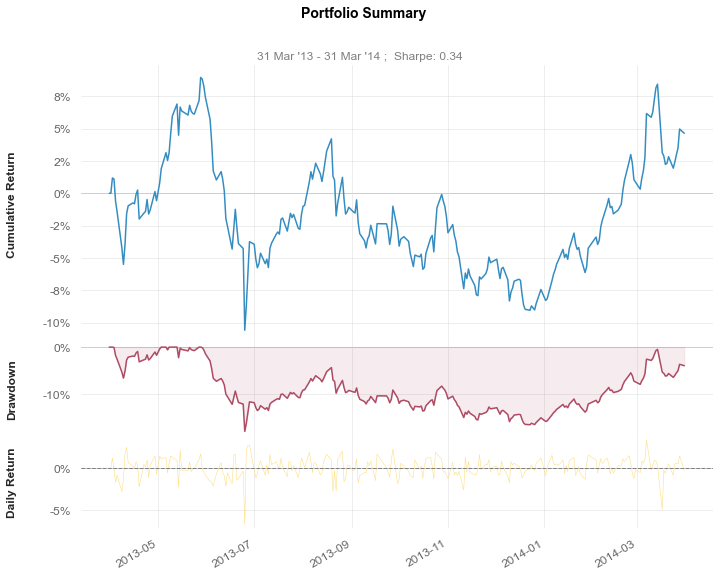

In [ ]:
import quantstats as qs
qs.reports.metrics(port_return, mode = 'basic')
qs.plots.snapshot(port_return)

---
# 전략2 : PB&MFI 전략

## 1) 전략2 함수 : 일별수익률로 return

In [ ]:
def func_strategy2(df_func):
    
    # 1.컬럼 생성
    df_func["BS"] = ""
    df_func["보유날_종가"] = 0
    df_func["보유날_일별수익률"] = 0
    df_func["첫매수날_여부"] = 0 # 첫매수날의 일별수익율은 0이다. 일별수익률 컬럼만들어준 뒤 이거 사용해서 다시 전처리
    df_func
    
    # 2. BS 컬럼
    ## BS컬럼 생성을 위해 임의의 2개 행 만들기
    df_tm2 = pd.DataFrame(df_func.iloc[0]).T
    df_tm2["날짜"]=(df_func.index[0] - timedelta(days=2))
    df_tm2["BS"] = "sell" 
    df_tm2.set_index("날짜", inplace=True)
    df_tm2

    df_tm1 = pd.DataFrame(df_func.iloc[0]).T
    df_tm1["날짜"]=(df_func.index[0] - timedelta(days=1))
    df_tm1["BS"] = "sell"
    df_tm1.set_index("날짜", inplace=True)
    df_tm1

    df_func = pd.concat([df_tm2, df_tm1, df_func], axis=0)
    df_func.reset_index(drop=False, inplace=True)
    df_func
    
    ## BS컬럼에 buy&sell 넣기
    for i in df_func.index:
        if (i == df_func.index[0])|(i == df_func.index[1]):
            continue
    
        if df_func.loc[i-1, "BS"] == "sell": # (전날에 sell이면) buy조건 만족하는지 확인
            if (df_func.loc[i-2, "BS"] == "buy")&(df_func.loc[i-1, "BS"] == "sell")&((df_func.loc[i, "PB"] >= 0.7)&(df_func.loc[i, "MFI10"] >= 70)):
                df_func.loc[i-1, "BS"] = "buy"
                df_func.loc[i, "첫매수날_여부"] = 1
            
            if (df_func.loc[i, "PB"] >= 0.7)&(df_func.loc[i, "MFI10"] >= 70):
                df_func.loc[i, "BS"] = "buy"
            else:
                df_func.loc[i, "BS"] = "sell"
        
        else: # (전날이 "buy"일 때) sell조건
            if (df_func.loc[i, "PB"] <= 0.6): # 매도사인
                df_func.loc[i, "BS"] = "sell"
            else:
                df_func.loc[i, "BS"] = "buy" # sell조건 만족 안하면 "buy"
    
    # 3. "보유날_종가"
    for i in df_func.index:
        if df_func.loc[i, "BS"] == "buy":
            df_func.loc[i, "보유날_종가"] = df_func.loc[i, "close"]
    
    # 4. "보유날_일별수익률" 컬럼
    df_func["보유날_일별수익률"] = df_func["보유날_종가"].pct_change()
    df_func["보유날_일별수익률"] = df_func["보유날_일별수익률"].fillna(0)
    for i in df_func.index:
        if df_func.loc[i, "보유날_일별수익률"] == -1.0:
            df_func.loc[i, "보유날_일별수익률"] = 0
        if df_func.loc[i, "보유날_일별수익률"] == np.inf:
            df_func.loc[i, "보유날_일별수익률"] = 0
    
    # 5. "첫매수날_여부" 컬럼
    for i in df_func.index:
        if (i == df_func.index[0])|(i == df_func.index[1]):
            continue
        
        if (df_func.loc[i-1, "BS"] == "sell")&(df_func.loc[i, "BS"] == "buy"):
            df_func.loc[i, "첫매수날_여부"] = 1
    
    for i in df_func.index:
        if df_func.loc[i, "첫매수날_여부"] == 1:
            df_func.loc[i, "보유날_일별수익률"] = 0
    
    df_func.drop(index=[0,1],inplace=True)
    df_func.reset_index(drop=True, inplace=True)
    df_stock = df_func.set_index("날짜")["보유날_일별수익률"]
    
    return df_stock

## 2) 포트폴리오 일별 수익률 계산

In [ ]:
df_port = df_2012.copy()

### 1. 동등비중

In [ ]:
list_company_code = list(df_port["거래소코드"].unique())

port_return = 0 # 여기다가 각 종목 일별 수익률을 합산 후 (가중)평균
for i in list_company_code:
    df_acompany = df_port[df_port["거래소코드"]==i]
    df_stock = func_strategy2(df_acompany)
    port_return += df_stock
port_return = port_return/len(list_company_code)

### 2. 수익률 높게

### 3. 리스크 낮게

## 3) 포트폴리오 평가

                    Strategy
------------------  ----------
Start Period        2013-04-01
End Period          2014-03-31
Risk-Free Rate      0.0%
Time in Market      89.0%

Cumulative Return   21.45%
CAGR﹪              21.52%

Sharpe              2.99
Prob. Sharpe Ratio  99.91%
Sortino             5.46
Sortino/√2          3.86
Omega               1.77

Max Drawdown        -2.95%
Longest DD Days     92

Gain/Pain Ratio     0.77
Gain/Pain (1M)      6.26

Payoff Ratio        1.38
Profit Factor       1.77
Common Sense Ratio  2.81
CPC Index           1.37
Tail Ratio          1.59
Outlier Win Ratio   4.57
Outlier Loss Ratio  3.28

MTD                 1.33%
3M                  9.26%
6M                  9.82%
YTD                 9.26%
1Y                  21.45%
3Y (ann.)           21.52%
5Y (ann.)           21.52%
10Y (ann.)          21.52%
All-time (ann.)     21.52%

Avg. Drawdown       -1.01%
Avg. Drawdown Days  20
Recovery Factor     7.27
Ulcer Index         0.01
Serenity Index      2.33


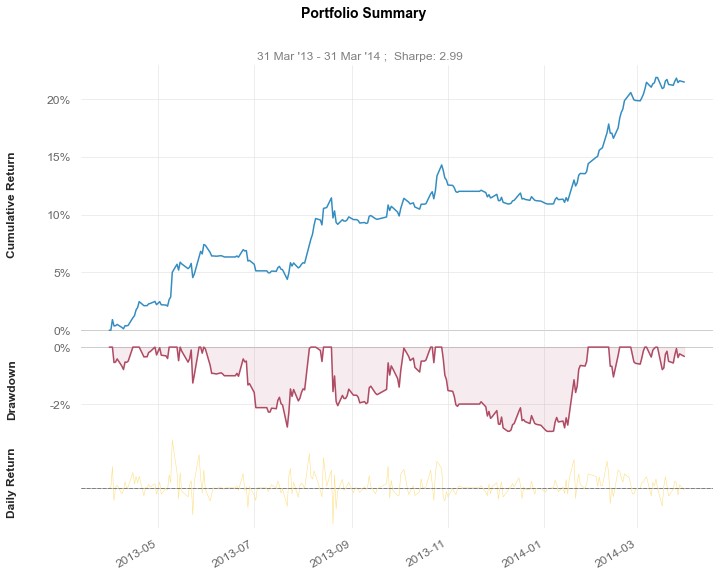

In [ ]:
import quantstats as qs
qs.reports.metrics(port_return, mode = 'basic')
qs.plots.snapshot(port_return)

---
# 전략3

## 1) 전략3 함수 : 일별수익률로 return

In [ ]:
def func_strategy3(df_func):
    
    # 1.컬럼 생성
    df_func["BS"] = ""
    df_func["보유날_종가"] = 0
    df_func["보유날_일별수익률"] = 0
    df_func["첫매수날_여부"] = 0 # 첫매수날의 일별수익율은 0이다. 일별수익률 컬럼만들어준 뒤 이거 사용해서 다시 전처리
    df_func
    
    # 2. BS 컬럼
    ## BS컬럼 생성을 위해 임의의 2개 행 만들기
    df_tm2 = pd.DataFrame(df_func.iloc[0]).T
    df_tm2["날짜"]=(df_func.index[0] - timedelta(days=2))
    df_tm2["BS"] = "sell" 
    df_tm2.set_index("날짜", inplace=True)
    df_tm2

    df_tm1 = pd.DataFrame(df_func.iloc[0]).T
    df_tm1["날짜"]=(df_func.index[0] - timedelta(days=1))
    df_tm1["BS"] = "sell"
    df_tm1.set_index("날짜", inplace=True)
    df_tm1

    df_func = pd.concat([df_tm2, df_tm1, df_func], axis=0)
    df_func.reset_index(drop=False, inplace=True)
    df_func
    
    ## BS컬럼에 buy&sell 넣기
    for i in df_func.index:
        if (i == df_func.index[0])|(i == df_func.index[1]):
            continue
    
        if df_func.loc[i-1, "BS"] == "sell": # (전날에 sell이면) buy조건 만족하는지 확인
            if (df_func.loc[i-2, "BS"] == "buy")&(df_func.loc[i-1, "BS"] == "sell")&((df_func.loc[i, "PB"] <= 0.2)&(df_func.loc[i, "IIP21"] >= 0)):
                df_func.loc[i-1, "BS"] = "buy"
                df_func.loc[i, "첫매수날_여부"] = 1
            
            if ((df_func.loc[i, "PB"] <= 0.2)&(df_func.loc[i, "IIP21"] >= 0)):
                df_func.loc[i, "BS"] = "buy"
            else:
                df_func.loc[i, "BS"] = "sell"
        
        else: # (전날이 "buy"일 때) sell조건
            if (df_func.loc[i, "PB"] >= 0.8)&(df_func.loc[i, "IIP21"] <= 0): # 매도사인
                df_func.loc[i, "BS"] = "sell"
            else:
                df_func.loc[i, "BS"] = "buy" # sell조건 만족 안하면 "buy"
    
    # 3. "보유날_종가"
    for i in df_func.index:
        if df_func.loc[i, "BS"] == "buy":
            df_func.loc[i, "보유날_종가"] = df_func.loc[i, "close"]
    
    # 4. "보유날_일별수익률" 컬럼
    df_func["보유날_일별수익률"] = df_func["보유날_종가"].pct_change()
    df_func["보유날_일별수익률"] = df_func["보유날_일별수익률"].fillna(0)
    for i in df_func.index:
        if df_func.loc[i, "보유날_일별수익률"] == -1.0:
            df_func.loc[i, "보유날_일별수익률"] = 0
        if df_func.loc[i, "보유날_일별수익률"] == np.inf:
            df_func.loc[i, "보유날_일별수익률"] = 0
    
    # 5. "첫매수날_여부" 컬럼
    for i in df_func.index:
        if (i == df_func.index[0])|(i == df_func.index[1]):
            continue
        
        if (df_func.loc[i-1, "BS"] == "sell")&(df_func.loc[i, "BS"] == "buy"):
            df_func.loc[i, "첫매수날_여부"] = 1
    
    for i in df_func.index:
        if df_func.loc[i, "첫매수날_여부"] == 1:
            df_func.loc[i, "보유날_일별수익률"] = 0
    
    df_func.drop(index=[0,1],inplace=True)
    df_func.reset_index(drop=True, inplace=True)
    df_stock = df_func.set_index("날짜")["보유날_일별수익률"]
    
    return df_stock


## 2) 포트폴리오 일별 수익률 계산

In [ ]:
df_port = df_2012.copy()

### 1. 동등비중

In [ ]:
list_company_code = list(df_port["거래소코드"].unique())

port_return = 0 # 여기다가 각 종목 일별 수익률을 합산 후 (가중)평균
for i in list_company_code:
    df_acompany = df_port[df_port["거래소코드"]==i]
    df_stock = func_strategy3(df_acompany)
    port_return += df_stock
port_return = port_return/len(list_company_code)

### 2. 수익률 높게

### 3. 리스크 낮게

## 3) 포트폴리오 평가

                    Strategy
------------------  ----------
Start Period        2013-04-01
End Period          2014-03-31
Risk-Free Rate      0.0%
Time in Market      100.0%

Cumulative Return   2.71%
CAGR﹪              2.72%

Sharpe              0.32
Prob. Sharpe Ratio  62.48%
Sortino             0.46
Sortino/√2          0.32
Omega               1.06

Max Drawdown        -9.17%
Longest DD Days     301

Gain/Pain Ratio     0.06
Gain/Pain (1M)      0.34

Payoff Ratio        1.01
Profit Factor       1.06
Common Sense Ratio  1.46
CPC Index           0.55
Tail Ratio          1.39
Outlier Win Ratio   3.24
Outlier Loss Ratio  3.88

MTD                 3.24%
3M                  3.72%
6M                  0.18%
YTD                 3.72%
1Y                  2.71%
3Y (ann.)           2.72%
5Y (ann.)           2.72%
10Y (ann.)          2.72%
All-time (ann.)     2.72%

Avg. Drawdown       -2.29%
Avg. Drawdown Days  57
Recovery Factor     0.3
Ulcer Index         0.05
Serenity Index      0.04


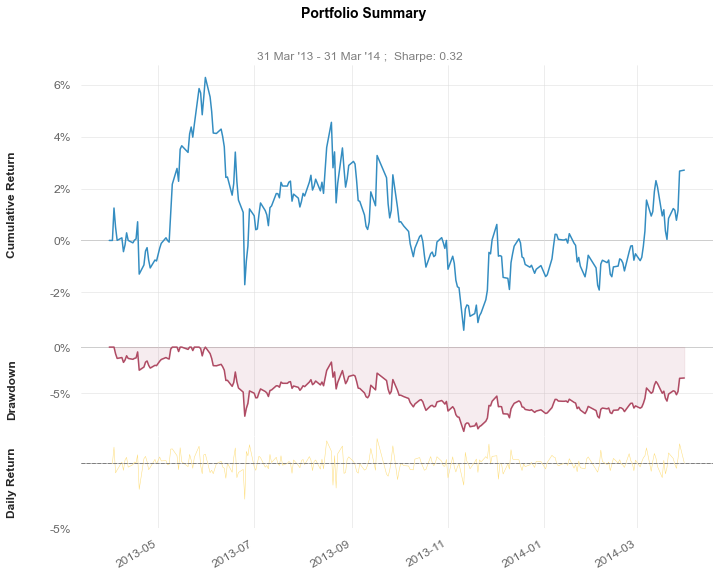

In [ ]:
import quantstats as qs
qs.reports.metrics(port_return, mode = 'basic')
qs.plots.snapshot(port_return)

---
# 전략4

## 1) 전략4 함수 : 일별수익률로 return

In [ ]:
def func_strategy4(df_func):
    
    # 1.컬럼 생성
    df_func["BS"] = ""
    df_func["보유날_종가"] = 0
    df_func["보유날_일별수익률"] = 0
    df_func["첫매수날_여부"] = 0 # 첫매수날의 일별수익율은 0이다. 일별수익률 컬럼만들어준 뒤 이거 사용해서 다시 전처리
    df_func
    
    # 2. BS 컬럼
    ## BS컬럼 생성을 위해 임의의 2개 행 만들기
    df_tm2 = pd.DataFrame(df_func.iloc[0]).T
    df_tm2["날짜"]=(df_func.index[0] - timedelta(days=2))
    df_tm2["BS"] = "sell" 
    df_tm2.set_index("날짜", inplace=True)
    df_tm2

    df_tm1 = pd.DataFrame(df_func.iloc[0]).T
    df_tm1["날짜"]=(df_func.index[0] - timedelta(days=1))
    df_tm1["BS"] = "sell"
    df_tm1.set_index("날짜", inplace=True)
    df_tm1

    df_func = pd.concat([df_tm2, df_tm1, df_func], axis=0)
    df_func.reset_index(drop=False, inplace=True)
    df_func
    
    ## BS컬럼에 buy&sell 넣기
    for i in df_func.index:
        if (i == df_func.index[0])|(i == df_func.index[1]):
            continue
    
        if df_func.loc[i-1, "BS"] == "sell": # (전날에 sell이면) buy조건 만족하는지 확인
            if (df_func.loc[i-2, "BS"] == "buy")&(df_func.loc[i-1, "BS"] == "sell")&((df_func.loc[i, "MACD"] >= df_func.loc[i, "MACD_signal"])&(df_func.loc[i, "close"] >= df_func.loc[i, "MA60"])):
                df_func.loc[i-1, "BS"] = "buy"
                df_func.loc[i, "첫매수날_여부"] = 1
            
            if ((df_func.loc[i, "MACD"] >= df_func.loc[i, "MACD_signal"])&(df_func.loc[i, "close"] >= df_func.loc[i, "MA60"])):
                df_func.loc[i, "BS"] = "buy"
            else:
                df_func.loc[i, "BS"] = "sell"
        
        else: # (전날이 "buy"일 때) sell조건
            if ((df_func.loc[i, "MACD"] <= df_func.loc[i, "MACD_signal"])&(df_func.loc[i, "close"] <= df_func.loc[i, "MA20"])): # 매도사인
                df_func.loc[i, "BS"] = "sell"
            else:
                df_func.loc[i, "BS"] = "buy" # sell조건 만족 안하면 "buy"
    
    # 3. "보유날_종가"
    for i in df_func.index:
        if df_func.loc[i, "BS"] == "buy":
            df_func.loc[i, "보유날_종가"] = df_func.loc[i, "close"]
    
    # 4. "보유날_일별수익률" 컬럼
    df_func["보유날_일별수익률"] = df_func["보유날_종가"].pct_change()
    df_func["보유날_일별수익률"] = df_func["보유날_일별수익률"].fillna(0)
    for i in df_func.index:
        if df_func.loc[i, "보유날_일별수익률"] == -1.0:
            df_func.loc[i, "보유날_일별수익률"] = 0
        if df_func.loc[i, "보유날_일별수익률"] == np.inf:
            df_func.loc[i, "보유날_일별수익률"] = 0
    
    # 5. "첫매수날_여부" 컬럼
    for i in df_func.index:
        if (i == df_func.index[0])|(i == df_func.index[1]):
            continue
        
        if (df_func.loc[i-1, "BS"] == "sell")&(df_func.loc[i, "BS"] == "buy"):
            df_func.loc[i, "첫매수날_여부"] = 1
    
    for i in df_func.index:
        if df_func.loc[i, "첫매수날_여부"] == 1:
            df_func.loc[i, "보유날_일별수익률"] = 0
    
    df_func.drop(index=[0,1],inplace=True)
    df_func.reset_index(drop=True, inplace=True)
    df_stock = df_func.set_index("날짜")["보유날_일별수익률"]
    
    return df_stock


## 2) 포트폴리오 일별 수익률 계산

In [ ]:
df_port = df_2012.copy()

### 1. 동등비중

In [ ]:
list_company_code = list(df_port["거래소코드"].unique())

port_return = 0 # 여기다가 각 종목 일별 수익률을 합산 후 (가중)평균
for i in list_company_code:
    df_acompany = df_port[df_port["거래소코드"]==i]
    df_stock = func_strategy4(df_acompany)
    port_return += df_stock
port_return = port_return/len(list_company_code)

### 2. 수익률 높게

### 3. 리스크 낮게

## 3) 포트폴리오 평가

                    Strategy
------------------  ----------
Start Period        2013-04-01
End Period          2014-03-31
Risk-Free Rate      0.0%
Time in Market      96.0%

Cumulative Return   6.41%
CAGR﹪              6.43%

Sharpe              0.82
Prob. Sharpe Ratio  78.94%
Sortino             1.17
Sortino/√2          0.83
Omega               1.16

Max Drawdown        -6.76%
Longest DD Days     206

Gain/Pain Ratio     0.16
Gain/Pain (1M)      1.09

Payoff Ratio        1.03
Profit Factor       1.16
Common Sense Ratio  1.11
CPC Index           0.63
Tail Ratio          0.96
Outlier Win Ratio   3.71
Outlier Loss Ratio  3.47

MTD                 0.15%
3M                  5.07%
6M                  0.88%
YTD                 5.07%
1Y                  6.41%
3Y (ann.)           6.43%
5Y (ann.)           6.43%
10Y (ann.)          6.43%
All-time (ann.)     6.43%

Avg. Drawdown       -1.91%
Avg. Drawdown Days  31
Recovery Factor     0.95
Ulcer Index         0.03
Serenity Index      0.15


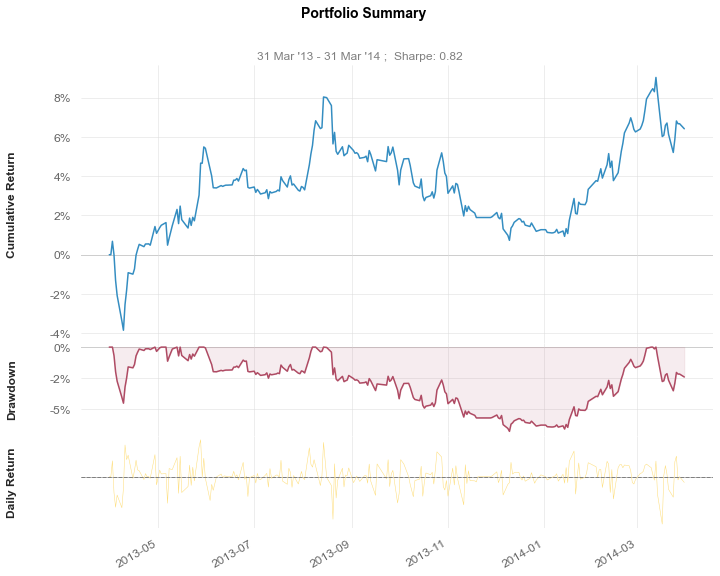

In [ ]:
import quantstats as qs
qs.reports.metrics(port_return, mode = 'basic')
qs.plots.snapshot(port_return)

---
# 전략5

## 1) 전략5 함수 : 일별수익률로 return

In [ ]:
def func_strategy5(df_func):
    
    # 1.컬럼 생성
    df_func["BS"] = ""
    df_func["보유날_종가"] = 0
    df_func["보유날_일별수익률"] = 0
    df_func["첫매수날_여부"] = 0 # 첫매수날의 일별수익율은 0이다. 일별수익률 컬럼만들어준 뒤 이거 사용해서 다시 전처리
    df_func
    
    # 2. BS 컬럼
    ## BS컬럼 생성을 위해 임의의 2개 행 만들기
    df_tm2 = pd.DataFrame(df_func.iloc[0]).T
    df_tm2["날짜"]=(df_func.index[0] - timedelta(days=2))
    df_tm2["BS"] = "sell" 
    df_tm2.set_index("날짜", inplace=True)
    df_tm2

    df_tm1 = pd.DataFrame(df_func.iloc[0]).T
    df_tm1["날짜"]=(df_func.index[0] - timedelta(days=1))
    df_tm1["BS"] = "sell"
    df_tm1.set_index("날짜", inplace=True)
    df_tm1

    df_func = pd.concat([df_tm2, df_tm1, df_func], axis=0)
    df_func.reset_index(drop=False, inplace=True)
    df_func
    
    ## BS컬럼에 buy&sell 넣기
    for i in df_func.index:
        if (i == df_func.index[0])|(i == df_func.index[1]):
            continue
    
        if df_func.loc[i-1, "BS"] == "sell": # (전날에 sell이면) buy조건 만족하는지 확인
            if (df_func.loc[i-2, "BS"] == "buy")&(df_func.loc[i-1, "BS"] == "sell")&((df_func.loc[i, "close"] >= df_func.loc[i, "MA60"])&(df_func.loc[i, "close"] >= df_func.loc[i, "MA9"])&(df_func.loc[i, "close"] >= df_func.loc[i, "MA20"])):
                df_func.loc[i-1, "BS"] = "buy"
                df_func.loc[i, "첫매수날_여부"] = 1
            
            if ((df_func.loc[i, "close"] >= df_func.loc[i, "MA60"])&(df_func.loc[i, "close"] >= df_func.loc[i, "MA9"])&(df_func.loc[i, "close"] >= df_func.loc[i, "MA20"])): # 매수사인(위 if문에도 넣기)
                df_func.loc[i, "BS"] = "buy"
            else:
                df_func.loc[i, "BS"] = "sell"
        
        else: # (전날이 "buy"일 때) sell조건
            if (df_func.loc[i, "close"] <= df_func.loc[i, "MA40"]): # 매도사인
                df_func.loc[i, "BS"] = "sell"
            else:
                df_func.loc[i, "BS"] = "buy" # sell조건 만족 안하면 "buy"
    
    # 3. "보유날_종가"
    for i in df_func.index:
        if df_func.loc[i, "BS"] == "buy":
            df_func.loc[i, "보유날_종가"] = df_func.loc[i, "close"]
    
    # 4. "보유날_일별수익률" 컬럼
    df_func["보유날_일별수익률"] = df_func["보유날_종가"].pct_change()
    df_func["보유날_일별수익률"] = df_func["보유날_일별수익률"].fillna(0)
    for i in df_func.index:
        if df_func.loc[i, "보유날_일별수익률"] == -1.0:
            df_func.loc[i, "보유날_일별수익률"] = 0
        if df_func.loc[i, "보유날_일별수익률"] == np.inf:
            df_func.loc[i, "보유날_일별수익률"] = 0
    
    # 5. "첫매수날_여부" 컬럼
    for i in df_func.index:
        if (i == df_func.index[0])|(i == df_func.index[1]):
            continue
        
        if (df_func.loc[i-1, "BS"] == "sell")&(df_func.loc[i, "BS"] == "buy"):
            df_func.loc[i, "첫매수날_여부"] = 1
    
    for i in df_func.index:
        if df_func.loc[i, "첫매수날_여부"] == 1:
            df_func.loc[i, "보유날_일별수익률"] = 0
    
    df_func.drop(index=[0,1],inplace=True)
    df_func.reset_index(drop=True, inplace=True)
    df_stock = df_func.set_index("날짜")["보유날_일별수익률"]
    
    return df_stock


## 2) 포트폴리오 일별 수익률 계산

In [ ]:
df_port = df_2012.copy()

### 1. 동등비중

In [ ]:
list_company_code = list(df_port["거래소코드"].unique())

port_return = 0 # 여기다가 각 종목 일별 수익률을 합산 후 (가중)평균
for i in list_company_code:
    df_acompany = df_port[df_port["거래소코드"]==i]
    df_stock = func_strategy5(df_acompany)
    port_return += df_stock
port_return = port_return/len(list_company_code)

### 2. 수익률 높게

### 3. 리스크 낮게

## 3) 포트폴리오 평가

                    Strategy
------------------  ----------
Start Period        2013-04-01
End Period          2014-03-31
Risk-Free Rate      0.0%
Time in Market      98.0%

Cumulative Return   22.22%
CAGR﹪              22.28%

Sharpe              2.26
Prob. Sharpe Ratio  98.42%
Sortino             3.46
Sortino/√2          2.45
Omega               1.49

Max Drawdown        -5.4%
Longest DD Days     174

Gain/Pain Ratio     0.49
Gain/Pain (1M)      2.51

Payoff Ratio        1.28
Profit Factor       1.49
Common Sense Ratio  1.76
CPC Index           1.03
Tail Ratio          1.18
Outlier Win Ratio   3.24
Outlier Loss Ratio  3.98

MTD                 5.08%
3M                  13.97%
6M                  11.92%
YTD                 13.97%
1Y                  22.22%
3Y (ann.)           22.28%
5Y (ann.)           22.28%
10Y (ann.)          22.28%
All-time (ann.)     22.28%

Avg. Drawdown       -1.33%
Avg. Drawdown Days  19
Recovery Factor     4.12
Ulcer Index         0.03
Serenity Index      0.7

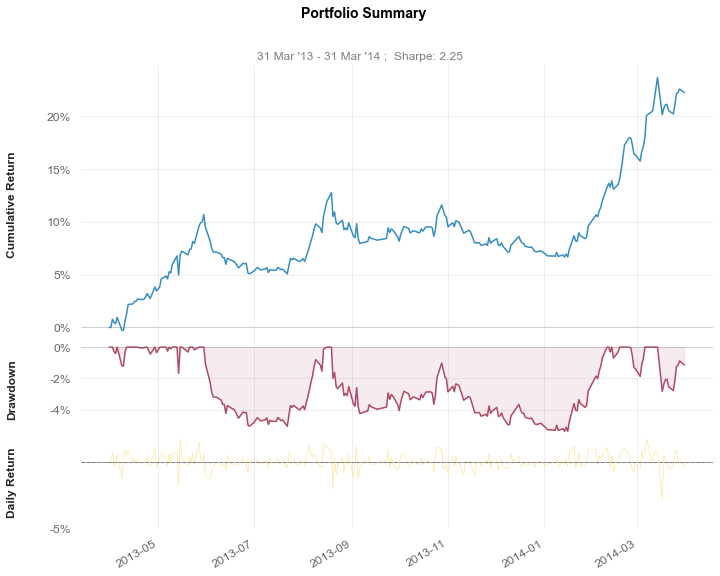

In [ ]:
import quantstats as qs
qs.reports.metrics(port_return, mode = 'basic')
qs.plots.snapshot(port_return)

---
# 투자결과 : 벤치마크와 비교

<img width="1185" alt="스크린샷 2023-05-08 오후 5 58 05" src="https://user-images.githubusercontent.com/88031549/236789517-fea17136-550d-4f4a-b20a-b977a3e6913f.png">

ㅤ
ㅤ
ㅤ
ㅤ
ㅤ
ㅤ

ㅤ
ㅤ
ㅤ
ㅤ
ㅤ

# 감사합니다.